In [1]:
"""
==============================================================================
03 - CNN-LSTM ADVANCED MODEL
==============================================================================

PURPOSE OF THIS NOTEBOOK:
-------------------------
Train and evaluate a CNN-LSTM neural network for price direction prediction.

This is our ADVANCED model because:
1. CNN layers capture local patterns (like candlestick patterns)
2. LSTM layers capture temporal dependencies (memory of past states)
3. Combination is powerful for sequential financial data

WHY CNN + LSTM?
---------------
- CNN: Good at finding local patterns in data (like chart patterns)
- LSTM: Good at remembering long-term dependencies
- Together: Can learn complex temporal patterns in price movements

EXPECTED RESULTS:
-----------------
- Neural networks often match or slightly beat tree-based models
- Main advantage: Can learn non-linear patterns automatically
- Main disadvantage: Slower training, needs more data

"""

'\n==============================================================================\n03 - CNN-LSTM ADVANCED MODEL\n==============================================================================\n\nPURPOSE OF THIS NOTEBOOK:\n-------------------------\nTrain and evaluate a CNN-LSTM neural network for price direction prediction.\n\nThis is our ADVANCED model because:\n1. CNN layers capture local patterns (like candlestick patterns)\n2. LSTM layers capture temporal dependencies (memory of past states)\n3. Combination is powerful for sequential financial data\n\nWHY CNN + LSTM?\n---------------\n- CNN: Good at finding local patterns in data (like chart patterns)\n- LSTM: Good at remembering long-term dependencies\n- Together: Can learn complex temporal patterns in price movements\n\nEXPECTED RESULTS:\n-----------------\n- Neural networks often match or slightly beat tree-based models\n- Main advantage: Can learn non-linear patterns automatically\n- Main disadvantage: Slower training, needs mo

# CNN-LSTM Advanced Model

**Goal**: Train a deep learning model that can capture temporal patterns.

**Architecture**:
1. Input: Sequence of N past feature vectors (lookback window)
2. Conv1D: Extract local patterns
3. LSTM: Capture temporal dependencies
4. Dense: Classification into UP/SIDEWAYS/DOWN

In [2]:
# ==============================================================================
# IMPORTS AND GPU CHECK
# ==============================================================================
#
# TensorFlow/Keras is used for the neural network.
# We check for GPU availability because training is MUCH faster on GPU.

import sys
from pathlib import Path

project_root = Path().absolute().parent
sys.path.insert(0, str(project_root))

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from sklearn.metrics import classification_report, confusion_matrix
import warnings

warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8-darkgrid')

# ==============================================================================
# GPU AVAILABILITY CHECK
# ==============================================================================
# Neural networks are 10-100x faster on GPU compared to CPU.
# If no GPU is detected, training will still work but be slower.

print("="*60)
print("🖥️ SYSTEM CHECK")
print("="*60)
print(f"TensorFlow version: {tf.__version__}")

gpus = tf.config.list_physical_devices('GPU')
if gpus:
    print(f"✅ GPU available: {gpus[0].name}")
    print("   Training will be fast!")
else:
    print("⚠️ No GPU detected - training will be slower")
    print("   Consider using Google Colab for faster training")

2026-01-22 10:30:59.139011: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2026-01-22 10:30:59.173887: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2026-01-22 10:31:09.161329: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


🖥️ SYSTEM CHECK
TensorFlow version: 2.20.0
✅ GPU available: /physical_device:GPU:0
   Training will be fast!


In [3]:
# ==============================================================================
# IMPORT PROJECT MODULES
# ==============================================================================

# Reload modules to pick up any code changes without restarting kernel
import importlib
import src.data.loader
import src.labeling.oracle
import src.features.builder
import src.features.indicators
import src.models.cnn_lstm
importlib.reload(src.data.loader)
importlib.reload(src.labeling.oracle)
importlib.reload(src.features.builder)
importlib.reload(src.features.indicators)
importlib.reload(src.models.cnn_lstm)

from src.data.loader import load_and_merge_data, split_data_by_time
from src.labeling.oracle import create_oracle_labels
from src.features.builder import prepare_features
from src.features.indicators import get_indicator_columns
from src.models.cnn_lstm import CNNLSTMModel

## 1. Configuration

**NEW PARAMETER - LOOKBACK:**

Unlike XGBoost which sees one row at a time, CNN-LSTM sees a SEQUENCE of rows.
`LOOKBACK=20` means the model sees the last 20 candles (5 hours for 15-min data).

This allows the model to learn patterns like:
- "Price usually reverses after 3 consecutive red candles"
- "High volume followed by low volume often precedes breakouts"

In [4]:
# ==============================================================================
# CONFIGURATION PARAMETERS
# ==============================================================================

# Oracle label parameters (same as baseline for fair comparison)
SIGMA = 4           # Gaussian smoothing sigma
THRESHOLD = 0.0002  # Slope threshold for direction classification

# Prediction horizon
HORIZON = 1         # Predict next bar direction

# CNN-LSTM specific parameter
LOOKBACK = 10       # How many past candles to look at (10 showed better results than 20)
                    # 20 candles × 15 min = 5 hours of history
                    # Experiment with: 5, 10, 20, 30, 50

# Train/Test split dates
TRAIN_END = "2025-06-30"
TEST_START = "2025-07-01"

print("="*60)
print("📋 CONFIGURATION")
print("="*60)
print(f"Oracle: sigma={SIGMA}, threshold={THRESHOLD}")
print(f"Prediction Horizon: {HORIZON} bar(s)")
print(f"Lookback Window: {LOOKBACK} candles ({LOOKBACK * 15} minutes)")
print(f"Training: up to {TRAIN_END}")
print(f"Testing: from {TEST_START}")

📋 CONFIGURATION
Oracle: sigma=4, threshold=0.0002
Prediction Horizon: 1 bar(s)
Lookback Window: 10 candles (150 minutes)
Training: up to 2025-06-30
Testing: from 2025-07-01


## 2. Load and Prepare Data

Same data loading as baseline for fair comparison.

In [5]:
# ==============================================================================
# LOAD DATA AND CREATE LABELS
# ==============================================================================

print("\n" + "="*60)
print("📥 LOADING DATA")
print("="*60)

df = load_and_merge_data(end_date='2025-12-31')
df = create_oracle_labels(df, sigma=SIGMA, threshold=THRESHOLD)

print(f"\n✅ Loaded {len(df):,} rows")
print("\nLabel distribution:")
label_counts = df['target'].value_counts(normalize=True).sort_index()
label_names = {0: 'DOWN', 1: 'SIDEWAYS', 2: 'UP'}
for label, pct in label_counts.items():
    print(f"  {label_names[label]:8s}: {pct*100:5.1f}%")


📥 LOADING DATA

📥 LOADING DATA

1️⃣ Loading klines...
   Loaded 70,752 rows

2️⃣ Loading funding rates...
   Merged funding rates

3️⃣ Loading volume breakdown...
   Merged volume breakdown
⏰ Filtered until: 2025-12-31

📊 Data Summary:
   Rows: 70,081
   Columns: 16
   Date range: 2024-01-01 00:00:00+00:00 to 2025-12-31 00:00:00+00:00
   Columns: ['time', 'open', 'high', 'low', 'close', 'volume', 'quote_volume', 'taker_buy_volume', 'taker_buy_quote_volume', 'count', 'funding_interval_hours', 'last_funding_rate', 'buy_vol', 'sell_vol', 'total_vol', 'log_return']

✅ Loaded 70,081 rows

Label distribution:
  DOWN    :  29.3%
  SIDEWAYS:  38.4%
  UP      :  32.2%


In [6]:
# ==============================================================================
# GENERATE FEATURES
# ==============================================================================
#
# For neural networks, we use fewer feature groups to avoid overfitting.
# Deep learning can learn features automatically, so we don't need as many.

print("\n" + "="*60)
print("⚙️ GENERATING FEATURES")
print("="*60)

# Use fewer groups for neural network (less prone to overfitting)
feature_groups = ['momentum', 'overlap', 'trend', 'volatility', 'volume', 'statistics']
df_features, group_map = prepare_features(df, groups=feature_groups, horizon=HORIZON)

print("\nFeature groups used:")
for group, cols in group_map.items():
    print(f"  {group}: {len(cols)} features")


⚙️ GENERATING FEATURES

🔧 PREPARING FEATURES
Groups to add: ['momentum', 'overlap', 'trend', 'volatility', 'volume', 'statistics']

📊 Adding indicators...
  -> Processing group: momentum
     Added 14 features: STOCHRSIk_14_14_3_3, AO_5_34, STOCHd_14_3_3, MOM_10, STOCHRSId_14_14_3_3...
  -> Processing group: overlap
[!] VWAP requires an ordered DatetimeIndex.
     Added 7 features: TEMA_9, EMA_20, SMA_200, EMA_100, HMA_9...
  -> Processing group: trend
     Added 17 features: MACD_12_26_9, CKSPl_10_3_20, MACDs_12_26_9, DMN_14, ADXR_14_2...
  -> Processing group: volatility
       BBL_20_2.0_2.0  BBM_20_2.0_2.0  BBU_20_2.0_2.0  BBB_20_2.0_2.0  \
0                 NaN             NaN             NaN             NaN   
1                 NaN             NaN             NaN             NaN   
2                 NaN             NaN             NaN             NaN   
3                 NaN             NaN             NaN             NaN   
4                 NaN             NaN             NaN 

In [7]:
# ==============================================================================
# TIME-BASED SPLIT
# ==============================================================================

print("\n" + "="*60)
print("📊 SPLITTING DATA")
print("="*60)

train_df, val_df, test_df = split_data_by_time(
    df_features,
    train_end=TRAIN_END,
    test_start=TEST_START,
    val_ratio=0.1  # Same as XGB for fair comparison
)

feature_cols = get_indicator_columns(
    df_features, 
    exclude_cols=['time', 'target', 'smoothed_close', 'smooth_slope']
)
feature_cols = [c for c in feature_cols if c in train_df.columns]
print(f"\n✅ Features: {len(feature_cols)}")


📊 SPLITTING DATA

📊 Data Split:
   Train: 46,947 rows (2024-01-03 15:30:00+00:00 to 2025-05-06 16:00:00+00:00)
   Val:   5,216 rows (2025-05-06 16:15:00+00:00 to 2025-06-30 00:00:00+00:00)
   Test:  17,568 rows (2025-07-01 00:00:00+00:00 to 2025-12-30 23:45:00+00:00)

✅ Features: 62


In [8]:
# ==============================================================================
# EXTRACT FEATURE MATRICES
# ==============================================================================
#
# Note: The CNN-LSTM model will internally convert these 2D arrays
# to 3D sequences using the LOOKBACK parameter.
# Shape: (samples, features) → (samples, lookback, features)

print("\n" + "="*60)
print("📐 EXTRACTING FEATURE MATRICES")
print("="*60)

X_train = train_df[feature_cols].values
y_train = train_df['target'].values.astype(int)

X_val = val_df[feature_cols].values
y_val = val_df['target'].values.astype(int)

X_test = test_df[feature_cols].values
y_test = test_df['target'].values.astype(int)

# Clean inf/nan values (some indicators like EOM produce inf from division by zero)
X_train = np.nan_to_num(X_train, nan=0.0, posinf=0.0, neginf=0.0)
X_val = np.nan_to_num(X_val, nan=0.0, posinf=0.0, neginf=0.0)
X_test = np.nan_to_num(X_test, nan=0.0, posinf=0.0, neginf=0.0)

print(f"Training:   {X_train.shape[0]:,} samples × {X_train.shape[1]} features")
print(f"Validation: {X_val.shape[0]:,} samples × {X_val.shape[1]} features")
print(f"Test:       {X_test.shape[0]:,} samples × {X_test.shape[1]} features")

print(f"\n💡 After sequence creation (lookback={LOOKBACK}):")
print(f"   Input shape will be: (samples, {LOOKBACK}, {X_train.shape[1]})")


📐 EXTRACTING FEATURE MATRICES
Training:   46,947 samples × 62 features
Validation: 5,216 samples × 62 features
Test:       17,568 samples × 62 features

💡 After sequence creation (lookback=10):
   Input shape will be: (samples, 10, 62)


## 3. Train CNN-LSTM Model

**MODEL ARCHITECTURE:**

```
Input (lookback × features)
    ↓
Conv1D (extract local patterns)
    ↓
MaxPooling (reduce dimensionality)
    ↓
LSTM (capture temporal dependencies)
    ↓
Dropout (prevent overfitting)
    ↓
Dense (classification)
    ↓
Output (3 classes)
```

**Key Parameters:**
- `conv_filters`: Number of 1D convolution filters
- `lstm_units`: LSTM hidden state size
- `dropout`: Fraction of units to drop (regularization)
- `learning_rate`: Step size for optimizer

In [9]:
# ==============================================================================
# HYPERPARAMETER TUNING (GRID SEARCH)
# ==============================================================================
#
# Перебираем комбинации гиперпараметров для нахождения лучшей модели.
# Каждая комбинация обучается с уменьшенным числом эпох для скорости.

print("\n" + "="*60)
print("🔧 HYPERPARAMETER TUNING")
print("="*60)

# Параметры для перебора
PARAM_GRID = {
    'conv_filters': [16,32, 64, 128],           # Фильтры Conv1D
    'dropout': [0.1, 0.2, 0.3],        # Dropout rate
    'learning_rate': [0.001,],   # Learning rate
    'lstm_units': [64, 96, 128],             # LSTM units
    'batch_size': [32, 64],             # Batch size
}

# Быстрый поиск с меньшим числом эпох
SEARCH_EPOCHS = 20
SEARCH_PATIENCE = 7

print(f"\nПараметры для перебора:")
for param, values in PARAM_GRID.items():
    print(f"   {param}: {values}")

total_combinations = 1
for values in PARAM_GRID.values():
    total_combinations *= len(values)
print(f"\nВсего комбинаций: {total_combinations}")
print(f"Эпох на комбинацию: {SEARCH_EPOCHS}")

# Запуск поиска
from itertools import product
import gc

results = []
best_val_acc = 0
best_params = {}

param_names = list(PARAM_GRID.keys())
param_values = list(PARAM_GRID.values())

for i, combo in enumerate(product(*param_values)):
    params = dict(zip(param_names, combo))
    
    print(f"\n[{i+1}/{total_combinations}] Testing: {params}")
    
    # Создаём модель с этими параметрами
    test_model = CNNLSTMModel(
        n_classes=3,
        lookback=LOOKBACK,
        conv_filters=params['conv_filters'],
        lstm_units=params['lstm_units'],
        dropout=params['dropout'],
        learning_rate=params['learning_rate'],
        device='cuda',
        random_seed=42
    )
    
    # Быстрое обучение
    test_model.fit(
        X_train, y_train,
        X_val, y_val,
        feature_names=feature_cols,
        epochs=SEARCH_EPOCHS,
        batch_size=params['batch_size'],
        patience=SEARCH_PATIENCE
    )
    
    # Оценка на validation
    val_metrics = test_model.evaluate(X_val, y_val)
    val_acc = val_metrics['accuracy']
    
    results.append({**params, 'val_accuracy': val_acc})
    print(f"   Val Accuracy: {val_acc:.4f}")
    
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        best_params = params.copy()
        print(f"   ⭐ New best!")
    
    # Очистка памяти
    del test_model
    gc.collect()

# Результаты поиска
print("\n" + "="*60)
print("📊 TUNING RESULTS")
print("="*60)

import pandas as pd
results_df = pd.DataFrame(results).sort_values('val_accuracy', ascending=False)
print(results_df.to_string(index=False))

print(f"\n🏆 Best parameters:")
for param, value in best_params.items():
    print(f"   {param}: {value}")
print(f"   Val Accuracy: {best_val_acc:.4f}")


🔧 HYPERPARAMETER TUNING

Параметры для перебора:
   conv_filters: [16, 32, 64, 128]
   dropout: [0.1, 0.2, 0.3]
   learning_rate: [0.001]
   lstm_units: [64, 96, 128]
   batch_size: [32, 64]

Всего комбинаций: 72
Эпох на комбинацию: 20

[1/72] Testing: {'conv_filters': 16, 'dropout': 0.1, 'learning_rate': 0.001, 'lstm_units': 64, 'batch_size': 32}
🚀 GPU detected: /physical_device:GPU:0

📊 Preparing data...
📊 Creating sequences (lookback=10)...
   Train sequences: (46937, 10, 62)
   Val sequences: (5206, 10, 62)

🏗️ Building model...


I0000 00:00:1769059878.511060   28176 gpu_device.cc:2020] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 21768 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3090, pci bus id: 0000:01:00.0, compute capability: 8.6


Model: "cnn_lstm"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input (InputLayer)              │ (None, 10, 62)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 10, 16)         │         2,992 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn_conv1 (BatchNormalization)   │ (None, 10, 16)         │            64 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ relu_conv1 (Activation)         │ (None, 10, 16)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_conv1 (Dropout)         │ (None, 10, 16)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_2 (Conv1D)               │ (None, 10, 32)         │         1,568 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn_conv2 (BatchNormalization)   │ (None, 10, 32)         │           128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ relu_conv2 (Activation)         │ (None, 10, 32)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_conv2 (Dropout)         │ (None, 10, 32)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 10, 64)         │        24,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn_lstm1 (BatchNormalization)   │ (None, 10, 64)         │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_lstm1 (Dropout)         │ (None, 10, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 128)            │        98,816 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │         4,128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 3)              │            99 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 132,883 (519.07 KB)

 Trainable params: 132,659 (518.20 KB)

 Non-trainable params: 224 (896.00 B)


🏋️ Training for up to 20 epochs (patience=7)...
Epoch 1/20


2026-01-22 10:31:21.141966: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:473] Loaded cuDNN version 91800


1467/1467 ━━━━━━━━━━━━━━━━━━━━ 24s 14ms/step - accuracy: 0.5188 - loss: 0.9778 - val_accuracy: 0.5409 - val_loss: 0.9486 - learning_rate: 0.0010
Epoch 2/20
1467/1467 ━━━━━━━━━━━━━━━━━━━━ 21s 14ms/step - accuracy: 0.5445 - loss: 0.9454 - val_accuracy: 0.5313 - val_loss: 0.9507 - learning_rate: 0.0010
Epoch 3/20
1467/1467 ━━━━━━━━━━━━━━━━━━━━ 21s 14ms/step - accuracy: 0.5506 - loss: 0.9352 - val_accuracy: 0.5375 - val_loss: 0.9509 - learning_rate: 0.0010
Epoch 4/20
1467/1467 ━━━━━━━━━━━━━━━━━━━━ 19s 13ms/step - accuracy: 0.5537 - loss: 0.9280 - val_accuracy: 0.5342 - val_loss: 0.9558 - learning_rate: 0.0010
Epoch 5/20
1467/1467 ━━━━━━━━━━━━━━━━━━━━ 21s 14ms/step - accuracy: 0.5597 - loss: 0.9194 - val_accuracy: 0.5282 - val_loss: 0.9811 - learning_rate: 0.0010
Epoch 6/20
1464/1467 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.5676 - loss: 0.9080
Epoch 6: ReduceLROnPlateau reducing learning rate to 0.0003000000142492354.
1467/1467 ━━━━━━━━━━━━━━━━━━━━ 21s 15ms/step - accuracy: 0.5655 - 

Model: "cnn_lstm"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input (InputLayer)              │ (None, 10, 62)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 10, 16)         │         2,992 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn_conv1 (BatchNormalization)   │ (None, 10, 16)         │            64 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ relu_conv1 (Activation)         │ (None, 10, 16)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_conv1 (Dropout)         │ (None, 10, 16)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_2 (Conv1D)               │ (None, 10, 32)         │         1,568 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn_conv2 (BatchNormalization)   │ (None, 10, 32)         │           128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ relu_conv2 (Activation)         │ (None, 10, 32)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_conv2 (Dropout)         │ (None, 10, 32)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 10, 64)         │        24,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn_lstm1 (BatchNormalization)   │ (None, 10, 64)         │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_lstm1 (Dropout)         │ (None, 10, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 128)            │        98,816 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │         4,128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 3)              │            99 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 132,883 (519.07 KB)

 Trainable params: 132,659 (518.20 KB)

 Non-trainable params: 224 (896.00 B)


🏋️ Training for up to 20 epochs (patience=7)...
Epoch 1/20
734/734 ━━━━━━━━━━━━━━━━━━━━ 13s 14ms/step - accuracy: 0.5126 - loss: 0.9827 - val_accuracy: 0.5476 - val_loss: 0.9372 - learning_rate: 0.0010
Epoch 2/20
734/734 ━━━━━━━━━━━━━━━━━━━━ 11s 15ms/step - accuracy: 0.5461 - loss: 0.9436 - val_accuracy: 0.5440 - val_loss: 0.9457 - learning_rate: 0.0010
Epoch 3/20
734/734 ━━━━━━━━━━━━━━━━━━━━ 10s 14ms/step - accuracy: 0.5542 - loss: 0.9312 - val_accuracy: 0.5419 - val_loss: 0.9577 - learning_rate: 0.0010
Epoch 4/20
734/734 ━━━━━━━━━━━━━━━━━━━━ 10s 13ms/step - accuracy: 0.5592 - loss: 0.9211 - val_accuracy: 0.5340 - val_loss: 0.9652 - learning_rate: 0.0010
Epoch 5/20
734/734 ━━━━━━━━━━━━━━━━━━━━ 11s 15ms/step - accuracy: 0.5675 - loss: 0.9113 - val_accuracy: 0.5357 - val_loss: 0.9725 - learning_rate: 0.0010
Epoch 6/20
734/734 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.5755 - loss: 0.8981
Epoch 6: ReduceLROnPlateau reducing learning rate to 0.0003000000142492354.
734/734 ━━━━━━━━━━

Model: "cnn_lstm"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input (InputLayer)              │ (None, 10, 62)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 10, 16)         │         2,992 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn_conv1 (BatchNormalization)   │ (None, 10, 16)         │            64 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ relu_conv1 (Activation)         │ (None, 10, 16)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_conv1 (Dropout)         │ (None, 10, 16)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_2 (Conv1D)               │ (None, 10, 32)         │         1,568 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn_conv2 (BatchNormalization)   │ (None, 10, 32)         │           128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ relu_conv2 (Activation)         │ (None, 10, 32)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_conv2 (Dropout)         │ (None, 10, 32)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 10, 96)         │        49,536 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn_lstm1 (BatchNormalization)   │ (None, 10, 96)         │           384 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_lstm1 (Dropout)         │ (None, 10, 96)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 192)            │       221,952 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │         6,176 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 3)              │            99 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 282,899 (1.08 MB)

 Trainable params: 282,611 (1.08 MB)

 Non-trainable params: 288 (1.12 KB)


🏋️ Training for up to 20 epochs (patience=7)...
Epoch 1/20
1467/1467 ━━━━━━━━━━━━━━━━━━━━ 24s 15ms/step - accuracy: 0.5174 - loss: 0.9793 - val_accuracy: 0.5217 - val_loss: 0.9640 - learning_rate: 0.0010
Epoch 2/20
1467/1467 ━━━━━━━━━━━━━━━━━━━━ 20s 13ms/step - accuracy: 0.5425 - loss: 0.9467 - val_accuracy: 0.5300 - val_loss: 0.9502 - learning_rate: 0.0010
Epoch 3/20
1467/1467 ━━━━━━━━━━━━━━━━━━━━ 22s 15ms/step - accuracy: 0.5503 - loss: 0.9359 - val_accuracy: 0.5350 - val_loss: 0.9482 - learning_rate: 0.0010
Epoch 4/20
1467/1467 ━━━━━━━━━━━━━━━━━━━━ 22s 15ms/step - accuracy: 0.5545 - loss: 0.9278 - val_accuracy: 0.5273 - val_loss: 0.9577 - learning_rate: 0.0010
Epoch 5/20
1467/1467 ━━━━━━━━━━━━━━━━━━━━ 19s 13ms/step - accuracy: 0.5620 - loss: 0.9200 - val_accuracy: 0.5325 - val_loss: 0.9632 - learning_rate: 0.0010
Epoch 6/20
1467/1467 ━━━━━━━━━━━━━━━━━━━━ 22s 15ms/step - accuracy: 0.5677 - loss: 0.9109 - val_accuracy: 0.5315 - val_loss: 0.9637 - learning_rate: 0.0010
Epoch 7/20
1467

Model: "cnn_lstm"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input (InputLayer)              │ (None, 10, 62)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 10, 16)         │         2,992 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn_conv1 (BatchNormalization)   │ (None, 10, 16)         │            64 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ relu_conv1 (Activation)         │ (None, 10, 16)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_conv1 (Dropout)         │ (None, 10, 16)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_2 (Conv1D)               │ (None, 10, 32)         │         1,568 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn_conv2 (BatchNormalization)   │ (None, 10, 32)         │           128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ relu_conv2 (Activation)         │ (None, 10, 32)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_conv2 (Dropout)         │ (None, 10, 32)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 10, 96)         │        49,536 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn_lstm1 (BatchNormalization)   │ (None, 10, 96)         │           384 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_lstm1 (Dropout)         │ (None, 10, 96)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 192)            │       221,952 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │         6,176 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 3)              │            99 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 282,899 (1.08 MB)

 Trainable params: 282,611 (1.08 MB)

 Non-trainable params: 288 (1.12 KB)


🏋️ Training for up to 20 epochs (patience=7)...
Epoch 1/20
734/734 ━━━━━━━━━━━━━━━━━━━━ 12s 13ms/step - accuracy: 0.5123 - loss: 0.9842 - val_accuracy: 0.5317 - val_loss: 0.9545 - learning_rate: 0.0010
Epoch 2/20
734/734 ━━━━━━━━━━━━━━━━━━━━ 9s 13ms/step - accuracy: 0.5448 - loss: 0.9428 - val_accuracy: 0.5380 - val_loss: 0.9604 - learning_rate: 0.0010
Epoch 3/20
734/734 ━━━━━━━━━━━━━━━━━━━━ 11s 15ms/step - accuracy: 0.5576 - loss: 0.9296 - val_accuracy: 0.5255 - val_loss: 0.9733 - learning_rate: 0.0010
Epoch 4/20
734/734 ━━━━━━━━━━━━━━━━━━━━ 9s 13ms/step - accuracy: 0.5648 - loss: 0.9196 - val_accuracy: 0.5400 - val_loss: 0.9687 - learning_rate: 0.0010
Epoch 5/20
734/734 ━━━━━━━━━━━━━━━━━━━━ 10s 14ms/step - accuracy: 0.5694 - loss: 0.9089 - val_accuracy: 0.5346 - val_loss: 0.9763 - learning_rate: 0.0010
Epoch 6/20
734/734 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.5824 - loss: 0.8938
Epoch 6: ReduceLROnPlateau reducing learning rate to 0.0003000000142492354.
734/734 ━━━━━━━━━━━━

Model: "cnn_lstm"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input (InputLayer)              │ (None, 10, 62)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 10, 16)         │         2,992 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn_conv1 (BatchNormalization)   │ (None, 10, 16)         │            64 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ relu_conv1 (Activation)         │ (None, 10, 16)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_conv1 (Dropout)         │ (None, 10, 16)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_2 (Conv1D)               │ (None, 10, 32)         │         1,568 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn_conv2 (BatchNormalization)   │ (None, 10, 32)         │           128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ relu_conv2 (Activation)         │ (None, 10, 32)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_conv2 (Dropout)         │ (None, 10, 32)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 10, 128)        │        82,432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn_lstm1 (BatchNormalization)   │ (None, 10, 128)        │           512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_lstm1 (Dropout)         │ (None, 10, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 256)            │       394,240 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │         8,224 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 3)              │            99 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 490,259 (1.87 MB)

 Trainable params: 489,907 (1.87 MB)

 Non-trainable params: 352 (1.38 KB)


🏋️ Training for up to 20 epochs (patience=7)...
Epoch 1/20
1467/1467 ━━━━━━━━━━━━━━━━━━━━ 24s 15ms/step - accuracy: 0.5165 - loss: 0.9836 - val_accuracy: 0.5484 - val_loss: 0.9427 - learning_rate: 0.0010
Epoch 2/20
1467/1467 ━━━━━━━━━━━━━━━━━━━━ 22s 15ms/step - accuracy: 0.5443 - loss: 0.9473 - val_accuracy: 0.5474 - val_loss: 0.9441 - learning_rate: 0.0010
Epoch 3/20
1467/1467 ━━━━━━━━━━━━━━━━━━━━ 21s 14ms/step - accuracy: 0.5496 - loss: 0.9381 - val_accuracy: 0.5446 - val_loss: 0.9471 - learning_rate: 0.0010
Epoch 4/20
1467/1467 ━━━━━━━━━━━━━━━━━━━━ 22s 15ms/step - accuracy: 0.5535 - loss: 0.9285 - val_accuracy: 0.5305 - val_loss: 0.9547 - learning_rate: 0.0010
Epoch 5/20
1467/1467 ━━━━━━━━━━━━━━━━━━━━ 22s 15ms/step - accuracy: 0.5612 - loss: 0.9202 - val_accuracy: 0.5363 - val_loss: 0.9645 - learning_rate: 0.0010
Epoch 6/20
1467/1467 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.5653 - loss: 0.9095
Epoch 6: ReduceLROnPlateau reducing learning rate to 0.0003000000142492354.
1467/1

Model: "cnn_lstm"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input (InputLayer)              │ (None, 10, 62)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 10, 16)         │         2,992 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn_conv1 (BatchNormalization)   │ (None, 10, 16)         │            64 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ relu_conv1 (Activation)         │ (None, 10, 16)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_conv1 (Dropout)         │ (None, 10, 16)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_2 (Conv1D)               │ (None, 10, 32)         │         1,568 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn_conv2 (BatchNormalization)   │ (None, 10, 32)         │           128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ relu_conv2 (Activation)         │ (None, 10, 32)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_conv2 (Dropout)         │ (None, 10, 32)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 10, 128)        │        82,432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn_lstm1 (BatchNormalization)   │ (None, 10, 128)        │           512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_lstm1 (Dropout)         │ (None, 10, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 256)            │       394,240 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │         8,224 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 3)              │            99 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 490,259 (1.87 MB)

 Trainable params: 489,907 (1.87 MB)

 Non-trainable params: 352 (1.38 KB)


🏋️ Training for up to 20 epochs (patience=7)...
Epoch 1/20
734/734 ━━━━━━━━━━━━━━━━━━━━ 12s 14ms/step - accuracy: 0.5111 - loss: 0.9850 - val_accuracy: 0.5467 - val_loss: 0.9450 - learning_rate: 0.0010
Epoch 2/20
734/734 ━━━━━━━━━━━━━━━━━━━━ 12s 16ms/step - accuracy: 0.5448 - loss: 0.9421 - val_accuracy: 0.5398 - val_loss: 0.9502 - learning_rate: 0.0010
Epoch 3/20
734/734 ━━━━━━━━━━━━━━━━━━━━ 10s 14ms/step - accuracy: 0.5523 - loss: 0.9327 - val_accuracy: 0.5469 - val_loss: 0.9461 - learning_rate: 0.0010
Epoch 4/20
734/734 ━━━━━━━━━━━━━━━━━━━━ 10s 14ms/step - accuracy: 0.5587 - loss: 0.9227 - val_accuracy: 0.5392 - val_loss: 0.9620 - learning_rate: 0.0010
Epoch 5/20
734/734 ━━━━━━━━━━━━━━━━━━━━ 12s 16ms/step - accuracy: 0.5631 - loss: 0.9143 - val_accuracy: 0.5352 - val_loss: 0.9648 - learning_rate: 0.0010
Epoch 6/20
733/734 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.5718 - loss: 0.9015
Epoch 6: ReduceLROnPlateau reducing learning rate to 0.0003000000142492354.
734/734 ━━━━━━━━━━

Model: "cnn_lstm"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input (InputLayer)              │ (None, 10, 62)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 10, 16)         │         2,992 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn_conv1 (BatchNormalization)   │ (None, 10, 16)         │            64 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ relu_conv1 (Activation)         │ (None, 10, 16)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_conv1 (Dropout)         │ (None, 10, 16)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_2 (Conv1D)               │ (None, 10, 32)         │         1,568 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn_conv2 (BatchNormalization)   │ (None, 10, 32)         │           128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ relu_conv2 (Activation)         │ (None, 10, 32)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_conv2 (Dropout)         │ (None, 10, 32)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 10, 64)         │        24,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn_lstm1 (BatchNormalization)   │ (None, 10, 64)         │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_lstm1 (Dropout)         │ (None, 10, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 128)            │        98,816 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │         4,128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 3)              │            99 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 132,883 (519.07 KB)

 Trainable params: 132,659 (518.20 KB)

 Non-trainable params: 224 (896.00 B)


🏋️ Training for up to 20 epochs (patience=7)...
Epoch 1/20
1467/1467 ━━━━━━━━━━━━━━━━━━━━ 23s 14ms/step - accuracy: 0.5097 - loss: 0.9857 - val_accuracy: 0.5438 - val_loss: 0.9428 - learning_rate: 0.0010
Epoch 2/20
1467/1467 ━━━━━━━━━━━━━━━━━━━━ 23s 15ms/step - accuracy: 0.5398 - loss: 0.9503 - val_accuracy: 0.5300 - val_loss: 0.9567 - learning_rate: 0.0010
Epoch 3/20
1467/1467 ━━━━━━━━━━━━━━━━━━━━ 22s 15ms/step - accuracy: 0.5441 - loss: 0.9435 - val_accuracy: 0.5323 - val_loss: 0.9551 - learning_rate: 0.0010
Epoch 4/20
1467/1467 ━━━━━━━━━━━━━━━━━━━━ 20s 13ms/step - accuracy: 0.5478 - loss: 0.9369 - val_accuracy: 0.5298 - val_loss: 0.9648 - learning_rate: 0.0010
Epoch 5/20
1467/1467 ━━━━━━━━━━━━━━━━━━━━ 22s 15ms/step - accuracy: 0.5510 - loss: 0.9312 - val_accuracy: 0.5288 - val_loss: 0.9585 - learning_rate: 0.0010
Epoch 6/20
1465/1467 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.5577 - loss: 0.9246
Epoch 6: ReduceLROnPlateau reducing learning rate to 0.0003000000142492354.
1467/1

Model: "cnn_lstm"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input (InputLayer)              │ (None, 10, 62)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 10, 16)         │         2,992 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn_conv1 (BatchNormalization)   │ (None, 10, 16)         │            64 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ relu_conv1 (Activation)         │ (None, 10, 16)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_conv1 (Dropout)         │ (None, 10, 16)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_2 (Conv1D)               │ (None, 10, 32)         │         1,568 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn_conv2 (BatchNormalization)   │ (None, 10, 32)         │           128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ relu_conv2 (Activation)         │ (None, 10, 32)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_conv2 (Dropout)         │ (None, 10, 32)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 10, 64)         │        24,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn_lstm1 (BatchNormalization)   │ (None, 10, 64)         │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_lstm1 (Dropout)         │ (None, 10, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 128)            │        98,816 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │         4,128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 3)              │            99 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 132,883 (519.07 KB)

 Trainable params: 132,659 (518.20 KB)

 Non-trainable params: 224 (896.00 B)


🏋️ Training for up to 20 epochs (patience=7)...
Epoch 1/20
734/734 ━━━━━━━━━━━━━━━━━━━━ 12s 13ms/step - accuracy: 0.5103 - loss: 0.9874 - val_accuracy: 0.5252 - val_loss: 0.9616 - learning_rate: 0.0010
Epoch 2/20
734/734 ━━━━━━━━━━━━━━━━━━━━ 11s 14ms/step - accuracy: 0.5409 - loss: 0.9505 - val_accuracy: 0.5213 - val_loss: 0.9685 - learning_rate: 0.0010
Epoch 3/20
734/734 ━━━━━━━━━━━━━━━━━━━━ 10s 14ms/step - accuracy: 0.5478 - loss: 0.9409 - val_accuracy: 0.5359 - val_loss: 0.9540 - learning_rate: 0.0010
Epoch 4/20
734/734 ━━━━━━━━━━━━━━━━━━━━ 10s 14ms/step - accuracy: 0.5546 - loss: 0.9336 - val_accuracy: 0.5355 - val_loss: 0.9570 - learning_rate: 0.0010
Epoch 5/20
734/734 ━━━━━━━━━━━━━━━━━━━━ 12s 17ms/step - accuracy: 0.5582 - loss: 0.9284 - val_accuracy: 0.5211 - val_loss: 0.9611 - learning_rate: 0.0010
Epoch 6/20
734/734 ━━━━━━━━━━━━━━━━━━━━ 10s 14ms/step - accuracy: 0.5626 - loss: 0.9211 - val_accuracy: 0.5288 - val_loss: 0.9616 - learning_rate: 0.0010
Epoch 7/20
734/734 ━━━━━━━━

Model: "cnn_lstm"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input (InputLayer)              │ (None, 10, 62)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 10, 16)         │         2,992 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn_conv1 (BatchNormalization)   │ (None, 10, 16)         │            64 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ relu_conv1 (Activation)         │ (None, 10, 16)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_conv1 (Dropout)         │ (None, 10, 16)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_2 (Conv1D)               │ (None, 10, 32)         │         1,568 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn_conv2 (BatchNormalization)   │ (None, 10, 32)         │           128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ relu_conv2 (Activation)         │ (None, 10, 32)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_conv2 (Dropout)         │ (None, 10, 32)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 10, 96)         │        49,536 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn_lstm1 (BatchNormalization)   │ (None, 10, 96)         │           384 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_lstm1 (Dropout)         │ (None, 10, 96)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 192)            │       221,952 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │         6,176 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 3)              │            99 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 282,899 (1.08 MB)

 Trainable params: 282,611 (1.08 MB)

 Non-trainable params: 288 (1.12 KB)


🏋️ Training for up to 20 epochs (patience=7)...
Epoch 1/20
1467/1467 ━━━━━━━━━━━━━━━━━━━━ 24s 15ms/step - accuracy: 0.5122 - loss: 0.9877 - val_accuracy: 0.5215 - val_loss: 0.9618 - learning_rate: 0.0010
Epoch 2/20
1467/1467 ━━━━━━━━━━━━━━━━━━━━ 24s 16ms/step - accuracy: 0.5400 - loss: 0.9536 - val_accuracy: 0.5467 - val_loss: 0.9470 - learning_rate: 0.0010
Epoch 3/20
1467/1467 ━━━━━━━━━━━━━━━━━━━━ 22s 15ms/step - accuracy: 0.5443 - loss: 0.9445 - val_accuracy: 0.5254 - val_loss: 0.9538 - learning_rate: 0.0010
Epoch 4/20
1467/1467 ━━━━━━━━━━━━━━━━━━━━ 21s 14ms/step - accuracy: 0.5504 - loss: 0.9379 - val_accuracy: 0.5275 - val_loss: 0.9561 - learning_rate: 0.0010
Epoch 5/20
1467/1467 ━━━━━━━━━━━━━━━━━━━━ 21s 14ms/step - accuracy: 0.5536 - loss: 0.9330 - val_accuracy: 0.5330 - val_loss: 0.9499 - learning_rate: 0.0010
Epoch 6/20
1467/1467 ━━━━━━━━━━━━━━━━━━━━ 23s 16ms/step - accuracy: 0.5581 - loss: 0.9278 - val_accuracy: 0.5373 - val_loss: 0.9468 - learning_rate: 0.0010
Epoch 7/20
1466

Model: "cnn_lstm"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input (InputLayer)              │ (None, 10, 62)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 10, 16)         │         2,992 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn_conv1 (BatchNormalization)   │ (None, 10, 16)         │            64 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ relu_conv1 (Activation)         │ (None, 10, 16)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_conv1 (Dropout)         │ (None, 10, 16)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_2 (Conv1D)               │ (None, 10, 32)         │         1,568 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn_conv2 (BatchNormalization)   │ (None, 10, 32)         │           128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ relu_conv2 (Activation)         │ (None, 10, 32)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_conv2 (Dropout)         │ (None, 10, 32)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 10, 96)         │        49,536 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn_lstm1 (BatchNormalization)   │ (None, 10, 96)         │           384 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_lstm1 (Dropout)         │ (None, 10, 96)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 192)            │       221,952 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │         6,176 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 3)              │            99 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 282,899 (1.08 MB)

 Trainable params: 282,611 (1.08 MB)

 Non-trainable params: 288 (1.12 KB)


🏋️ Training for up to 20 epochs (patience=7)...
Epoch 1/20
734/734 ━━━━━━━━━━━━━━━━━━━━ 13s 15ms/step - accuracy: 0.5094 - loss: 0.9883 - val_accuracy: 0.5451 - val_loss: 0.9478 - learning_rate: 0.0010
Epoch 2/20
734/734 ━━━━━━━━━━━━━━━━━━━━ 13s 18ms/step - accuracy: 0.5402 - loss: 0.9494 - val_accuracy: 0.5363 - val_loss: 0.9454 - learning_rate: 0.0010
Epoch 3/20
734/734 ━━━━━━━━━━━━━━━━━━━━ 11s 14ms/step - accuracy: 0.5494 - loss: 0.9384 - val_accuracy: 0.5438 - val_loss: 0.9500 - learning_rate: 0.0010
Epoch 4/20
734/734 ━━━━━━━━━━━━━━━━━━━━ 10s 13ms/step - accuracy: 0.5553 - loss: 0.9307 - val_accuracy: 0.5426 - val_loss: 0.9501 - learning_rate: 0.0010
Epoch 5/20
734/734 ━━━━━━━━━━━━━━━━━━━━ 11s 15ms/step - accuracy: 0.5572 - loss: 0.9256 - val_accuracy: 0.5438 - val_loss: 0.9514 - learning_rate: 0.0010
Epoch 6/20
734/734 ━━━━━━━━━━━━━━━━━━━━ 10s 13ms/step - accuracy: 0.5642 - loss: 0.9185 - val_accuracy: 0.5438 - val_loss: 0.9547 - learning_rate: 0.0010
Epoch 7/20
731/734 ━━━━━━━━

Model: "cnn_lstm"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input (InputLayer)              │ (None, 10, 62)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 10, 16)         │         2,992 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn_conv1 (BatchNormalization)   │ (None, 10, 16)         │            64 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ relu_conv1 (Activation)         │ (None, 10, 16)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_conv1 (Dropout)         │ (None, 10, 16)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_2 (Conv1D)               │ (None, 10, 32)         │         1,568 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn_conv2 (BatchNormalization)   │ (None, 10, 32)         │           128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ relu_conv2 (Activation)         │ (None, 10, 32)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_conv2 (Dropout)         │ (None, 10, 32)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 10, 128)        │        82,432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn_lstm1 (BatchNormalization)   │ (None, 10, 128)        │           512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_lstm1 (Dropout)         │ (None, 10, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 256)            │       394,240 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │         8,224 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 3)              │            99 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 490,259 (1.87 MB)

 Trainable params: 489,907 (1.87 MB)

 Non-trainable params: 352 (1.38 KB)


🏋️ Training for up to 20 epochs (patience=7)...
Epoch 1/20
1467/1467 ━━━━━━━━━━━━━━━━━━━━ 23s 14ms/step - accuracy: 0.5103 - loss: 0.9895 - val_accuracy: 0.5373 - val_loss: 0.9501 - learning_rate: 0.0010
Epoch 2/20
1467/1467 ━━━━━━━━━━━━━━━━━━━━ 21s 14ms/step - accuracy: 0.5387 - loss: 0.9544 - val_accuracy: 0.5444 - val_loss: 0.9492 - learning_rate: 0.0010
Epoch 3/20
1467/1467 ━━━━━━━━━━━━━━━━━━━━ 20s 13ms/step - accuracy: 0.5431 - loss: 0.9459 - val_accuracy: 0.5350 - val_loss: 0.9536 - learning_rate: 0.0010
Epoch 4/20
1467/1467 ━━━━━━━━━━━━━━━━━━━━ 20s 13ms/step - accuracy: 0.5483 - loss: 0.9403 - val_accuracy: 0.5271 - val_loss: 0.9599 - learning_rate: 0.0010
Epoch 5/20
1467/1467 ━━━━━━━━━━━━━━━━━━━━ 19s 13ms/step - accuracy: 0.5522 - loss: 0.9345 - val_accuracy: 0.5355 - val_loss: 0.9534 - learning_rate: 0.0010
Epoch 6/20
1465/1467 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.5543 - loss: 0.9273
Epoch 6: ReduceLROnPlateau reducing learning rate to 0.0003000000142492354.
1467/1

Model: "cnn_lstm"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input (InputLayer)              │ (None, 10, 62)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 10, 16)         │         2,992 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn_conv1 (BatchNormalization)   │ (None, 10, 16)         │            64 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ relu_conv1 (Activation)         │ (None, 10, 16)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_conv1 (Dropout)         │ (None, 10, 16)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_2 (Conv1D)               │ (None, 10, 32)         │         1,568 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn_conv2 (BatchNormalization)   │ (None, 10, 32)         │           128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ relu_conv2 (Activation)         │ (None, 10, 32)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_conv2 (Dropout)         │ (None, 10, 32)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 10, 128)        │        82,432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn_lstm1 (BatchNormalization)   │ (None, 10, 128)        │           512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_lstm1 (Dropout)         │ (None, 10, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 256)            │       394,240 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │         8,224 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 3)              │            99 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 490,259 (1.87 MB)

 Trainable params: 489,907 (1.87 MB)

 Non-trainable params: 352 (1.38 KB)


🏋️ Training for up to 20 epochs (patience=7)...
Epoch 1/20
734/734 ━━━━━━━━━━━━━━━━━━━━ 13s 15ms/step - accuracy: 0.5096 - loss: 0.9888 - val_accuracy: 0.5313 - val_loss: 0.9516 - learning_rate: 0.0010
Epoch 2/20
734/734 ━━━━━━━━━━━━━━━━━━━━ 10s 13ms/step - accuracy: 0.5391 - loss: 0.9513 - val_accuracy: 0.5440 - val_loss: 0.9473 - learning_rate: 0.0010
Epoch 3/20
734/734 ━━━━━━━━━━━━━━━━━━━━ 10s 13ms/step - accuracy: 0.5483 - loss: 0.9423 - val_accuracy: 0.5499 - val_loss: 0.9422 - learning_rate: 0.0010
Epoch 4/20
734/734 ━━━━━━━━━━━━━━━━━━━━ 11s 15ms/step - accuracy: 0.5512 - loss: 0.9360 - val_accuracy: 0.5486 - val_loss: 0.9498 - learning_rate: 0.0010
Epoch 5/20
734/734 ━━━━━━━━━━━━━━━━━━━━ 10s 13ms/step - accuracy: 0.5543 - loss: 0.9303 - val_accuracy: 0.5363 - val_loss: 0.9559 - learning_rate: 0.0010
Epoch 6/20
734/734 ━━━━━━━━━━━━━━━━━━━━ 9s 13ms/step - accuracy: 0.5569 - loss: 0.9275 - val_accuracy: 0.5401 - val_loss: 0.9601 - learning_rate: 0.0010
Epoch 7/20
734/734 ━━━━━━━━━

Model: "cnn_lstm"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input (InputLayer)              │ (None, 10, 62)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 10, 16)         │         2,992 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn_conv1 (BatchNormalization)   │ (None, 10, 16)         │            64 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ relu_conv1 (Activation)         │ (None, 10, 16)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_conv1 (Dropout)         │ (None, 10, 16)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_2 (Conv1D)               │ (None, 10, 32)         │         1,568 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn_conv2 (BatchNormalization)   │ (None, 10, 32)         │           128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ relu_conv2 (Activation)         │ (None, 10, 32)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_conv2 (Dropout)         │ (None, 10, 32)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 10, 64)         │        24,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn_lstm1 (BatchNormalization)   │ (None, 10, 64)         │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_lstm1 (Dropout)         │ (None, 10, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 128)            │        98,816 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │         4,128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 3)              │            99 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 132,883 (519.07 KB)

 Trainable params: 132,659 (518.20 KB)

 Non-trainable params: 224 (896.00 B)


🏋️ Training for up to 20 epochs (patience=7)...
Epoch 1/20
1467/1467 ━━━━━━━━━━━━━━━━━━━━ 26s 16ms/step - accuracy: 0.5047 - loss: 0.9936 - val_accuracy: 0.5384 - val_loss: 0.9485 - learning_rate: 0.0010
Epoch 2/20
1467/1467 ━━━━━━━━━━━━━━━━━━━━ 21s 14ms/step - accuracy: 0.5355 - loss: 0.9590 - val_accuracy: 0.5355 - val_loss: 0.9470 - learning_rate: 0.0010
Epoch 3/20
1467/1467 ━━━━━━━━━━━━━━━━━━━━ 23s 16ms/step - accuracy: 0.5429 - loss: 0.9507 - val_accuracy: 0.5396 - val_loss: 0.9480 - learning_rate: 0.0010
Epoch 4/20
1467/1467 ━━━━━━━━━━━━━━━━━━━━ 24s 16ms/step - accuracy: 0.5439 - loss: 0.9467 - val_accuracy: 0.5417 - val_loss: 0.9423 - learning_rate: 0.0010
Epoch 5/20
1467/1467 ━━━━━━━━━━━━━━━━━━━━ 23s 16ms/step - accuracy: 0.5480 - loss: 0.9417 - val_accuracy: 0.5461 - val_loss: 0.9466 - learning_rate: 0.0010
Epoch 6/20
1467/1467 ━━━━━━━━━━━━━━━━━━━━ 25s 17ms/step - accuracy: 0.5512 - loss: 0.9374 - val_accuracy: 0.5432 - val_loss: 0.9461 - learning_rate: 0.0010
Epoch 7/20
1467

Model: "cnn_lstm"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input (InputLayer)              │ (None, 10, 62)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 10, 16)         │         2,992 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn_conv1 (BatchNormalization)   │ (None, 10, 16)         │            64 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ relu_conv1 (Activation)         │ (None, 10, 16)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_conv1 (Dropout)         │ (None, 10, 16)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_2 (Conv1D)               │ (None, 10, 32)         │         1,568 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn_conv2 (BatchNormalization)   │ (None, 10, 32)         │           128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ relu_conv2 (Activation)         │ (None, 10, 32)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_conv2 (Dropout)         │ (None, 10, 32)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 10, 64)         │        24,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn_lstm1 (BatchNormalization)   │ (None, 10, 64)         │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_lstm1 (Dropout)         │ (None, 10, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 128)            │        98,816 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │         4,128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 3)              │            99 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 132,883 (519.07 KB)

 Trainable params: 132,659 (518.20 KB)

 Non-trainable params: 224 (896.00 B)


🏋️ Training for up to 20 epochs (patience=7)...
Epoch 1/20
734/734 ━━━━━━━━━━━━━━━━━━━━ 12s 14ms/step - accuracy: 0.5073 - loss: 0.9946 - val_accuracy: 0.5234 - val_loss: 0.9582 - learning_rate: 0.0010
Epoch 2/20
734/734 ━━━━━━━━━━━━━━━━━━━━ 10s 13ms/step - accuracy: 0.5350 - loss: 0.9571 - val_accuracy: 0.5303 - val_loss: 0.9539 - learning_rate: 0.0010
Epoch 3/20
734/734 ━━━━━━━━━━━━━━━━━━━━ 12s 16ms/step - accuracy: 0.5415 - loss: 0.9498 - val_accuracy: 0.5355 - val_loss: 0.9466 - learning_rate: 0.0010
Epoch 4/20
734/734 ━━━━━━━━━━━━━━━━━━━━ 10s 13ms/step - accuracy: 0.5454 - loss: 0.9406 - val_accuracy: 0.5265 - val_loss: 0.9531 - learning_rate: 0.0010
Epoch 5/20
734/734 ━━━━━━━━━━━━━━━━━━━━ 9s 12ms/step - accuracy: 0.5496 - loss: 0.9376 - val_accuracy: 0.5359 - val_loss: 0.9528 - learning_rate: 0.0010
Epoch 6/20
734/734 ━━━━━━━━━━━━━━━━━━━━ 11s 14ms/step - accuracy: 0.5516 - loss: 0.9339 - val_accuracy: 0.5336 - val_loss: 0.9588 - learning_rate: 0.0010
Epoch 7/20
734/734 ━━━━━━━━━

Model: "cnn_lstm"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input (InputLayer)              │ (None, 10, 62)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 10, 16)         │         2,992 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn_conv1 (BatchNormalization)   │ (None, 10, 16)         │            64 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ relu_conv1 (Activation)         │ (None, 10, 16)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_conv1 (Dropout)         │ (None, 10, 16)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_2 (Conv1D)               │ (None, 10, 32)         │         1,568 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn_conv2 (BatchNormalization)   │ (None, 10, 32)         │           128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ relu_conv2 (Activation)         │ (None, 10, 32)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_conv2 (Dropout)         │ (None, 10, 32)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 10, 96)         │        49,536 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn_lstm1 (BatchNormalization)   │ (None, 10, 96)         │           384 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_lstm1 (Dropout)         │ (None, 10, 96)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 192)            │       221,952 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │         6,176 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 3)              │            99 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 282,899 (1.08 MB)

 Trainable params: 282,611 (1.08 MB)

 Non-trainable params: 288 (1.12 KB)


🏋️ Training for up to 20 epochs (patience=7)...
Epoch 1/20
1467/1467 ━━━━━━━━━━━━━━━━━━━━ 24s 15ms/step - accuracy: 0.5091 - loss: 0.9913 - val_accuracy: 0.5309 - val_loss: 0.9533 - learning_rate: 0.0010
Epoch 2/20
1467/1467 ━━━━━━━━━━━━━━━━━━━━ 19s 13ms/step - accuracy: 0.5374 - loss: 0.9570 - val_accuracy: 0.5284 - val_loss: 0.9504 - learning_rate: 0.0010
Epoch 3/20
1467/1467 ━━━━━━━━━━━━━━━━━━━━ 20s 14ms/step - accuracy: 0.5419 - loss: 0.9498 - val_accuracy: 0.5257 - val_loss: 0.9480 - learning_rate: 0.0010
Epoch 4/20
1467/1467 ━━━━━━━━━━━━━━━━━━━━ 21s 14ms/step - accuracy: 0.5420 - loss: 0.9458 - val_accuracy: 0.5407 - val_loss: 0.9452 - learning_rate: 0.0010
Epoch 5/20
1467/1467 ━━━━━━━━━━━━━━━━━━━━ 20s 14ms/step - accuracy: 0.5488 - loss: 0.9397 - val_accuracy: 0.5488 - val_loss: 0.9430 - learning_rate: 0.0010
Epoch 6/20
1467/1467 ━━━━━━━━━━━━━━━━━━━━ 21s 15ms/step - accuracy: 0.5484 - loss: 0.9379 - val_accuracy: 0.5524 - val_loss: 0.9418 - learning_rate: 0.0010
Epoch 7/20
1467

Model: "cnn_lstm"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input (InputLayer)              │ (None, 10, 62)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 10, 16)         │         2,992 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn_conv1 (BatchNormalization)   │ (None, 10, 16)         │            64 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ relu_conv1 (Activation)         │ (None, 10, 16)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_conv1 (Dropout)         │ (None, 10, 16)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_2 (Conv1D)               │ (None, 10, 32)         │         1,568 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn_conv2 (BatchNormalization)   │ (None, 10, 32)         │           128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ relu_conv2 (Activation)         │ (None, 10, 32)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_conv2 (Dropout)         │ (None, 10, 32)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 10, 96)         │        49,536 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn_lstm1 (BatchNormalization)   │ (None, 10, 96)         │           384 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_lstm1 (Dropout)         │ (None, 10, 96)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 192)            │       221,952 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │         6,176 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 3)              │            99 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 282,899 (1.08 MB)

 Trainable params: 282,611 (1.08 MB)

 Non-trainable params: 288 (1.12 KB)


🏋️ Training for up to 20 epochs (patience=7)...
Epoch 1/20
734/734 ━━━━━━━━━━━━━━━━━━━━ 12s 14ms/step - accuracy: 0.5037 - loss: 0.9927 - val_accuracy: 0.5311 - val_loss: 0.9609 - learning_rate: 0.0010
Epoch 2/20
734/734 ━━━━━━━━━━━━━━━━━━━━ 12s 17ms/step - accuracy: 0.5366 - loss: 0.9566 - val_accuracy: 0.5474 - val_loss: 0.9421 - learning_rate: 0.0010
Epoch 3/20
734/734 ━━━━━━━━━━━━━━━━━━━━ 10s 14ms/step - accuracy: 0.5404 - loss: 0.9481 - val_accuracy: 0.5488 - val_loss: 0.9454 - learning_rate: 0.0010
Epoch 4/20
734/734 ━━━━━━━━━━━━━━━━━━━━ 10s 14ms/step - accuracy: 0.5459 - loss: 0.9408 - val_accuracy: 0.5436 - val_loss: 0.9546 - learning_rate: 0.0010
Epoch 5/20
734/734 ━━━━━━━━━━━━━━━━━━━━ 12s 17ms/step - accuracy: 0.5509 - loss: 0.9379 - val_accuracy: 0.5446 - val_loss: 0.9581 - learning_rate: 0.0010
Epoch 6/20
734/734 ━━━━━━━━━━━━━━━━━━━━ 9s 13ms/step - accuracy: 0.5551 - loss: 0.9315 - val_accuracy: 0.5457 - val_loss: 0.9595 - learning_rate: 0.0010
Epoch 7/20
730/734 ━━━━━━━━━

Model: "cnn_lstm"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input (InputLayer)              │ (None, 10, 62)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 10, 16)         │         2,992 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn_conv1 (BatchNormalization)   │ (None, 10, 16)         │            64 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ relu_conv1 (Activation)         │ (None, 10, 16)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_conv1 (Dropout)         │ (None, 10, 16)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_2 (Conv1D)               │ (None, 10, 32)         │         1,568 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn_conv2 (BatchNormalization)   │ (None, 10, 32)         │           128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ relu_conv2 (Activation)         │ (None, 10, 32)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_conv2 (Dropout)         │ (None, 10, 32)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 10, 128)        │        82,432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn_lstm1 (BatchNormalization)   │ (None, 10, 128)        │           512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_lstm1 (Dropout)         │ (None, 10, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 256)            │       394,240 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │         8,224 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 3)              │            99 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 490,259 (1.87 MB)

 Trainable params: 489,907 (1.87 MB)

 Non-trainable params: 352 (1.38 KB)


🏋️ Training for up to 20 epochs (patience=7)...
Epoch 1/20
1467/1467 ━━━━━━━━━━━━━━━━━━━━ 24s 15ms/step - accuracy: 0.5080 - loss: 0.9957 - val_accuracy: 0.5261 - val_loss: 0.9570 - learning_rate: 0.0010
Epoch 2/20
1467/1467 ━━━━━━━━━━━━━━━━━━━━ 19s 13ms/step - accuracy: 0.5330 - loss: 0.9607 - val_accuracy: 0.5394 - val_loss: 0.9432 - learning_rate: 0.0010
Epoch 3/20
1467/1467 ━━━━━━━━━━━━━━━━━━━━ 21s 14ms/step - accuracy: 0.5397 - loss: 0.9522 - val_accuracy: 0.5269 - val_loss: 0.9528 - learning_rate: 0.0010
Epoch 4/20
1467/1467 ━━━━━━━━━━━━━━━━━━━━ 20s 14ms/step - accuracy: 0.5441 - loss: 0.9463 - val_accuracy: 0.5263 - val_loss: 0.9502 - learning_rate: 0.0010
Epoch 5/20
1467/1467 ━━━━━━━━━━━━━━━━━━━━ 19s 13ms/step - accuracy: 0.5482 - loss: 0.9402 - val_accuracy: 0.5325 - val_loss: 0.9556 - learning_rate: 0.0010
Epoch 6/20
1467/1467 ━━━━━━━━━━━━━━━━━━━━ 21s 15ms/step - accuracy: 0.5509 - loss: 0.9379 - val_accuracy: 0.5296 - val_loss: 0.9649 - learning_rate: 0.0010
Epoch 7/20
1464

Model: "cnn_lstm"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input (InputLayer)              │ (None, 10, 62)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 10, 16)         │         2,992 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn_conv1 (BatchNormalization)   │ (None, 10, 16)         │            64 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ relu_conv1 (Activation)         │ (None, 10, 16)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_conv1 (Dropout)         │ (None, 10, 16)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_2 (Conv1D)               │ (None, 10, 32)         │         1,568 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn_conv2 (BatchNormalization)   │ (None, 10, 32)         │           128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ relu_conv2 (Activation)         │ (None, 10, 32)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_conv2 (Dropout)         │ (None, 10, 32)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 10, 128)        │        82,432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn_lstm1 (BatchNormalization)   │ (None, 10, 128)        │           512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_lstm1 (Dropout)         │ (None, 10, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 256)            │       394,240 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │         8,224 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 3)              │            99 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 490,259 (1.87 MB)

 Trainable params: 489,907 (1.87 MB)

 Non-trainable params: 352 (1.38 KB)


🏋️ Training for up to 20 epochs (patience=7)...
Epoch 1/20
734/734 ━━━━━━━━━━━━━━━━━━━━ 12s 14ms/step - accuracy: 0.5056 - loss: 0.9963 - val_accuracy: 0.5317 - val_loss: 0.9474 - learning_rate: 0.0010
Epoch 2/20
734/734 ━━━━━━━━━━━━━━━━━━━━ 12s 16ms/step - accuracy: 0.5353 - loss: 0.9590 - val_accuracy: 0.5413 - val_loss: 0.9439 - learning_rate: 0.0010
Epoch 3/20
734/734 ━━━━━━━━━━━━━━━━━━━━ 10s 14ms/step - accuracy: 0.5429 - loss: 0.9486 - val_accuracy: 0.5434 - val_loss: 0.9397 - learning_rate: 0.0010
Epoch 4/20
734/734 ━━━━━━━━━━━━━━━━━━━━ 10s 14ms/step - accuracy: 0.5437 - loss: 0.9465 - val_accuracy: 0.5482 - val_loss: 0.9348 - learning_rate: 0.0010
Epoch 5/20
734/734 ━━━━━━━━━━━━━━━━━━━━ 23s 15ms/step - accuracy: 0.5486 - loss: 0.9407 - val_accuracy: 0.5317 - val_loss: 0.9569 - learning_rate: 0.0010
Epoch 6/20
734/734 ━━━━━━━━━━━━━━━━━━━━ 10s 13ms/step - accuracy: 0.5483 - loss: 0.9371 - val_accuracy: 0.5413 - val_loss: 0.9466 - learning_rate: 0.0010
Epoch 7/20
734/734 ━━━━━━━━

Model: "cnn_lstm"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input (InputLayer)              │ (None, 10, 62)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 10, 32)         │         5,984 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn_conv1 (BatchNormalization)   │ (None, 10, 32)         │           128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ relu_conv1 (Activation)         │ (None, 10, 32)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_conv1 (Dropout)         │ (None, 10, 32)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_2 (Conv1D)               │ (None, 10, 64)         │         6,208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn_conv2 (BatchNormalization)   │ (None, 10, 64)         │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ relu_conv2 (Activation)         │ (None, 10, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_conv2 (Dropout)         │ (None, 10, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 10, 64)         │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn_lstm1 (BatchNormalization)   │ (None, 10, 64)         │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_lstm1 (Dropout)         │ (None, 10, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 128)            │        98,816 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │         4,128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 3)              │            99 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 148,899 (581.64 KB)

 Trainable params: 148,579 (580.39 KB)

 Non-trainable params: 320 (1.25 KB)


🏋️ Training for up to 20 epochs (patience=7)...
Epoch 1/20
1467/1467 ━━━━━━━━━━━━━━━━━━━━ 24s 15ms/step - accuracy: 0.5233 - loss: 0.9724 - val_accuracy: 0.5392 - val_loss: 0.9463 - learning_rate: 0.0010
Epoch 2/20
1467/1467 ━━━━━━━━━━━━━━━━━━━━ 21s 14ms/step - accuracy: 0.5466 - loss: 0.9394 - val_accuracy: 0.5419 - val_loss: 0.9430 - learning_rate: 0.0010
Epoch 3/20
1467/1467 ━━━━━━━━━━━━━━━━━━━━ 21s 14ms/step - accuracy: 0.5569 - loss: 0.9273 - val_accuracy: 0.5373 - val_loss: 0.9542 - learning_rate: 0.0010
Epoch 4/20
1467/1467 ━━━━━━━━━━━━━━━━━━━━ 22s 15ms/step - accuracy: 0.5636 - loss: 0.9141 - val_accuracy: 0.5319 - val_loss: 0.9703 - learning_rate: 0.0010
Epoch 5/20
1467/1467 ━━━━━━━━━━━━━━━━━━━━ 22s 15ms/step - accuracy: 0.5759 - loss: 0.9008 - val_accuracy: 0.5254 - val_loss: 0.9836 - learning_rate: 0.0010
Epoch 6/20
1467/1467 ━━━━━━━━━━━━━━━━━━━━ 19s 13ms/step - accuracy: 0.5835 - loss: 0.8854 - val_accuracy: 0.5232 - val_loss: 0.9828 - learning_rate: 0.0010
Epoch 7/20
1463

Model: "cnn_lstm"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input (InputLayer)              │ (None, 10, 62)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 10, 32)         │         5,984 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn_conv1 (BatchNormalization)   │ (None, 10, 32)         │           128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ relu_conv1 (Activation)         │ (None, 10, 32)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_conv1 (Dropout)         │ (None, 10, 32)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_2 (Conv1D)               │ (None, 10, 64)         │         6,208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn_conv2 (BatchNormalization)   │ (None, 10, 64)         │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ relu_conv2 (Activation)         │ (None, 10, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_conv2 (Dropout)         │ (None, 10, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 10, 64)         │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn_lstm1 (BatchNormalization)   │ (None, 10, 64)         │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_lstm1 (Dropout)         │ (None, 10, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 128)            │        98,816 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │         4,128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 3)              │            99 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 148,899 (581.64 KB)

 Trainable params: 148,579 (580.39 KB)

 Non-trainable params: 320 (1.25 KB)


🏋️ Training for up to 20 epochs (patience=7)...
Epoch 1/20
734/734 ━━━━━━━━━━━━━━━━━━━━ 13s 16ms/step - accuracy: 0.5231 - loss: 0.9696 - val_accuracy: 0.5290 - val_loss: 0.9511 - learning_rate: 0.0010
Epoch 2/20
734/734 ━━━━━━━━━━━━━━━━━━━━ 9s 13ms/step - accuracy: 0.5531 - loss: 0.9321 - val_accuracy: 0.5348 - val_loss: 0.9501 - learning_rate: 0.0010
Epoch 3/20
734/734 ━━━━━━━━━━━━━━━━━━━━ 9s 12ms/step - accuracy: 0.5639 - loss: 0.9157 - val_accuracy: 0.5131 - val_loss: 0.9745 - learning_rate: 0.0010
Epoch 4/20
734/734 ━━━━━━━━━━━━━━━━━━━━ 11s 15ms/step - accuracy: 0.5736 - loss: 0.9006 - val_accuracy: 0.5192 - val_loss: 0.9834 - learning_rate: 0.0010
Epoch 5/20
734/734 ━━━━━━━━━━━━━━━━━━━━ 9s 12ms/step - accuracy: 0.5857 - loss: 0.8816 - val_accuracy: 0.5002 - val_loss: 0.9967 - learning_rate: 0.0010
Epoch 6/20
734/734 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.6007 - loss: 0.8628
Epoch 6: ReduceLROnPlateau reducing learning rate to 0.0003000000142492354.
734/734 ━━━━━━━━━━━━━

Model: "cnn_lstm"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input (InputLayer)              │ (None, 10, 62)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 10, 32)         │         5,984 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn_conv1 (BatchNormalization)   │ (None, 10, 32)         │           128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ relu_conv1 (Activation)         │ (None, 10, 32)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_conv1 (Dropout)         │ (None, 10, 32)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_2 (Conv1D)               │ (None, 10, 64)         │         6,208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn_conv2 (BatchNormalization)   │ (None, 10, 64)         │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ relu_conv2 (Activation)         │ (None, 10, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_conv2 (Dropout)         │ (None, 10, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 10, 96)         │        61,824 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn_lstm1 (BatchNormalization)   │ (None, 10, 96)         │           384 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_lstm1 (Dropout)         │ (None, 10, 96)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 192)            │       221,952 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │         6,176 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 3)              │            99 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 303,011 (1.16 MB)

 Trainable params: 302,627 (1.15 MB)

 Non-trainable params: 384 (1.50 KB)


🏋️ Training for up to 20 epochs (patience=7)...
Epoch 1/20
1467/1467 ━━━━━━━━━━━━━━━━━━━━ 22s 14ms/step - accuracy: 0.5186 - loss: 0.9758 - val_accuracy: 0.5350 - val_loss: 0.9498 - learning_rate: 0.0010
Epoch 2/20
1467/1467 ━━━━━━━━━━━━━━━━━━━━ 19s 13ms/step - accuracy: 0.5470 - loss: 0.9417 - val_accuracy: 0.5373 - val_loss: 0.9494 - learning_rate: 0.0010
Epoch 3/20
1467/1467 ━━━━━━━━━━━━━━━━━━━━ 21s 14ms/step - accuracy: 0.5552 - loss: 0.9285 - val_accuracy: 0.5319 - val_loss: 0.9628 - learning_rate: 0.0010
Epoch 4/20
1467/1467 ━━━━━━━━━━━━━━━━━━━━ 19s 13ms/step - accuracy: 0.5623 - loss: 0.9180 - val_accuracy: 0.5327 - val_loss: 0.9663 - learning_rate: 0.0010
Epoch 5/20
1467/1467 ━━━━━━━━━━━━━━━━━━━━ 21s 14ms/step - accuracy: 0.5690 - loss: 0.9056 - val_accuracy: 0.5254 - val_loss: 0.9842 - learning_rate: 0.0010
Epoch 6/20
1465/1467 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.5806 - loss: 0.8921
Epoch 6: ReduceLROnPlateau reducing learning rate to 0.0003000000142492354.
1467/1

Model: "cnn_lstm"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input (InputLayer)              │ (None, 10, 62)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 10, 32)         │         5,984 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn_conv1 (BatchNormalization)   │ (None, 10, 32)         │           128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ relu_conv1 (Activation)         │ (None, 10, 32)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_conv1 (Dropout)         │ (None, 10, 32)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_2 (Conv1D)               │ (None, 10, 64)         │         6,208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn_conv2 (BatchNormalization)   │ (None, 10, 64)         │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ relu_conv2 (Activation)         │ (None, 10, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_conv2 (Dropout)         │ (None, 10, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 10, 96)         │        61,824 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn_lstm1 (BatchNormalization)   │ (None, 10, 96)         │           384 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_lstm1 (Dropout)         │ (None, 10, 96)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 192)            │       221,952 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │         6,176 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 3)              │            99 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 303,011 (1.16 MB)

 Trainable params: 302,627 (1.15 MB)

 Non-trainable params: 384 (1.50 KB)


🏋️ Training for up to 20 epochs (patience=7)...
Epoch 1/20
734/734 ━━━━━━━━━━━━━━━━━━━━ 14s 17ms/step - accuracy: 0.5258 - loss: 0.9686 - val_accuracy: 0.5361 - val_loss: 0.9579 - learning_rate: 0.0010
Epoch 2/20
734/734 ━━━━━━━━━━━━━━━━━━━━ 11s 16ms/step - accuracy: 0.5518 - loss: 0.9316 - val_accuracy: 0.5255 - val_loss: 0.9802 - learning_rate: 0.0010
Epoch 3/20
734/734 ━━━━━━━━━━━━━━━━━━━━ 10s 14ms/step - accuracy: 0.5636 - loss: 0.9176 - val_accuracy: 0.5050 - val_loss: 0.9917 - learning_rate: 0.0010
Epoch 4/20
734/734 ━━━━━━━━━━━━━━━━━━━━ 11s 15ms/step - accuracy: 0.5734 - loss: 0.9011 - val_accuracy: 0.5148 - val_loss: 0.9914 - learning_rate: 0.0010
Epoch 5/20
734/734 ━━━━━━━━━━━━━━━━━━━━ 10s 13ms/step - accuracy: 0.5888 - loss: 0.8800 - val_accuracy: 0.4925 - val_loss: 1.0164 - learning_rate: 0.0010
Epoch 6/20
733/734 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.5985 - loss: 0.8632
Epoch 6: ReduceLROnPlateau reducing learning rate to 0.0003000000142492354.
734/734 ━━━━━━━━━━

Model: "cnn_lstm"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input (InputLayer)              │ (None, 10, 62)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 10, 32)         │         5,984 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn_conv1 (BatchNormalization)   │ (None, 10, 32)         │           128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ relu_conv1 (Activation)         │ (None, 10, 32)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_conv1 (Dropout)         │ (None, 10, 32)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_2 (Conv1D)               │ (None, 10, 64)         │         6,208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn_conv2 (BatchNormalization)   │ (None, 10, 64)         │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ relu_conv2 (Activation)         │ (None, 10, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_conv2 (Dropout)         │ (None, 10, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 10, 128)        │        98,816 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn_lstm1 (BatchNormalization)   │ (None, 10, 128)        │           512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_lstm1 (Dropout)         │ (None, 10, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 256)            │       394,240 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │         8,224 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 3)              │            99 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 514,467 (1.96 MB)

 Trainable params: 514,019 (1.96 MB)

 Non-trainable params: 448 (1.75 KB)


🏋️ Training for up to 20 epochs (patience=7)...
Epoch 1/20
1467/1467 ━━━━━━━━━━━━━━━━━━━━ 24s 15ms/step - accuracy: 0.5222 - loss: 0.9761 - val_accuracy: 0.5430 - val_loss: 0.9474 - learning_rate: 0.0010
Epoch 2/20
1467/1467 ━━━━━━━━━━━━━━━━━━━━ 20s 13ms/step - accuracy: 0.5454 - loss: 0.9440 - val_accuracy: 0.5303 - val_loss: 0.9525 - learning_rate: 0.0010
Epoch 3/20
1467/1467 ━━━━━━━━━━━━━━━━━━━━ 21s 14ms/step - accuracy: 0.5526 - loss: 0.9332 - val_accuracy: 0.5265 - val_loss: 0.9539 - learning_rate: 0.0010
Epoch 4/20
1467/1467 ━━━━━━━━━━━━━━━━━━━━ 22s 15ms/step - accuracy: 0.5606 - loss: 0.9222 - val_accuracy: 0.5280 - val_loss: 0.9599 - learning_rate: 0.0010
Epoch 5/20
1467/1467 ━━━━━━━━━━━━━━━━━━━━ 41s 14ms/step - accuracy: 0.5672 - loss: 0.9107 - val_accuracy: 0.5171 - val_loss: 0.9789 - learning_rate: 0.0010
Epoch 6/20
1465/1467 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.5745 - loss: 0.8967
Epoch 6: ReduceLROnPlateau reducing learning rate to 0.0003000000142492354.
1467/1

Model: "cnn_lstm"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input (InputLayer)              │ (None, 10, 62)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 10, 32)         │         5,984 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn_conv1 (BatchNormalization)   │ (None, 10, 32)         │           128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ relu_conv1 (Activation)         │ (None, 10, 32)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_conv1 (Dropout)         │ (None, 10, 32)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_2 (Conv1D)               │ (None, 10, 64)         │         6,208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn_conv2 (BatchNormalization)   │ (None, 10, 64)         │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ relu_conv2 (Activation)         │ (None, 10, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_conv2 (Dropout)         │ (None, 10, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 10, 128)        │        98,816 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn_lstm1 (BatchNormalization)   │ (None, 10, 128)        │           512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_lstm1 (Dropout)         │ (None, 10, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 256)            │       394,240 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │         8,224 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 3)              │            99 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 514,467 (1.96 MB)

 Trainable params: 514,019 (1.96 MB)

 Non-trainable params: 448 (1.75 KB)


🏋️ Training for up to 20 epochs (patience=7)...
Epoch 1/20
734/734 ━━━━━━━━━━━━━━━━━━━━ 12s 14ms/step - accuracy: 0.5211 - loss: 0.9734 - val_accuracy: 0.5332 - val_loss: 0.9546 - learning_rate: 0.0010
Epoch 2/20
734/734 ━━━━━━━━━━━━━━━━━━━━ 11s 14ms/step - accuracy: 0.5506 - loss: 0.9358 - val_accuracy: 0.5279 - val_loss: 0.9628 - learning_rate: 0.0010
Epoch 3/20
734/734 ━━━━━━━━━━━━━━━━━━━━ 9s 13ms/step - accuracy: 0.5592 - loss: 0.9225 - val_accuracy: 0.5200 - val_loss: 0.9808 - learning_rate: 0.0010
Epoch 4/20
734/734 ━━━━━━━━━━━━━━━━━━━━ 10s 13ms/step - accuracy: 0.5690 - loss: 0.9068 - val_accuracy: 0.5175 - val_loss: 0.9851 - learning_rate: 0.0010
Epoch 5/20
734/734 ━━━━━━━━━━━━━━━━━━━━ 12s 16ms/step - accuracy: 0.5807 - loss: 0.8895 - val_accuracy: 0.5063 - val_loss: 1.0323 - learning_rate: 0.0010
Epoch 6/20
734/734 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.5925 - loss: 0.8712
Epoch 6: ReduceLROnPlateau reducing learning rate to 0.0003000000142492354.
734/734 ━━━━━━━━━━━

Model: "cnn_lstm"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input (InputLayer)              │ (None, 10, 62)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 10, 32)         │         5,984 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn_conv1 (BatchNormalization)   │ (None, 10, 32)         │           128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ relu_conv1 (Activation)         │ (None, 10, 32)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_conv1 (Dropout)         │ (None, 10, 32)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_2 (Conv1D)               │ (None, 10, 64)         │         6,208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn_conv2 (BatchNormalization)   │ (None, 10, 64)         │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ relu_conv2 (Activation)         │ (None, 10, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_conv2 (Dropout)         │ (None, 10, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 10, 64)         │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn_lstm1 (BatchNormalization)   │ (None, 10, 64)         │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_lstm1 (Dropout)         │ (None, 10, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 128)            │        98,816 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │         4,128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 3)              │            99 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 148,899 (581.64 KB)

 Trainable params: 148,579 (580.39 KB)

 Non-trainable params: 320 (1.25 KB)


🏋️ Training for up to 20 epochs (patience=7)...
Epoch 1/20
1467/1467 ━━━━━━━━━━━━━━━━━━━━ 24s 15ms/step - accuracy: 0.5166 - loss: 0.9814 - val_accuracy: 0.5296 - val_loss: 0.9546 - learning_rate: 0.0010
Epoch 2/20
1467/1467 ━━━━━━━━━━━━━━━━━━━━ 20s 14ms/step - accuracy: 0.5423 - loss: 0.9484 - val_accuracy: 0.5413 - val_loss: 0.9418 - learning_rate: 0.0010
Epoch 3/20
1467/1467 ━━━━━━━━━━━━━━━━━━━━ 23s 16ms/step - accuracy: 0.5501 - loss: 0.9366 - val_accuracy: 0.5325 - val_loss: 0.9530 - learning_rate: 0.0010
Epoch 4/20
1467/1467 ━━━━━━━━━━━━━━━━━━━━ 22s 15ms/step - accuracy: 0.5556 - loss: 0.9275 - val_accuracy: 0.5290 - val_loss: 0.9650 - learning_rate: 0.0010
Epoch 5/20
1467/1467 ━━━━━━━━━━━━━━━━━━━━ 21s 15ms/step - accuracy: 0.5612 - loss: 0.9196 - val_accuracy: 0.5227 - val_loss: 0.9599 - learning_rate: 0.0010
Epoch 6/20
1467/1467 ━━━━━━━━━━━━━━━━━━━━ 22s 15ms/step - accuracy: 0.5665 - loss: 0.9098 - val_accuracy: 0.5254 - val_loss: 0.9708 - learning_rate: 0.0010
Epoch 7/20
1465

Model: "cnn_lstm"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input (InputLayer)              │ (None, 10, 62)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 10, 32)         │         5,984 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn_conv1 (BatchNormalization)   │ (None, 10, 32)         │           128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ relu_conv1 (Activation)         │ (None, 10, 32)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_conv1 (Dropout)         │ (None, 10, 32)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_2 (Conv1D)               │ (None, 10, 64)         │         6,208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn_conv2 (BatchNormalization)   │ (None, 10, 64)         │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ relu_conv2 (Activation)         │ (None, 10, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_conv2 (Dropout)         │ (None, 10, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 10, 64)         │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn_lstm1 (BatchNormalization)   │ (None, 10, 64)         │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_lstm1 (Dropout)         │ (None, 10, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 128)            │        98,816 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │         4,128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 3)              │            99 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 148,899 (581.64 KB)

 Trainable params: 148,579 (580.39 KB)

 Non-trainable params: 320 (1.25 KB)


🏋️ Training for up to 20 epochs (patience=7)...
Epoch 1/20
734/734 ━━━━━━━━━━━━━━━━━━━━ 14s 16ms/step - accuracy: 0.5191 - loss: 0.9753 - val_accuracy: 0.5426 - val_loss: 0.9531 - learning_rate: 0.0010
Epoch 2/20
734/734 ━━━━━━━━━━━━━━━━━━━━ 10s 14ms/step - accuracy: 0.5456 - loss: 0.9392 - val_accuracy: 0.5307 - val_loss: 0.9568 - learning_rate: 0.0010
Epoch 3/20
734/734 ━━━━━━━━━━━━━━━━━━━━ 9s 13ms/step - accuracy: 0.5559 - loss: 0.9254 - val_accuracy: 0.5259 - val_loss: 0.9655 - learning_rate: 0.0010
Epoch 4/20
734/734 ━━━━━━━━━━━━━━━━━━━━ 11s 15ms/step - accuracy: 0.5632 - loss: 0.9180 - val_accuracy: 0.5184 - val_loss: 0.9763 - learning_rate: 0.0010
Epoch 5/20
734/734 ━━━━━━━━━━━━━━━━━━━━ 10s 14ms/step - accuracy: 0.5711 - loss: 0.9048 - val_accuracy: 0.5267 - val_loss: 0.9732 - learning_rate: 0.0010
Epoch 6/20
734/734 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.5781 - loss: 0.8929
Epoch 6: ReduceLROnPlateau reducing learning rate to 0.0003000000142492354.
734/734 ━━━━━━━━━━━

Model: "cnn_lstm"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input (InputLayer)              │ (None, 10, 62)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 10, 32)         │         5,984 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn_conv1 (BatchNormalization)   │ (None, 10, 32)         │           128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ relu_conv1 (Activation)         │ (None, 10, 32)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_conv1 (Dropout)         │ (None, 10, 32)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_2 (Conv1D)               │ (None, 10, 64)         │         6,208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn_conv2 (BatchNormalization)   │ (None, 10, 64)         │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ relu_conv2 (Activation)         │ (None, 10, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_conv2 (Dropout)         │ (None, 10, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 10, 96)         │        61,824 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn_lstm1 (BatchNormalization)   │ (None, 10, 96)         │           384 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_lstm1 (Dropout)         │ (None, 10, 96)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 192)            │       221,952 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │         6,176 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 3)              │            99 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 303,011 (1.16 MB)

 Trainable params: 302,627 (1.15 MB)

 Non-trainable params: 384 (1.50 KB)


🏋️ Training for up to 20 epochs (patience=7)...
Epoch 1/20
1467/1467 ━━━━━━━━━━━━━━━━━━━━ 23s 14ms/step - accuracy: 0.5188 - loss: 0.9805 - val_accuracy: 0.5307 - val_loss: 0.9489 - learning_rate: 0.0010
Epoch 2/20
1467/1467 ━━━━━━━━━━━━━━━━━━━━ 19s 13ms/step - accuracy: 0.5433 - loss: 0.9465 - val_accuracy: 0.5511 - val_loss: 0.9466 - learning_rate: 0.0010
Epoch 3/20
1467/1467 ━━━━━━━━━━━━━━━━━━━━ 20s 14ms/step - accuracy: 0.5486 - loss: 0.9371 - val_accuracy: 0.5415 - val_loss: 0.9569 - learning_rate: 0.0010
Epoch 4/20
1467/1467 ━━━━━━━━━━━━━━━━━━━━ 20s 13ms/step - accuracy: 0.5535 - loss: 0.9301 - val_accuracy: 0.5300 - val_loss: 0.9637 - learning_rate: 0.0010
Epoch 5/20
1467/1467 ━━━━━━━━━━━━━━━━━━━━ 19s 13ms/step - accuracy: 0.5586 - loss: 0.9213 - val_accuracy: 0.5302 - val_loss: 0.9641 - learning_rate: 0.0010
Epoch 6/20
1467/1467 ━━━━━━━━━━━━━━━━━━━━ 20s 14ms/step - accuracy: 0.5647 - loss: 0.9132 - val_accuracy: 0.5279 - val_loss: 0.9729 - learning_rate: 0.0010
Epoch 7/20
1466

Model: "cnn_lstm"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input (InputLayer)              │ (None, 10, 62)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 10, 32)         │         5,984 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn_conv1 (BatchNormalization)   │ (None, 10, 32)         │           128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ relu_conv1 (Activation)         │ (None, 10, 32)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_conv1 (Dropout)         │ (None, 10, 32)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_2 (Conv1D)               │ (None, 10, 64)         │         6,208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn_conv2 (BatchNormalization)   │ (None, 10, 64)         │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ relu_conv2 (Activation)         │ (None, 10, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_conv2 (Dropout)         │ (None, 10, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 10, 96)         │        61,824 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn_lstm1 (BatchNormalization)   │ (None, 10, 96)         │           384 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_lstm1 (Dropout)         │ (None, 10, 96)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 192)            │       221,952 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │         6,176 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 3)              │            99 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 303,011 (1.16 MB)

 Trainable params: 302,627 (1.15 MB)

 Non-trainable params: 384 (1.50 KB)


🏋️ Training for up to 20 epochs (patience=7)...
Epoch 1/20
734/734 ━━━━━━━━━━━━━━━━━━━━ 14s 16ms/step - accuracy: 0.5151 - loss: 0.9823 - val_accuracy: 0.5388 - val_loss: 0.9516 - learning_rate: 0.0010
Epoch 2/20
734/734 ━━━━━━━━━━━━━━━━━━━━ 10s 13ms/step - accuracy: 0.5459 - loss: 0.9423 - val_accuracy: 0.5338 - val_loss: 0.9536 - learning_rate: 0.0010
Epoch 3/20
734/734 ━━━━━━━━━━━━━━━━━━━━ 10s 14ms/step - accuracy: 0.5557 - loss: 0.9313 - val_accuracy: 0.5298 - val_loss: 0.9543 - learning_rate: 0.0010
Epoch 4/20
734/734 ━━━━━━━━━━━━━━━━━━━━ 10s 13ms/step - accuracy: 0.5613 - loss: 0.9215 - val_accuracy: 0.5336 - val_loss: 0.9668 - learning_rate: 0.0010
Epoch 5/20
734/734 ━━━━━━━━━━━━━━━━━━━━ 12s 17ms/step - accuracy: 0.5697 - loss: 0.9109 - val_accuracy: 0.5181 - val_loss: 0.9920 - learning_rate: 0.0010
Epoch 6/20
731/734 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.5738 - loss: 0.9006
Epoch 6: ReduceLROnPlateau reducing learning rate to 0.0003000000142492354.
734/734 ━━━━━━━━━━

Model: "cnn_lstm"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input (InputLayer)              │ (None, 10, 62)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 10, 32)         │         5,984 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn_conv1 (BatchNormalization)   │ (None, 10, 32)         │           128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ relu_conv1 (Activation)         │ (None, 10, 32)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_conv1 (Dropout)         │ (None, 10, 32)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_2 (Conv1D)               │ (None, 10, 64)         │         6,208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn_conv2 (BatchNormalization)   │ (None, 10, 64)         │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ relu_conv2 (Activation)         │ (None, 10, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_conv2 (Dropout)         │ (None, 10, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 10, 128)        │        98,816 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn_lstm1 (BatchNormalization)   │ (None, 10, 128)        │           512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_lstm1 (Dropout)         │ (None, 10, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 256)            │       394,240 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │         8,224 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 3)              │            99 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 514,467 (1.96 MB)

 Trainable params: 514,019 (1.96 MB)

 Non-trainable params: 448 (1.75 KB)


🏋️ Training for up to 20 epochs (patience=7)...
Epoch 1/20
1467/1467 ━━━━━━━━━━━━━━━━━━━━ 22s 14ms/step - accuracy: 0.5211 - loss: 0.9773 - val_accuracy: 0.5426 - val_loss: 0.9482 - learning_rate: 0.0010
Epoch 2/20
1467/1467 ━━━━━━━━━━━━━━━━━━━━ 22s 15ms/step - accuracy: 0.5406 - loss: 0.9468 - val_accuracy: 0.5425 - val_loss: 0.9500 - learning_rate: 0.0010
Epoch 3/20
1467/1467 ━━━━━━━━━━━━━━━━━━━━ 21s 14ms/step - accuracy: 0.5504 - loss: 0.9374 - val_accuracy: 0.5348 - val_loss: 0.9541 - learning_rate: 0.0010
Epoch 4/20
1467/1467 ━━━━━━━━━━━━━━━━━━━━ 20s 13ms/step - accuracy: 0.5565 - loss: 0.9270 - val_accuracy: 0.5271 - val_loss: 0.9668 - learning_rate: 0.0010
Epoch 5/20
1467/1467 ━━━━━━━━━━━━━━━━━━━━ 23s 15ms/step - accuracy: 0.5630 - loss: 0.9179 - val_accuracy: 0.5250 - val_loss: 0.9690 - learning_rate: 0.0010
Epoch 6/20
1465/1467 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.5691 - loss: 0.9059
Epoch 6: ReduceLROnPlateau reducing learning rate to 0.0003000000142492354.
1467/1

Model: "cnn_lstm"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input (InputLayer)              │ (None, 10, 62)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 10, 32)         │         5,984 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn_conv1 (BatchNormalization)   │ (None, 10, 32)         │           128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ relu_conv1 (Activation)         │ (None, 10, 32)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_conv1 (Dropout)         │ (None, 10, 32)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_2 (Conv1D)               │ (None, 10, 64)         │         6,208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn_conv2 (BatchNormalization)   │ (None, 10, 64)         │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ relu_conv2 (Activation)         │ (None, 10, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_conv2 (Dropout)         │ (None, 10, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 10, 128)        │        98,816 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn_lstm1 (BatchNormalization)   │ (None, 10, 128)        │           512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_lstm1 (Dropout)         │ (None, 10, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 256)            │       394,240 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │         8,224 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 3)              │            99 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 514,467 (1.96 MB)

 Trainable params: 514,019 (1.96 MB)

 Non-trainable params: 448 (1.75 KB)


🏋️ Training for up to 20 epochs (patience=7)...
Epoch 1/20
734/734 ━━━━━━━━━━━━━━━━━━━━ 12s 14ms/step - accuracy: 0.5183 - loss: 0.9783 - val_accuracy: 0.5315 - val_loss: 0.9493 - learning_rate: 0.0010
Epoch 2/20
734/734 ━━━━━━━━━━━━━━━━━━━━ 11s 15ms/step - accuracy: 0.5452 - loss: 0.9422 - val_accuracy: 0.5348 - val_loss: 0.9514 - learning_rate: 0.0010
Epoch 3/20
734/734 ━━━━━━━━━━━━━━━━━━━━ 9s 13ms/step - accuracy: 0.5544 - loss: 0.9293 - val_accuracy: 0.5317 - val_loss: 0.9575 - learning_rate: 0.0010
Epoch 4/20
734/734 ━━━━━━━━━━━━━━━━━━━━ 10s 13ms/step - accuracy: 0.5631 - loss: 0.9183 - val_accuracy: 0.5146 - val_loss: 0.9865 - learning_rate: 0.0010
Epoch 5/20
734/734 ━━━━━━━━━━━━━━━━━━━━ 11s 15ms/step - accuracy: 0.5697 - loss: 0.9094 - val_accuracy: 0.5282 - val_loss: 0.9739 - learning_rate: 0.0010
Epoch 6/20
734/734 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.5780 - loss: 0.8962
Epoch 6: ReduceLROnPlateau reducing learning rate to 0.0003000000142492354.
734/734 ━━━━━━━━━━━

Model: "cnn_lstm"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input (InputLayer)              │ (None, 10, 62)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 10, 32)         │         5,984 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn_conv1 (BatchNormalization)   │ (None, 10, 32)         │           128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ relu_conv1 (Activation)         │ (None, 10, 32)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_conv1 (Dropout)         │ (None, 10, 32)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_2 (Conv1D)               │ (None, 10, 64)         │         6,208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn_conv2 (BatchNormalization)   │ (None, 10, 64)         │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ relu_conv2 (Activation)         │ (None, 10, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_conv2 (Dropout)         │ (None, 10, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 10, 64)         │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn_lstm1 (BatchNormalization)   │ (None, 10, 64)         │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_lstm1 (Dropout)         │ (None, 10, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 128)            │        98,816 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │         4,128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 3)              │            99 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 148,899 (581.64 KB)

 Trainable params: 148,579 (580.39 KB)

 Non-trainable params: 320 (1.25 KB)


🏋️ Training for up to 20 epochs (patience=7)...
Epoch 1/20
1467/1467 ━━━━━━━━━━━━━━━━━━━━ 21s 13ms/step - accuracy: 0.5107 - loss: 0.9883 - val_accuracy: 0.5359 - val_loss: 0.9475 - learning_rate: 0.0010
Epoch 2/20
1467/1467 ━━━━━━━━━━━━━━━━━━━━ 21s 15ms/step - accuracy: 0.5368 - loss: 0.9551 - val_accuracy: 0.5269 - val_loss: 0.9552 - learning_rate: 0.0010
Epoch 3/20
1467/1467 ━━━━━━━━━━━━━━━━━━━━ 20s 13ms/step - accuracy: 0.5445 - loss: 0.9448 - val_accuracy: 0.5373 - val_loss: 0.9583 - learning_rate: 0.0010
Epoch 4/20
1467/1467 ━━━━━━━━━━━━━━━━━━━━ 19s 13ms/step - accuracy: 0.5515 - loss: 0.9381 - val_accuracy: 0.5384 - val_loss: 0.9583 - learning_rate: 0.0010
Epoch 5/20
1467/1467 ━━━━━━━━━━━━━━━━━━━━ 20s 13ms/step - accuracy: 0.5544 - loss: 0.9326 - val_accuracy: 0.5323 - val_loss: 0.9623 - learning_rate: 0.0010
Epoch 6/20
1465/1467 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.5598 - loss: 0.9223
Epoch 6: ReduceLROnPlateau reducing learning rate to 0.0003000000142492354.
1467/1

Model: "cnn_lstm"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input (InputLayer)              │ (None, 10, 62)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 10, 32)         │         5,984 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn_conv1 (BatchNormalization)   │ (None, 10, 32)         │           128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ relu_conv1 (Activation)         │ (None, 10, 32)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_conv1 (Dropout)         │ (None, 10, 32)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_2 (Conv1D)               │ (None, 10, 64)         │         6,208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn_conv2 (BatchNormalization)   │ (None, 10, 64)         │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ relu_conv2 (Activation)         │ (None, 10, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_conv2 (Dropout)         │ (None, 10, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 10, 64)         │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn_lstm1 (BatchNormalization)   │ (None, 10, 64)         │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_lstm1 (Dropout)         │ (None, 10, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 128)            │        98,816 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │         4,128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 3)              │            99 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 148,899 (581.64 KB)

 Trainable params: 148,579 (580.39 KB)

 Non-trainable params: 320 (1.25 KB)


🏋️ Training for up to 20 epochs (patience=7)...
Epoch 1/20
734/734 ━━━━━━━━━━━━━━━━━━━━ 13s 15ms/step - accuracy: 0.5132 - loss: 0.9825 - val_accuracy: 0.5394 - val_loss: 0.9455 - learning_rate: 0.0010
Epoch 2/20
734/734 ━━━━━━━━━━━━━━━━━━━━ 12s 16ms/step - accuracy: 0.5421 - loss: 0.9474 - val_accuracy: 0.5330 - val_loss: 0.9515 - learning_rate: 0.0010
Epoch 3/20
734/734 ━━━━━━━━━━━━━━━━━━━━ 10s 14ms/step - accuracy: 0.5480 - loss: 0.9381 - val_accuracy: 0.5367 - val_loss: 0.9568 - learning_rate: 0.0010
Epoch 4/20
734/734 ━━━━━━━━━━━━━━━━━━━━ 10s 14ms/step - accuracy: 0.5542 - loss: 0.9307 - val_accuracy: 0.5350 - val_loss: 0.9573 - learning_rate: 0.0010
Epoch 5/20
734/734 ━━━━━━━━━━━━━━━━━━━━ 11s 15ms/step - accuracy: 0.5576 - loss: 0.9237 - val_accuracy: 0.5240 - val_loss: 0.9805 - learning_rate: 0.0010
Epoch 6/20
730/734 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.5624 - loss: 0.9162
Epoch 6: ReduceLROnPlateau reducing learning rate to 0.0003000000142492354.
734/734 ━━━━━━━━━━

Model: "cnn_lstm"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input (InputLayer)              │ (None, 10, 62)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 10, 32)         │         5,984 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn_conv1 (BatchNormalization)   │ (None, 10, 32)         │           128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ relu_conv1 (Activation)         │ (None, 10, 32)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_conv1 (Dropout)         │ (None, 10, 32)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_2 (Conv1D)               │ (None, 10, 64)         │         6,208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn_conv2 (BatchNormalization)   │ (None, 10, 64)         │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ relu_conv2 (Activation)         │ (None, 10, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_conv2 (Dropout)         │ (None, 10, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 10, 96)         │        61,824 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn_lstm1 (BatchNormalization)   │ (None, 10, 96)         │           384 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_lstm1 (Dropout)         │ (None, 10, 96)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 192)            │       221,952 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │         6,176 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 3)              │            99 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 303,011 (1.16 MB)

 Trainable params: 302,627 (1.15 MB)

 Non-trainable params: 384 (1.50 KB)


🏋️ Training for up to 20 epochs (patience=7)...
Epoch 1/20
1467/1467 ━━━━━━━━━━━━━━━━━━━━ 23s 15ms/step - accuracy: 0.5135 - loss: 0.9859 - val_accuracy: 0.5375 - val_loss: 0.9510 - learning_rate: 0.0010
Epoch 2/20
1467/1467 ━━━━━━━━━━━━━━━━━━━━ 20s 14ms/step - accuracy: 0.5375 - loss: 0.9530 - val_accuracy: 0.5378 - val_loss: 0.9499 - learning_rate: 0.0010
Epoch 3/20
1467/1467 ━━━━━━━━━━━━━━━━━━━━ 22s 15ms/step - accuracy: 0.5438 - loss: 0.9456 - val_accuracy: 0.5353 - val_loss: 0.9600 - learning_rate: 0.0010
Epoch 4/20
1467/1467 ━━━━━━━━━━━━━━━━━━━━ 21s 14ms/step - accuracy: 0.5508 - loss: 0.9362 - val_accuracy: 0.5311 - val_loss: 0.9611 - learning_rate: 0.0010
Epoch 5/20
1467/1467 ━━━━━━━━━━━━━━━━━━━━ 19s 13ms/step - accuracy: 0.5536 - loss: 0.9306 - val_accuracy: 0.5405 - val_loss: 0.9540 - learning_rate: 0.0010
Epoch 6/20
1467/1467 ━━━━━━━━━━━━━━━━━━━━ 23s 15ms/step - accuracy: 0.5567 - loss: 0.9247 - val_accuracy: 0.5367 - val_loss: 0.9630 - learning_rate: 0.0010
Epoch 7/20
1466

Model: "cnn_lstm"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input (InputLayer)              │ (None, 10, 62)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 10, 32)         │         5,984 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn_conv1 (BatchNormalization)   │ (None, 10, 32)         │           128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ relu_conv1 (Activation)         │ (None, 10, 32)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_conv1 (Dropout)         │ (None, 10, 32)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_2 (Conv1D)               │ (None, 10, 64)         │         6,208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn_conv2 (BatchNormalization)   │ (None, 10, 64)         │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ relu_conv2 (Activation)         │ (None, 10, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_conv2 (Dropout)         │ (None, 10, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 10, 96)         │        61,824 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn_lstm1 (BatchNormalization)   │ (None, 10, 96)         │           384 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_lstm1 (Dropout)         │ (None, 10, 96)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 192)            │       221,952 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │         6,176 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 3)              │            99 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 303,011 (1.16 MB)

 Trainable params: 302,627 (1.15 MB)

 Non-trainable params: 384 (1.50 KB)


🏋️ Training for up to 20 epochs (patience=7)...
Epoch 1/20
734/734 ━━━━━━━━━━━━━━━━━━━━ 12s 14ms/step - accuracy: 0.5117 - loss: 0.9869 - val_accuracy: 0.5280 - val_loss: 0.9623 - learning_rate: 0.0010
Epoch 2/20
734/734 ━━━━━━━━━━━━━━━━━━━━ 11s 15ms/step - accuracy: 0.5429 - loss: 0.9504 - val_accuracy: 0.5286 - val_loss: 0.9637 - learning_rate: 0.0010
Epoch 3/20
734/734 ━━━━━━━━━━━━━━━━━━━━ 9s 13ms/step - accuracy: 0.5490 - loss: 0.9393 - val_accuracy: 0.5417 - val_loss: 0.9507 - learning_rate: 0.0010
Epoch 4/20
734/734 ━━━━━━━━━━━━━━━━━━━━ 9s 13ms/step - accuracy: 0.5581 - loss: 0.9295 - val_accuracy: 0.5269 - val_loss: 0.9617 - learning_rate: 0.0010
Epoch 5/20
734/734 ━━━━━━━━━━━━━━━━━━━━ 10s 13ms/step - accuracy: 0.5595 - loss: 0.9234 - val_accuracy: 0.5275 - val_loss: 0.9672 - learning_rate: 0.0010
Epoch 6/20
734/734 ━━━━━━━━━━━━━━━━━━━━ 11s 15ms/step - accuracy: 0.5642 - loss: 0.9156 - val_accuracy: 0.5311 - val_loss: 0.9642 - learning_rate: 0.0010
Epoch 7/20
734/734 ━━━━━━━━━━

Model: "cnn_lstm"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input (InputLayer)              │ (None, 10, 62)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 10, 32)         │         5,984 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn_conv1 (BatchNormalization)   │ (None, 10, 32)         │           128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ relu_conv1 (Activation)         │ (None, 10, 32)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_conv1 (Dropout)         │ (None, 10, 32)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_2 (Conv1D)               │ (None, 10, 64)         │         6,208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn_conv2 (BatchNormalization)   │ (None, 10, 64)         │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ relu_conv2 (Activation)         │ (None, 10, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_conv2 (Dropout)         │ (None, 10, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 10, 128)        │        98,816 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn_lstm1 (BatchNormalization)   │ (None, 10, 128)        │           512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_lstm1 (Dropout)         │ (None, 10, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 256)            │       394,240 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │         8,224 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 3)              │            99 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 514,467 (1.96 MB)

 Trainable params: 514,019 (1.96 MB)

 Non-trainable params: 448 (1.75 KB)


🏋️ Training for up to 20 epochs (patience=7)...
Epoch 1/20
1467/1467 ━━━━━━━━━━━━━━━━━━━━ 23s 15ms/step - accuracy: 0.5118 - loss: 0.9877 - val_accuracy: 0.5290 - val_loss: 0.9482 - learning_rate: 0.0010
Epoch 2/20
1467/1467 ━━━━━━━━━━━━━━━━━━━━ 20s 13ms/step - accuracy: 0.5386 - loss: 0.9546 - val_accuracy: 0.5355 - val_loss: 0.9529 - learning_rate: 0.0010
Epoch 3/20
1467/1467 ━━━━━━━━━━━━━━━━━━━━ 21s 15ms/step - accuracy: 0.5435 - loss: 0.9461 - val_accuracy: 0.5423 - val_loss: 0.9496 - learning_rate: 0.0010
Epoch 4/20
1467/1467 ━━━━━━━━━━━━━━━━━━━━ 21s 14ms/step - accuracy: 0.5468 - loss: 0.9396 - val_accuracy: 0.5350 - val_loss: 0.9593 - learning_rate: 0.0010
Epoch 5/20
1467/1467 ━━━━━━━━━━━━━━━━━━━━ 20s 14ms/step - accuracy: 0.5540 - loss: 0.9321 - val_accuracy: 0.5323 - val_loss: 0.9559 - learning_rate: 0.0010
Epoch 6/20
1465/1467 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.5571 - loss: 0.9233
Epoch 6: ReduceLROnPlateau reducing learning rate to 0.0003000000142492354.
1467/1

Model: "cnn_lstm"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input (InputLayer)              │ (None, 10, 62)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 10, 32)         │         5,984 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn_conv1 (BatchNormalization)   │ (None, 10, 32)         │           128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ relu_conv1 (Activation)         │ (None, 10, 32)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_conv1 (Dropout)         │ (None, 10, 32)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_2 (Conv1D)               │ (None, 10, 64)         │         6,208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn_conv2 (BatchNormalization)   │ (None, 10, 64)         │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ relu_conv2 (Activation)         │ (None, 10, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_conv2 (Dropout)         │ (None, 10, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 10, 128)        │        98,816 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn_lstm1 (BatchNormalization)   │ (None, 10, 128)        │           512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_lstm1 (Dropout)         │ (None, 10, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 256)            │       394,240 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │         8,224 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 3)              │            99 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 514,467 (1.96 MB)

 Trainable params: 514,019 (1.96 MB)

 Non-trainable params: 448 (1.75 KB)


🏋️ Training for up to 20 epochs (patience=7)...
Epoch 1/20
734/734 ━━━━━━━━━━━━━━━━━━━━ 12s 14ms/step - accuracy: 0.5093 - loss: 0.9880 - val_accuracy: 0.5328 - val_loss: 0.9614 - learning_rate: 0.0010
Epoch 2/20
734/734 ━━━━━━━━━━━━━━━━━━━━ 10s 14ms/step - accuracy: 0.5429 - loss: 0.9479 - val_accuracy: 0.5348 - val_loss: 0.9490 - learning_rate: 0.0010
Epoch 3/20
734/734 ━━━━━━━━━━━━━━━━━━━━ 12s 16ms/step - accuracy: 0.5481 - loss: 0.9381 - val_accuracy: 0.5378 - val_loss: 0.9577 - learning_rate: 0.0010
Epoch 4/20
734/734 ━━━━━━━━━━━━━━━━━━━━ 9s 13ms/step - accuracy: 0.5531 - loss: 0.9305 - val_accuracy: 0.5357 - val_loss: 0.9631 - learning_rate: 0.0010
Epoch 5/20
734/734 ━━━━━━━━━━━━━━━━━━━━ 10s 14ms/step - accuracy: 0.5543 - loss: 0.9249 - val_accuracy: 0.5192 - val_loss: 0.9692 - learning_rate: 0.0010
Epoch 6/20
734/734 ━━━━━━━━━━━━━━━━━━━━ 11s 16ms/step - accuracy: 0.5626 - loss: 0.9159 - val_accuracy: 0.5148 - val_loss: 0.9836 - learning_rate: 0.0010
Epoch 7/20
732/734 ━━━━━━━━━

Model: "cnn_lstm"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input (InputLayer)              │ (None, 10, 62)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 10, 64)         │        11,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn_conv1 (BatchNormalization)   │ (None, 10, 64)         │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ relu_conv1 (Activation)         │ (None, 10, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_conv1 (Dropout)         │ (None, 10, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_2 (Conv1D)               │ (None, 10, 128)        │        24,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn_conv2 (BatchNormalization)   │ (None, 10, 128)        │           512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ relu_conv2 (Activation)         │ (None, 10, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_conv2 (Dropout)         │ (None, 10, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 10, 64)         │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn_lstm1 (BatchNormalization)   │ (None, 10, 64)         │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_lstm1 (Dropout)         │ (None, 10, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 128)            │        98,816 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │         4,128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 3)              │            99 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 190,147 (742.76 KB)

 Trainable params: 189,635 (740.76 KB)

 Non-trainable params: 512 (2.00 KB)


🏋️ Training for up to 20 epochs (patience=7)...
Epoch 1/20
1467/1467 ━━━━━━━━━━━━━━━━━━━━ 24s 15ms/step - accuracy: 0.5208 - loss: 0.9731 - val_accuracy: 0.5115 - val_loss: 0.9686 - learning_rate: 0.0010
Epoch 2/20
1467/1467 ━━━━━━━━━━━━━━━━━━━━ 23s 15ms/step - accuracy: 0.5464 - loss: 0.9393 - val_accuracy: 0.5184 - val_loss: 0.9737 - learning_rate: 0.0010
Epoch 3/20
1467/1467 ━━━━━━━━━━━━━━━━━━━━ 22s 15ms/step - accuracy: 0.5562 - loss: 0.9249 - val_accuracy: 0.5315 - val_loss: 0.9692 - learning_rate: 0.0010
Epoch 4/20
1467/1467 ━━━━━━━━━━━━━━━━━━━━ 20s 14ms/step - accuracy: 0.5683 - loss: 0.9082 - val_accuracy: 0.5204 - val_loss: 0.9813 - learning_rate: 0.0010
Epoch 5/20
1467/1467 ━━━━━━━━━━━━━━━━━━━━ 23s 15ms/step - accuracy: 0.5823 - loss: 0.8873 - val_accuracy: 0.5063 - val_loss: 1.0238 - learning_rate: 0.0010
Epoch 6/20
1463/1467 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.5940 - loss: 0.8681
Epoch 6: ReduceLROnPlateau reducing learning rate to 0.0003000000142492354.
1467/1

Model: "cnn_lstm"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input (InputLayer)              │ (None, 10, 62)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 10, 64)         │        11,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn_conv1 (BatchNormalization)   │ (None, 10, 64)         │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ relu_conv1 (Activation)         │ (None, 10, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_conv1 (Dropout)         │ (None, 10, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_2 (Conv1D)               │ (None, 10, 128)        │        24,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn_conv2 (BatchNormalization)   │ (None, 10, 128)        │           512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ relu_conv2 (Activation)         │ (None, 10, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_conv2 (Dropout)         │ (None, 10, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 10, 64)         │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn_lstm1 (BatchNormalization)   │ (None, 10, 64)         │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_lstm1 (Dropout)         │ (None, 10, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 128)            │        98,816 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │         4,128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 3)              │            99 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 190,147 (742.76 KB)

 Trainable params: 189,635 (740.76 KB)

 Non-trainable params: 512 (2.00 KB)


🏋️ Training for up to 20 epochs (patience=7)...
Epoch 1/20
734/734 ━━━━━━━━━━━━━━━━━━━━ 13s 15ms/step - accuracy: 0.5252 - loss: 0.9688 - val_accuracy: 0.5332 - val_loss: 0.9562 - learning_rate: 0.0010
Epoch 2/20
734/734 ━━━━━━━━━━━━━━━━━━━━ 11s 15ms/step - accuracy: 0.5544 - loss: 0.9287 - val_accuracy: 0.5255 - val_loss: 0.9627 - learning_rate: 0.0010
Epoch 3/20
734/734 ━━━━━━━━━━━━━━━━━━━━ 9s 13ms/step - accuracy: 0.5703 - loss: 0.9063 - val_accuracy: 0.5156 - val_loss: 0.9866 - learning_rate: 0.0010
Epoch 4/20
734/734 ━━━━━━━━━━━━━━━━━━━━ 10s 14ms/step - accuracy: 0.5871 - loss: 0.8795 - val_accuracy: 0.5048 - val_loss: 1.0333 - learning_rate: 0.0010
Epoch 5/20
734/734 ━━━━━━━━━━━━━━━━━━━━ 10s 14ms/step - accuracy: 0.6066 - loss: 0.8471 - val_accuracy: 0.4960 - val_loss: 1.0516 - learning_rate: 0.0010
Epoch 6/20
732/734 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.6255 - loss: 0.8167
Epoch 6: ReduceLROnPlateau reducing learning rate to 0.0003000000142492354.
734/734 ━━━━━━━━━━━

Model: "cnn_lstm"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input (InputLayer)              │ (None, 10, 62)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 10, 64)         │        11,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn_conv1 (BatchNormalization)   │ (None, 10, 64)         │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ relu_conv1 (Activation)         │ (None, 10, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_conv1 (Dropout)         │ (None, 10, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_2 (Conv1D)               │ (None, 10, 128)        │        24,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn_conv2 (BatchNormalization)   │ (None, 10, 128)        │           512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ relu_conv2 (Activation)         │ (None, 10, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_conv2 (Dropout)         │ (None, 10, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 10, 96)         │        86,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn_lstm1 (BatchNormalization)   │ (None, 10, 96)         │           384 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_lstm1 (Dropout)         │ (None, 10, 96)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 192)            │       221,952 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │         6,176 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 3)              │            99 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 352,451 (1.34 MB)

 Trainable params: 351,875 (1.34 MB)

 Non-trainable params: 576 (2.25 KB)


🏋️ Training for up to 20 epochs (patience=7)...
Epoch 1/20
1467/1467 ━━━━━━━━━━━━━━━━━━━━ 23s 15ms/step - accuracy: 0.5242 - loss: 0.9701 - val_accuracy: 0.5407 - val_loss: 0.9561 - learning_rate: 0.0010
Epoch 2/20
1467/1467 ━━━━━━━━━━━━━━━━━━━━ 20s 14ms/step - accuracy: 0.5482 - loss: 0.9398 - val_accuracy: 0.5221 - val_loss: 0.9625 - learning_rate: 0.0010
Epoch 3/20
1467/1467 ━━━━━━━━━━━━━━━━━━━━ 22s 15ms/step - accuracy: 0.5593 - loss: 0.9256 - val_accuracy: 0.5227 - val_loss: 0.9638 - learning_rate: 0.0010
Epoch 4/20
1467/1467 ━━━━━━━━━━━━━━━━━━━━ 24s 16ms/step - accuracy: 0.5696 - loss: 0.9088 - val_accuracy: 0.5242 - val_loss: 0.9696 - learning_rate: 0.0010
Epoch 5/20
1467/1467 ━━━━━━━━━━━━━━━━━━━━ 23s 16ms/step - accuracy: 0.5812 - loss: 0.8897 - val_accuracy: 0.5106 - val_loss: 1.0017 - learning_rate: 0.0010
Epoch 6/20
1467/1467 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.5955 - loss: 0.8700
Epoch 6: ReduceLROnPlateau reducing learning rate to 0.0003000000142492354.
1467/1

Model: "cnn_lstm"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input (InputLayer)              │ (None, 10, 62)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 10, 64)         │        11,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn_conv1 (BatchNormalization)   │ (None, 10, 64)         │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ relu_conv1 (Activation)         │ (None, 10, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_conv1 (Dropout)         │ (None, 10, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_2 (Conv1D)               │ (None, 10, 128)        │        24,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn_conv2 (BatchNormalization)   │ (None, 10, 128)        │           512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ relu_conv2 (Activation)         │ (None, 10, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_conv2 (Dropout)         │ (None, 10, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 10, 96)         │        86,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn_lstm1 (BatchNormalization)   │ (None, 10, 96)         │           384 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_lstm1 (Dropout)         │ (None, 10, 96)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 192)            │       221,952 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │         6,176 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 3)              │            99 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 352,451 (1.34 MB)

 Trainable params: 351,875 (1.34 MB)

 Non-trainable params: 576 (2.25 KB)


🏋️ Training for up to 20 epochs (patience=7)...
Epoch 1/20
734/734 ━━━━━━━━━━━━━━━━━━━━ 12s 14ms/step - accuracy: 0.5265 - loss: 0.9670 - val_accuracy: 0.5158 - val_loss: 0.9713 - learning_rate: 0.0010
Epoch 2/20
734/734 ━━━━━━━━━━━━━━━━━━━━ 10s 14ms/step - accuracy: 0.5536 - loss: 0.9292 - val_accuracy: 0.5175 - val_loss: 0.9825 - learning_rate: 0.0010
Epoch 3/20
734/734 ━━━━━━━━━━━━━━━━━━━━ 12s 16ms/step - accuracy: 0.5645 - loss: 0.9114 - val_accuracy: 0.5052 - val_loss: 0.9959 - learning_rate: 0.0010
Epoch 4/20
734/734 ━━━━━━━━━━━━━━━━━━━━ 11s 15ms/step - accuracy: 0.5795 - loss: 0.8890 - val_accuracy: 0.4996 - val_loss: 1.0254 - learning_rate: 0.0010
Epoch 5/20
734/734 ━━━━━━━━━━━━━━━━━━━━ 12s 16ms/step - accuracy: 0.5967 - loss: 0.8623 - val_accuracy: 0.4835 - val_loss: 1.0485 - learning_rate: 0.0010
Epoch 6/20
733/734 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.6172 - loss: 0.8279
Epoch 6: ReduceLROnPlateau reducing learning rate to 0.0003000000142492354.
734/734 ━━━━━━━━━━

Model: "cnn_lstm"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input (InputLayer)              │ (None, 10, 62)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 10, 64)         │        11,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn_conv1 (BatchNormalization)   │ (None, 10, 64)         │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ relu_conv1 (Activation)         │ (None, 10, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_conv1 (Dropout)         │ (None, 10, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_2 (Conv1D)               │ (None, 10, 128)        │        24,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn_conv2 (BatchNormalization)   │ (None, 10, 128)        │           512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ relu_conv2 (Activation)         │ (None, 10, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_conv2 (Dropout)         │ (None, 10, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 10, 128)        │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn_lstm1 (BatchNormalization)   │ (None, 10, 128)        │           512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_lstm1 (Dropout)         │ (None, 10, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 256)            │       394,240 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │         8,224 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 3)              │            99 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 572,099 (2.18 MB)

 Trainable params: 571,459 (2.18 MB)

 Non-trainable params: 640 (2.50 KB)


🏋️ Training for up to 20 epochs (patience=7)...
Epoch 1/20
1467/1467 ━━━━━━━━━━━━━━━━━━━━ 22s 14ms/step - accuracy: 0.5253 - loss: 0.9704 - val_accuracy: 0.5263 - val_loss: 0.9530 - learning_rate: 0.0010
Epoch 2/20
1467/1467 ━━━━━━━━━━━━━━━━━━━━ 21s 14ms/step - accuracy: 0.5485 - loss: 0.9392 - val_accuracy: 0.5292 - val_loss: 0.9497 - learning_rate: 0.0010
Epoch 3/20
1467/1467 ━━━━━━━━━━━━━━━━━━━━ 20s 14ms/step - accuracy: 0.5574 - loss: 0.9259 - val_accuracy: 0.5417 - val_loss: 0.9510 - learning_rate: 0.0010
Epoch 4/20
1467/1467 ━━━━━━━━━━━━━━━━━━━━ 19s 13ms/step - accuracy: 0.5656 - loss: 0.9118 - val_accuracy: 0.5325 - val_loss: 0.9705 - learning_rate: 0.0010
Epoch 5/20
1467/1467 ━━━━━━━━━━━━━━━━━━━━ 21s 14ms/step - accuracy: 0.5773 - loss: 0.8953 - val_accuracy: 0.4923 - val_loss: 1.0081 - learning_rate: 0.0010
Epoch 6/20
1467/1467 ━━━━━━━━━━━━━━━━━━━━ 18s 12ms/step - accuracy: 0.5885 - loss: 0.8766 - val_accuracy: 0.5129 - val_loss: 1.0214 - learning_rate: 0.0010
Epoch 7/20
1464

Model: "cnn_lstm"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input (InputLayer)              │ (None, 10, 62)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 10, 64)         │        11,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn_conv1 (BatchNormalization)   │ (None, 10, 64)         │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ relu_conv1 (Activation)         │ (None, 10, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_conv1 (Dropout)         │ (None, 10, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_2 (Conv1D)               │ (None, 10, 128)        │        24,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn_conv2 (BatchNormalization)   │ (None, 10, 128)        │           512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ relu_conv2 (Activation)         │ (None, 10, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_conv2 (Dropout)         │ (None, 10, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 10, 128)        │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn_lstm1 (BatchNormalization)   │ (None, 10, 128)        │           512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_lstm1 (Dropout)         │ (None, 10, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 256)            │       394,240 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │         8,224 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 3)              │            99 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 572,099 (2.18 MB)

 Trainable params: 571,459 (2.18 MB)

 Non-trainable params: 640 (2.50 KB)


🏋️ Training for up to 20 epochs (patience=7)...
Epoch 1/20
734/734 ━━━━━━━━━━━━━━━━━━━━ 13s 16ms/step - accuracy: 0.5248 - loss: 0.9701 - val_accuracy: 0.5396 - val_loss: 0.9438 - learning_rate: 0.0010
Epoch 2/20
734/734 ━━━━━━━━━━━━━━━━━━━━ 10s 13ms/step - accuracy: 0.5511 - loss: 0.9319 - val_accuracy: 0.5225 - val_loss: 0.9599 - learning_rate: 0.0010
Epoch 3/20
734/734 ━━━━━━━━━━━━━━━━━━━━ 10s 13ms/step - accuracy: 0.5666 - loss: 0.9133 - val_accuracy: 0.5179 - val_loss: 0.9765 - learning_rate: 0.0010
Epoch 4/20
734/734 ━━━━━━━━━━━━━━━━━━━━ 11s 16ms/step - accuracy: 0.5791 - loss: 0.8926 - val_accuracy: 0.5046 - val_loss: 0.9963 - learning_rate: 0.0010
Epoch 5/20
734/734 ━━━━━━━━━━━━━━━━━━━━ 10s 14ms/step - accuracy: 0.5977 - loss: 0.8641 - val_accuracy: 0.4931 - val_loss: 1.0395 - learning_rate: 0.0010
Epoch 6/20
731/734 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.6163 - loss: 0.8313
Epoch 6: ReduceLROnPlateau reducing learning rate to 0.0003000000142492354.
734/734 ━━━━━━━━━━

Model: "cnn_lstm"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input (InputLayer)              │ (None, 10, 62)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 10, 64)         │        11,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn_conv1 (BatchNormalization)   │ (None, 10, 64)         │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ relu_conv1 (Activation)         │ (None, 10, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_conv1 (Dropout)         │ (None, 10, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_2 (Conv1D)               │ (None, 10, 128)        │        24,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn_conv2 (BatchNormalization)   │ (None, 10, 128)        │           512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ relu_conv2 (Activation)         │ (None, 10, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_conv2 (Dropout)         │ (None, 10, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 10, 64)         │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn_lstm1 (BatchNormalization)   │ (None, 10, 64)         │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_lstm1 (Dropout)         │ (None, 10, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 128)            │        98,816 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │         4,128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 3)              │            99 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 190,147 (742.76 KB)

 Trainable params: 189,635 (740.76 KB)

 Non-trainable params: 512 (2.00 KB)


🏋️ Training for up to 20 epochs (patience=7)...
Epoch 1/20
1467/1467 ━━━━━━━━━━━━━━━━━━━━ 24s 15ms/step - accuracy: 0.5218 - loss: 0.9756 - val_accuracy: 0.5423 - val_loss: 0.9470 - learning_rate: 0.0010
Epoch 2/20
1467/1467 ━━━━━━━━━━━━━━━━━━━━ 43s 14ms/step - accuracy: 0.5453 - loss: 0.9443 - val_accuracy: 0.5244 - val_loss: 0.9531 - learning_rate: 0.0010
Epoch 3/20
1467/1467 ━━━━━━━━━━━━━━━━━━━━ 22s 15ms/step - accuracy: 0.5535 - loss: 0.9329 - val_accuracy: 0.5355 - val_loss: 0.9438 - learning_rate: 0.0010
Epoch 4/20
1467/1467 ━━━━━━━━━━━━━━━━━━━━ 20s 14ms/step - accuracy: 0.5599 - loss: 0.9223 - val_accuracy: 0.5225 - val_loss: 0.9669 - learning_rate: 0.0010
Epoch 5/20
1467/1467 ━━━━━━━━━━━━━━━━━━━━ 19s 13ms/step - accuracy: 0.5652 - loss: 0.9117 - val_accuracy: 0.5234 - val_loss: 0.9670 - learning_rate: 0.0010
Epoch 6/20
1467/1467 ━━━━━━━━━━━━━━━━━━━━ 22s 15ms/step - accuracy: 0.5761 - loss: 0.8980 - val_accuracy: 0.5136 - val_loss: 0.9911 - learning_rate: 0.0010
Epoch 7/20
1467

Model: "cnn_lstm"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input (InputLayer)              │ (None, 10, 62)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 10, 64)         │        11,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn_conv1 (BatchNormalization)   │ (None, 10, 64)         │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ relu_conv1 (Activation)         │ (None, 10, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_conv1 (Dropout)         │ (None, 10, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_2 (Conv1D)               │ (None, 10, 128)        │        24,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn_conv2 (BatchNormalization)   │ (None, 10, 128)        │           512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ relu_conv2 (Activation)         │ (None, 10, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_conv2 (Dropout)         │ (None, 10, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 10, 64)         │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn_lstm1 (BatchNormalization)   │ (None, 10, 64)         │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_lstm1 (Dropout)         │ (None, 10, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 128)            │        98,816 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │         4,128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 3)              │            99 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 190,147 (742.76 KB)

 Trainable params: 189,635 (740.76 KB)

 Non-trainable params: 512 (2.00 KB)


🏋️ Training for up to 20 epochs (patience=7)...
Epoch 1/20
734/734 ━━━━━━━━━━━━━━━━━━━━ 12s 14ms/step - accuracy: 0.5257 - loss: 0.9710 - val_accuracy: 0.5288 - val_loss: 0.9546 - learning_rate: 0.0010
Epoch 2/20
734/734 ━━━━━━━━━━━━━━━━━━━━ 21s 15ms/step - accuracy: 0.5498 - loss: 0.9365 - val_accuracy: 0.5290 - val_loss: 0.9586 - learning_rate: 0.0010
Epoch 3/20
734/734 ━━━━━━━━━━━━━━━━━━━━ 10s 14ms/step - accuracy: 0.5595 - loss: 0.9218 - val_accuracy: 0.5215 - val_loss: 0.9713 - learning_rate: 0.0010
Epoch 4/20
734/734 ━━━━━━━━━━━━━━━━━━━━ 11s 15ms/step - accuracy: 0.5713 - loss: 0.9069 - val_accuracy: 0.4927 - val_loss: 1.0109 - learning_rate: 0.0010
Epoch 5/20
734/734 ━━━━━━━━━━━━━━━━━━━━ 11s 16ms/step - accuracy: 0.5809 - loss: 0.8900 - val_accuracy: 0.4923 - val_loss: 1.0266 - learning_rate: 0.0010
Epoch 6/20
730/734 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.5941 - loss: 0.8709
Epoch 6: ReduceLROnPlateau reducing learning rate to 0.0003000000142492354.
734/734 ━━━━━━━━━━

Model: "cnn_lstm"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input (InputLayer)              │ (None, 10, 62)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 10, 64)         │        11,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn_conv1 (BatchNormalization)   │ (None, 10, 64)         │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ relu_conv1 (Activation)         │ (None, 10, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_conv1 (Dropout)         │ (None, 10, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_2 (Conv1D)               │ (None, 10, 128)        │        24,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn_conv2 (BatchNormalization)   │ (None, 10, 128)        │           512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ relu_conv2 (Activation)         │ (None, 10, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_conv2 (Dropout)         │ (None, 10, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 10, 96)         │        86,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn_lstm1 (BatchNormalization)   │ (None, 10, 96)         │           384 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_lstm1 (Dropout)         │ (None, 10, 96)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 192)            │       221,952 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │         6,176 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 3)              │            99 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 352,451 (1.34 MB)

 Trainable params: 351,875 (1.34 MB)

 Non-trainable params: 576 (2.25 KB)


🏋️ Training for up to 20 epochs (patience=7)...
Epoch 1/20
1467/1467 ━━━━━━━━━━━━━━━━━━━━ 21s 13ms/step - accuracy: 0.5238 - loss: 0.9746 - val_accuracy: 0.5398 - val_loss: 0.9500 - learning_rate: 0.0010
Epoch 2/20
1467/1467 ━━━━━━━━━━━━━━━━━━━━ 21s 14ms/step - accuracy: 0.5480 - loss: 0.9426 - val_accuracy: 0.5328 - val_loss: 0.9466 - learning_rate: 0.0010
Epoch 3/20
1467/1467 ━━━━━━━━━━━━━━━━━━━━ 21s 14ms/step - accuracy: 0.5544 - loss: 0.9304 - val_accuracy: 0.5328 - val_loss: 0.9601 - learning_rate: 0.0010
Epoch 4/20
1467/1467 ━━━━━━━━━━━━━━━━━━━━ 20s 13ms/step - accuracy: 0.5602 - loss: 0.9198 - val_accuracy: 0.5350 - val_loss: 0.9530 - learning_rate: 0.0010
Epoch 5/20
1467/1467 ━━━━━━━━━━━━━━━━━━━━ 21s 14ms/step - accuracy: 0.5682 - loss: 0.9079 - val_accuracy: 0.5121 - val_loss: 0.9787 - learning_rate: 0.0010
Epoch 6/20
1467/1467 ━━━━━━━━━━━━━━━━━━━━ 21s 14ms/step - accuracy: 0.5756 - loss: 0.8940 - val_accuracy: 0.5117 - val_loss: 0.9831 - learning_rate: 0.0010
Epoch 7/20
1464

Model: "cnn_lstm"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input (InputLayer)              │ (None, 10, 62)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 10, 64)         │        11,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn_conv1 (BatchNormalization)   │ (None, 10, 64)         │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ relu_conv1 (Activation)         │ (None, 10, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_conv1 (Dropout)         │ (None, 10, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_2 (Conv1D)               │ (None, 10, 128)        │        24,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn_conv2 (BatchNormalization)   │ (None, 10, 128)        │           512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ relu_conv2 (Activation)         │ (None, 10, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_conv2 (Dropout)         │ (None, 10, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 10, 96)         │        86,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn_lstm1 (BatchNormalization)   │ (None, 10, 96)         │           384 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_lstm1 (Dropout)         │ (None, 10, 96)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 192)            │       221,952 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │         6,176 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 3)              │            99 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 352,451 (1.34 MB)

 Trainable params: 351,875 (1.34 MB)

 Non-trainable params: 576 (2.25 KB)


🏋️ Training for up to 20 epochs (patience=7)...
Epoch 1/20
734/734 ━━━━━━━━━━━━━━━━━━━━ 12s 14ms/step - accuracy: 0.5240 - loss: 0.9725 - val_accuracy: 0.5221 - val_loss: 0.9590 - learning_rate: 0.0010
Epoch 2/20
734/734 ━━━━━━━━━━━━━━━━━━━━ 12s 17ms/step - accuracy: 0.5500 - loss: 0.9363 - val_accuracy: 0.5238 - val_loss: 0.9733 - learning_rate: 0.0010
Epoch 3/20
734/734 ━━━━━━━━━━━━━━━━━━━━ 10s 14ms/step - accuracy: 0.5585 - loss: 0.9227 - val_accuracy: 0.5182 - val_loss: 0.9718 - learning_rate: 0.0010
Epoch 4/20
734/734 ━━━━━━━━━━━━━━━━━━━━ 10s 13ms/step - accuracy: 0.5698 - loss: 0.9054 - val_accuracy: 0.4965 - val_loss: 1.0024 - learning_rate: 0.0010
Epoch 5/20
734/734 ━━━━━━━━━━━━━━━━━━━━ 11s 15ms/step - accuracy: 0.5816 - loss: 0.8870 - val_accuracy: 0.5079 - val_loss: 1.0068 - learning_rate: 0.0010
Epoch 6/20
732/734 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.5923 - loss: 0.8683
Epoch 6: ReduceLROnPlateau reducing learning rate to 0.0003000000142492354.
734/734 ━━━━━━━━━━

Model: "cnn_lstm"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input (InputLayer)              │ (None, 10, 62)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 10, 64)         │        11,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn_conv1 (BatchNormalization)   │ (None, 10, 64)         │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ relu_conv1 (Activation)         │ (None, 10, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_conv1 (Dropout)         │ (None, 10, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_2 (Conv1D)               │ (None, 10, 128)        │        24,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn_conv2 (BatchNormalization)   │ (None, 10, 128)        │           512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ relu_conv2 (Activation)         │ (None, 10, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_conv2 (Dropout)         │ (None, 10, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 10, 128)        │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn_lstm1 (BatchNormalization)   │ (None, 10, 128)        │           512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_lstm1 (Dropout)         │ (None, 10, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 256)            │       394,240 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │         8,224 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 3)              │            99 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 572,099 (2.18 MB)

 Trainable params: 571,459 (2.18 MB)

 Non-trainable params: 640 (2.50 KB)


🏋️ Training for up to 20 epochs (patience=7)...
Epoch 1/20
1467/1467 ━━━━━━━━━━━━━━━━━━━━ 22s 14ms/step - accuracy: 0.5197 - loss: 0.9760 - val_accuracy: 0.5346 - val_loss: 0.9491 - learning_rate: 0.0010
Epoch 2/20
1467/1467 ━━━━━━━━━━━━━━━━━━━━ 21s 14ms/step - accuracy: 0.5435 - loss: 0.9454 - val_accuracy: 0.5371 - val_loss: 0.9471 - learning_rate: 0.0010
Epoch 3/20
1467/1467 ━━━━━━━━━━━━━━━━━━━━ 22s 15ms/step - accuracy: 0.5543 - loss: 0.9332 - val_accuracy: 0.5211 - val_loss: 0.9707 - learning_rate: 0.0010
Epoch 4/20
1467/1467 ━━━━━━━━━━━━━━━━━━━━ 20s 14ms/step - accuracy: 0.5588 - loss: 0.9212 - val_accuracy: 0.5229 - val_loss: 0.9740 - learning_rate: 0.0010
Epoch 5/20
1467/1467 ━━━━━━━━━━━━━━━━━━━━ 20s 14ms/step - accuracy: 0.5683 - loss: 0.9093 - val_accuracy: 0.5152 - val_loss: 0.9898 - learning_rate: 0.0010
Epoch 6/20
1467/1467 ━━━━━━━━━━━━━━━━━━━━ 20s 14ms/step - accuracy: 0.5752 - loss: 0.8943 - val_accuracy: 0.4964 - val_loss: 1.0103 - learning_rate: 0.0010
Epoch 7/20
1464

Model: "cnn_lstm"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input (InputLayer)              │ (None, 10, 62)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 10, 64)         │        11,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn_conv1 (BatchNormalization)   │ (None, 10, 64)         │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ relu_conv1 (Activation)         │ (None, 10, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_conv1 (Dropout)         │ (None, 10, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_2 (Conv1D)               │ (None, 10, 128)        │        24,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn_conv2 (BatchNormalization)   │ (None, 10, 128)        │           512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ relu_conv2 (Activation)         │ (None, 10, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_conv2 (Dropout)         │ (None, 10, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 10, 128)        │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn_lstm1 (BatchNormalization)   │ (None, 10, 128)        │           512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_lstm1 (Dropout)         │ (None, 10, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 256)            │       394,240 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │         8,224 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 3)              │            99 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 572,099 (2.18 MB)

 Trainable params: 571,459 (2.18 MB)

 Non-trainable params: 640 (2.50 KB)


🏋️ Training for up to 20 epochs (patience=7)...
Epoch 1/20
734/734 ━━━━━━━━━━━━━━━━━━━━ 11s 13ms/step - accuracy: 0.5217 - loss: 0.9752 - val_accuracy: 0.5382 - val_loss: 0.9473 - learning_rate: 0.0010
Epoch 2/20
734/734 ━━━━━━━━━━━━━━━━━━━━ 11s 15ms/step - accuracy: 0.5504 - loss: 0.9369 - val_accuracy: 0.5081 - val_loss: 0.9796 - learning_rate: 0.0010
Epoch 3/20
734/734 ━━━━━━━━━━━━━━━━━━━━ 11s 16ms/step - accuracy: 0.5599 - loss: 0.9220 - val_accuracy: 0.4990 - val_loss: 0.9882 - learning_rate: 0.0010
Epoch 4/20
734/734 ━━━━━━━━━━━━━━━━━━━━ 10s 14ms/step - accuracy: 0.5710 - loss: 0.9068 - val_accuracy: 0.5198 - val_loss: 0.9928 - learning_rate: 0.0010
Epoch 5/20
734/734 ━━━━━━━━━━━━━━━━━━━━ 10s 13ms/step - accuracy: 0.5816 - loss: 0.8893 - val_accuracy: 0.5117 - val_loss: 1.0185 - learning_rate: 0.0010
Epoch 6/20
733/734 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.5943 - loss: 0.8730
Epoch 6: ReduceLROnPlateau reducing learning rate to 0.0003000000142492354.
734/734 ━━━━━━━━━━

Model: "cnn_lstm"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input (InputLayer)              │ (None, 10, 62)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 10, 64)         │        11,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn_conv1 (BatchNormalization)   │ (None, 10, 64)         │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ relu_conv1 (Activation)         │ (None, 10, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_conv1 (Dropout)         │ (None, 10, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_2 (Conv1D)               │ (None, 10, 128)        │        24,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn_conv2 (BatchNormalization)   │ (None, 10, 128)        │           512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ relu_conv2 (Activation)         │ (None, 10, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_conv2 (Dropout)         │ (None, 10, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 10, 64)         │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn_lstm1 (BatchNormalization)   │ (None, 10, 64)         │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_lstm1 (Dropout)         │ (None, 10, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 128)            │        98,816 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │         4,128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 3)              │            99 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 190,147 (742.76 KB)

 Trainable params: 189,635 (740.76 KB)

 Non-trainable params: 512 (2.00 KB)


🏋️ Training for up to 20 epochs (patience=7)...
Epoch 1/20
1467/1467 ━━━━━━━━━━━━━━━━━━━━ 23s 14ms/step - accuracy: 0.5169 - loss: 0.9797 - val_accuracy: 0.5267 - val_loss: 0.9591 - learning_rate: 0.0010
Epoch 2/20
1467/1467 ━━━━━━━━━━━━━━━━━━━━ 21s 15ms/step - accuracy: 0.5435 - loss: 0.9476 - val_accuracy: 0.5231 - val_loss: 0.9653 - learning_rate: 0.0010
Epoch 3/20
1467/1467 ━━━━━━━━━━━━━━━━━━━━ 22s 15ms/step - accuracy: 0.5489 - loss: 0.9377 - val_accuracy: 0.5353 - val_loss: 0.9510 - learning_rate: 0.0010
Epoch 4/20
1467/1467 ━━━━━━━━━━━━━━━━━━━━ 20s 13ms/step - accuracy: 0.5563 - loss: 0.9275 - val_accuracy: 0.5246 - val_loss: 0.9665 - learning_rate: 0.0010
Epoch 5/20
1467/1467 ━━━━━━━━━━━━━━━━━━━━ 21s 14ms/step - accuracy: 0.5632 - loss: 0.9187 - val_accuracy: 0.5302 - val_loss: 0.9666 - learning_rate: 0.0010
Epoch 6/20
1467/1467 ━━━━━━━━━━━━━━━━━━━━ 22s 15ms/step - accuracy: 0.5705 - loss: 0.9097 - val_accuracy: 0.5215 - val_loss: 0.9790 - learning_rate: 0.0010
Epoch 7/20
1467

Model: "cnn_lstm"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input (InputLayer)              │ (None, 10, 62)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 10, 64)         │        11,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn_conv1 (BatchNormalization)   │ (None, 10, 64)         │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ relu_conv1 (Activation)         │ (None, 10, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_conv1 (Dropout)         │ (None, 10, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_2 (Conv1D)               │ (None, 10, 128)        │        24,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn_conv2 (BatchNormalization)   │ (None, 10, 128)        │           512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ relu_conv2 (Activation)         │ (None, 10, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_conv2 (Dropout)         │ (None, 10, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 10, 64)         │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn_lstm1 (BatchNormalization)   │ (None, 10, 64)         │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_lstm1 (Dropout)         │ (None, 10, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 128)            │        98,816 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │         4,128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 3)              │            99 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 190,147 (742.76 KB)

 Trainable params: 189,635 (740.76 KB)

 Non-trainable params: 512 (2.00 KB)


🏋️ Training for up to 20 epochs (patience=7)...
Epoch 1/20
734/734 ━━━━━━━━━━━━━━━━━━━━ 13s 15ms/step - accuracy: 0.5139 - loss: 0.9816 - val_accuracy: 0.5315 - val_loss: 0.9580 - learning_rate: 0.0010
Epoch 2/20
734/734 ━━━━━━━━━━━━━━━━━━━━ 10s 13ms/step - accuracy: 0.5446 - loss: 0.9442 - val_accuracy: 0.5119 - val_loss: 0.9746 - learning_rate: 0.0010
Epoch 3/20
734/734 ━━━━━━━━━━━━━━━━━━━━ 9s 13ms/step - accuracy: 0.5531 - loss: 0.9318 - val_accuracy: 0.5400 - val_loss: 0.9579 - learning_rate: 0.0010
Epoch 4/20
734/734 ━━━━━━━━━━━━━━━━━━━━ 11s 15ms/step - accuracy: 0.5608 - loss: 0.9221 - val_accuracy: 0.5167 - val_loss: 0.9768 - learning_rate: 0.0010
Epoch 5/20
734/734 ━━━━━━━━━━━━━━━━━━━━ 10s 14ms/step - accuracy: 0.5685 - loss: 0.9113 - val_accuracy: 0.5252 - val_loss: 0.9795 - learning_rate: 0.0010
Epoch 6/20
733/734 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.5738 - loss: 0.8994
Epoch 6: ReduceLROnPlateau reducing learning rate to 0.0003000000142492354.
734/734 ━━━━━━━━━━━

Model: "cnn_lstm"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input (InputLayer)              │ (None, 10, 62)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 10, 64)         │        11,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn_conv1 (BatchNormalization)   │ (None, 10, 64)         │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ relu_conv1 (Activation)         │ (None, 10, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_conv1 (Dropout)         │ (None, 10, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_2 (Conv1D)               │ (None, 10, 128)        │        24,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn_conv2 (BatchNormalization)   │ (None, 10, 128)        │           512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ relu_conv2 (Activation)         │ (None, 10, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_conv2 (Dropout)         │ (None, 10, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 10, 96)         │        86,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn_lstm1 (BatchNormalization)   │ (None, 10, 96)         │           384 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_lstm1 (Dropout)         │ (None, 10, 96)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 192)            │       221,952 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │         6,176 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 3)              │            99 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 352,451 (1.34 MB)

 Trainable params: 351,875 (1.34 MB)

 Non-trainable params: 576 (2.25 KB)


🏋️ Training for up to 20 epochs (patience=7)...
Epoch 1/20
1467/1467 ━━━━━━━━━━━━━━━━━━━━ 24s 15ms/step - accuracy: 0.5145 - loss: 0.9807 - val_accuracy: 0.5319 - val_loss: 0.9555 - learning_rate: 0.0010
Epoch 2/20
1467/1467 ━━━━━━━━━━━━━━━━━━━━ 20s 14ms/step - accuracy: 0.5430 - loss: 0.9484 - val_accuracy: 0.5409 - val_loss: 0.9495 - learning_rate: 0.0010
Epoch 3/20
1467/1467 ━━━━━━━━━━━━━━━━━━━━ 19s 13ms/step - accuracy: 0.5491 - loss: 0.9376 - val_accuracy: 0.5415 - val_loss: 0.9437 - learning_rate: 0.0010
Epoch 4/20
1467/1467 ━━━━━━━━━━━━━━━━━━━━ 21s 14ms/step - accuracy: 0.5535 - loss: 0.9303 - val_accuracy: 0.5390 - val_loss: 0.9602 - learning_rate: 0.0010
Epoch 5/20
1467/1467 ━━━━━━━━━━━━━━━━━━━━ 21s 14ms/step - accuracy: 0.5639 - loss: 0.9201 - val_accuracy: 0.5401 - val_loss: 0.9620 - learning_rate: 0.0010
Epoch 6/20
1467/1467 ━━━━━━━━━━━━━━━━━━━━ 19s 13ms/step - accuracy: 0.5666 - loss: 0.9123 - val_accuracy: 0.5365 - val_loss: 0.9639 - learning_rate: 0.0010
Epoch 7/20
1467

Model: "cnn_lstm"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input (InputLayer)              │ (None, 10, 62)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 10, 64)         │        11,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn_conv1 (BatchNormalization)   │ (None, 10, 64)         │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ relu_conv1 (Activation)         │ (None, 10, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_conv1 (Dropout)         │ (None, 10, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_2 (Conv1D)               │ (None, 10, 128)        │        24,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn_conv2 (BatchNormalization)   │ (None, 10, 128)        │           512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ relu_conv2 (Activation)         │ (None, 10, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_conv2 (Dropout)         │ (None, 10, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 10, 96)         │        86,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn_lstm1 (BatchNormalization)   │ (None, 10, 96)         │           384 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_lstm1 (Dropout)         │ (None, 10, 96)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 192)            │       221,952 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │         6,176 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 3)              │            99 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 352,451 (1.34 MB)

 Trainable params: 351,875 (1.34 MB)

 Non-trainable params: 576 (2.25 KB)


🏋️ Training for up to 20 epochs (patience=7)...
Epoch 1/20
734/734 ━━━━━━━━━━━━━━━━━━━━ 12s 14ms/step - accuracy: 0.5168 - loss: 0.9797 - val_accuracy: 0.5194 - val_loss: 0.9762 - learning_rate: 0.0010
Epoch 2/20
734/734 ━━━━━━━━━━━━━━━━━━━━ 12s 16ms/step - accuracy: 0.5439 - loss: 0.9432 - val_accuracy: 0.5225 - val_loss: 0.9608 - learning_rate: 0.0010
Epoch 3/20
734/734 ━━━━━━━━━━━━━━━━━━━━ 10s 13ms/step - accuracy: 0.5520 - loss: 0.9309 - val_accuracy: 0.5315 - val_loss: 0.9597 - learning_rate: 0.0010
Epoch 4/20
734/734 ━━━━━━━━━━━━━━━━━━━━ 10s 13ms/step - accuracy: 0.5606 - loss: 0.9217 - val_accuracy: 0.5194 - val_loss: 0.9800 - learning_rate: 0.0010
Epoch 5/20
734/734 ━━━━━━━━━━━━━━━━━━━━ 11s 16ms/step - accuracy: 0.5657 - loss: 0.9089 - val_accuracy: 0.5204 - val_loss: 1.0010 - learning_rate: 0.0010
Epoch 6/20
734/734 ━━━━━━━━━━━━━━━━━━━━ 10s 13ms/step - accuracy: 0.5760 - loss: 0.8980 - val_accuracy: 0.5115 - val_loss: 0.9979 - learning_rate: 0.0010
Epoch 7/20
734/734 ━━━━━━━━

Model: "cnn_lstm"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input (InputLayer)              │ (None, 10, 62)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 10, 64)         │        11,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn_conv1 (BatchNormalization)   │ (None, 10, 64)         │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ relu_conv1 (Activation)         │ (None, 10, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_conv1 (Dropout)         │ (None, 10, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_2 (Conv1D)               │ (None, 10, 128)        │        24,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn_conv2 (BatchNormalization)   │ (None, 10, 128)        │           512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ relu_conv2 (Activation)         │ (None, 10, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_conv2 (Dropout)         │ (None, 10, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 10, 128)        │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn_lstm1 (BatchNormalization)   │ (None, 10, 128)        │           512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_lstm1 (Dropout)         │ (None, 10, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 256)            │       394,240 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │         8,224 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 3)              │            99 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 572,099 (2.18 MB)

 Trainable params: 571,459 (2.18 MB)

 Non-trainable params: 640 (2.50 KB)


🏋️ Training for up to 20 epochs (patience=7)...
Epoch 1/20
1467/1467 ━━━━━━━━━━━━━━━━━━━━ 24s 15ms/step - accuracy: 0.5153 - loss: 0.9836 - val_accuracy: 0.5290 - val_loss: 0.9591 - learning_rate: 0.0010
Epoch 2/20
1467/1467 ━━━━━━━━━━━━━━━━━━━━ 22s 15ms/step - accuracy: 0.5400 - loss: 0.9491 - val_accuracy: 0.5426 - val_loss: 0.9452 - learning_rate: 0.0010
Epoch 3/20
1467/1467 ━━━━━━━━━━━━━━━━━━━━ 20s 13ms/step - accuracy: 0.5476 - loss: 0.9393 - val_accuracy: 0.5465 - val_loss: 0.9508 - learning_rate: 0.0010
Epoch 4/20
1467/1467 ━━━━━━━━━━━━━━━━━━━━ 21s 15ms/step - accuracy: 0.5529 - loss: 0.9313 - val_accuracy: 0.5415 - val_loss: 0.9534 - learning_rate: 0.0010
Epoch 5/20
1467/1467 ━━━━━━━━━━━━━━━━━━━━ 23s 16ms/step - accuracy: 0.5593 - loss: 0.9223 - val_accuracy: 0.5365 - val_loss: 0.9624 - learning_rate: 0.0010
Epoch 6/20
1467/1467 ━━━━━━━━━━━━━━━━━━━━ 21s 14ms/step - accuracy: 0.5665 - loss: 0.9139 - val_accuracy: 0.5277 - val_loss: 0.9833 - learning_rate: 0.0010
Epoch 7/20
1466

Model: "cnn_lstm"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input (InputLayer)              │ (None, 10, 62)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 10, 64)         │        11,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn_conv1 (BatchNormalization)   │ (None, 10, 64)         │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ relu_conv1 (Activation)         │ (None, 10, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_conv1 (Dropout)         │ (None, 10, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_2 (Conv1D)               │ (None, 10, 128)        │        24,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn_conv2 (BatchNormalization)   │ (None, 10, 128)        │           512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ relu_conv2 (Activation)         │ (None, 10, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_conv2 (Dropout)         │ (None, 10, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 10, 128)        │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn_lstm1 (BatchNormalization)   │ (None, 10, 128)        │           512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_lstm1 (Dropout)         │ (None, 10, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 256)            │       394,240 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │         8,224 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 3)              │            99 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 572,099 (2.18 MB)

 Trainable params: 571,459 (2.18 MB)

 Non-trainable params: 640 (2.50 KB)


🏋️ Training for up to 20 epochs (patience=7)...
Epoch 1/20
734/734 ━━━━━━━━━━━━━━━━━━━━ 12s 14ms/step - accuracy: 0.5182 - loss: 0.9778 - val_accuracy: 0.5215 - val_loss: 0.9625 - learning_rate: 0.0010
Epoch 2/20
734/734 ━━━━━━━━━━━━━━━━━━━━ 10s 13ms/step - accuracy: 0.5453 - loss: 0.9429 - val_accuracy: 0.5376 - val_loss: 0.9508 - learning_rate: 0.0010
Epoch 3/20
734/734 ━━━━━━━━━━━━━━━━━━━━ 11s 15ms/step - accuracy: 0.5552 - loss: 0.9297 - val_accuracy: 0.5373 - val_loss: 0.9576 - learning_rate: 0.0010
Epoch 4/20
734/734 ━━━━━━━━━━━━━━━━━━━━ 10s 14ms/step - accuracy: 0.5631 - loss: 0.9208 - val_accuracy: 0.5400 - val_loss: 0.9538 - learning_rate: 0.0010
Epoch 5/20
734/734 ━━━━━━━━━━━━━━━━━━━━ 10s 13ms/step - accuracy: 0.5687 - loss: 0.9100 - val_accuracy: 0.5277 - val_loss: 0.9710 - learning_rate: 0.0010
Epoch 6/20
734/734 ━━━━━━━━━━━━━━━━━━━━ 11s 15ms/step - accuracy: 0.5750 - loss: 0.8996 - val_accuracy: 0.5286 - val_loss: 0.9728 - learning_rate: 0.0010
Epoch 7/20
733/734 ━━━━━━━━

Model: "cnn_lstm"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input (InputLayer)              │ (None, 10, 62)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 10, 128)        │        23,936 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn_conv1 (BatchNormalization)   │ (None, 10, 128)        │           512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ relu_conv1 (Activation)         │ (None, 10, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_conv1 (Dropout)         │ (None, 10, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_2 (Conv1D)               │ (None, 10, 256)        │        98,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn_conv2 (BatchNormalization)   │ (None, 10, 256)        │         1,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ relu_conv2 (Activation)         │ (None, 10, 256)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_conv2 (Dropout)         │ (None, 10, 256)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 10, 64)         │        82,176 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn_lstm1 (BatchNormalization)   │ (None, 10, 64)         │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_lstm1 (Dropout)         │ (None, 10, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 128)            │        98,816 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │         4,128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 3)              │            99 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 309,507 (1.18 MB)

 Trainable params: 308,611 (1.18 MB)

 Non-trainable params: 896 (3.50 KB)


🏋️ Training for up to 20 epochs (patience=7)...
Epoch 1/20
1467/1467 ━━━━━━━━━━━━━━━━━━━━ 23s 14ms/step - accuracy: 0.5255 - loss: 0.9705 - val_accuracy: 0.5300 - val_loss: 0.9505 - learning_rate: 0.0010
Epoch 2/20
1467/1467 ━━━━━━━━━━━━━━━━━━━━ 21s 15ms/step - accuracy: 0.5501 - loss: 0.9383 - val_accuracy: 0.5367 - val_loss: 0.9483 - learning_rate: 0.0010
Epoch 3/20
1467/1467 ━━━━━━━━━━━━━━━━━━━━ 21s 14ms/step - accuracy: 0.5573 - loss: 0.9242 - val_accuracy: 0.5300 - val_loss: 0.9556 - learning_rate: 0.0010
Epoch 4/20
1467/1467 ━━━━━━━━━━━━━━━━━━━━ 20s 14ms/step - accuracy: 0.5692 - loss: 0.9087 - val_accuracy: 0.5257 - val_loss: 0.9674 - learning_rate: 0.0010
Epoch 5/20
1467/1467 ━━━━━━━━━━━━━━━━━━━━ 22s 15ms/step - accuracy: 0.5814 - loss: 0.8881 - val_accuracy: 0.5181 - val_loss: 0.9927 - learning_rate: 0.0010
Epoch 6/20
1467/1467 ━━━━━━━━━━━━━━━━━━━━ 21s 15ms/step - accuracy: 0.5979 - loss: 0.8603 - val_accuracy: 0.4927 - val_loss: 1.0362 - learning_rate: 0.0010
Epoch 7/20
1464

Model: "cnn_lstm"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input (InputLayer)              │ (None, 10, 62)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 10, 128)        │        23,936 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn_conv1 (BatchNormalization)   │ (None, 10, 128)        │           512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ relu_conv1 (Activation)         │ (None, 10, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_conv1 (Dropout)         │ (None, 10, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_2 (Conv1D)               │ (None, 10, 256)        │        98,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn_conv2 (BatchNormalization)   │ (None, 10, 256)        │         1,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ relu_conv2 (Activation)         │ (None, 10, 256)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_conv2 (Dropout)         │ (None, 10, 256)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 10, 64)         │        82,176 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn_lstm1 (BatchNormalization)   │ (None, 10, 64)         │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_lstm1 (Dropout)         │ (None, 10, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 128)            │        98,816 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │         4,128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 3)              │            99 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 309,507 (1.18 MB)

 Trainable params: 308,611 (1.18 MB)

 Non-trainable params: 896 (3.50 KB)


🏋️ Training for up to 20 epochs (patience=7)...
Epoch 1/20
734/734 ━━━━━━━━━━━━━━━━━━━━ 13s 15ms/step - accuracy: 0.5232 - loss: 0.9680 - val_accuracy: 0.5328 - val_loss: 0.9607 - learning_rate: 0.0010
Epoch 2/20
734/734 ━━━━━━━━━━━━━━━━━━━━ 12s 16ms/step - accuracy: 0.5553 - loss: 0.9292 - val_accuracy: 0.5144 - val_loss: 0.9759 - learning_rate: 0.0010
Epoch 3/20
734/734 ━━━━━━━━━━━━━━━━━━━━ 10s 14ms/step - accuracy: 0.5690 - loss: 0.9092 - val_accuracy: 0.5065 - val_loss: 0.9846 - learning_rate: 0.0010
Epoch 4/20
734/734 ━━━━━━━━━━━━━━━━━━━━ 10s 14ms/step - accuracy: 0.5828 - loss: 0.8844 - val_accuracy: 0.4877 - val_loss: 1.0226 - learning_rate: 0.0010
Epoch 5/20
734/734 ━━━━━━━━━━━━━━━━━━━━ 12s 17ms/step - accuracy: 0.6075 - loss: 0.8518 - val_accuracy: 0.4693 - val_loss: 1.0618 - learning_rate: 0.0010
Epoch 6/20
732/734 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.6271 - loss: 0.8141
Epoch 6: ReduceLROnPlateau reducing learning rate to 0.0003000000142492354.
734/734 ━━━━━━━━━━

Model: "cnn_lstm"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input (InputLayer)              │ (None, 10, 62)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 10, 128)        │        23,936 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn_conv1 (BatchNormalization)   │ (None, 10, 128)        │           512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ relu_conv1 (Activation)         │ (None, 10, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_conv1 (Dropout)         │ (None, 10, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_2 (Conv1D)               │ (None, 10, 256)        │        98,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn_conv2 (BatchNormalization)   │ (None, 10, 256)        │         1,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ relu_conv2 (Activation)         │ (None, 10, 256)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_conv2 (Dropout)         │ (None, 10, 256)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 10, 96)         │       135,552 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn_lstm1 (BatchNormalization)   │ (None, 10, 96)         │           384 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_lstm1 (Dropout)         │ (None, 10, 96)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 192)            │       221,952 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │         6,176 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 3)              │            99 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 488,195 (1.86 MB)

 Trainable params: 487,235 (1.86 MB)

 Non-trainable params: 960 (3.75 KB)


🏋️ Training for up to 20 epochs (patience=7)...
Epoch 1/20
1467/1467 ━━━━━━━━━━━━━━━━━━━━ 22s 14ms/step - accuracy: 0.5245 - loss: 0.9722 - val_accuracy: 0.5159 - val_loss: 0.9710 - learning_rate: 0.0010
Epoch 2/20
1467/1467 ━━━━━━━━━━━━━━━━━━━━ 20s 14ms/step - accuracy: 0.5480 - loss: 0.9396 - val_accuracy: 0.5309 - val_loss: 0.9583 - learning_rate: 0.0010
Epoch 3/20
1467/1467 ━━━━━━━━━━━━━━━━━━━━ 21s 14ms/step - accuracy: 0.5576 - loss: 0.9255 - val_accuracy: 0.5134 - val_loss: 0.9929 - learning_rate: 0.0010
Epoch 4/20
1467/1467 ━━━━━━━━━━━━━━━━━━━━ 20s 13ms/step - accuracy: 0.5702 - loss: 0.9088 - val_accuracy: 0.4992 - val_loss: 0.9960 - learning_rate: 0.0010
Epoch 5/20
1467/1467 ━━━━━━━━━━━━━━━━━━━━ 21s 14ms/step - accuracy: 0.5806 - loss: 0.8889 - val_accuracy: 0.5027 - val_loss: 1.0114 - learning_rate: 0.0010
Epoch 6/20
1467/1467 ━━━━━━━━━━━━━━━━━━━━ 23s 16ms/step - accuracy: 0.5938 - loss: 0.8630 - val_accuracy: 0.5031 - val_loss: 1.0571 - learning_rate: 0.0010
Epoch 7/20
1465

Model: "cnn_lstm"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input (InputLayer)              │ (None, 10, 62)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 10, 128)        │        23,936 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn_conv1 (BatchNormalization)   │ (None, 10, 128)        │           512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ relu_conv1 (Activation)         │ (None, 10, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_conv1 (Dropout)         │ (None, 10, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_2 (Conv1D)               │ (None, 10, 256)        │        98,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn_conv2 (BatchNormalization)   │ (None, 10, 256)        │         1,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ relu_conv2 (Activation)         │ (None, 10, 256)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_conv2 (Dropout)         │ (None, 10, 256)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 10, 96)         │       135,552 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn_lstm1 (BatchNormalization)   │ (None, 10, 96)         │           384 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_lstm1 (Dropout)         │ (None, 10, 96)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 192)            │       221,952 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │         6,176 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 3)              │            99 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 488,195 (1.86 MB)

 Trainable params: 487,235 (1.86 MB)

 Non-trainable params: 960 (3.75 KB)


🏋️ Training for up to 20 epochs (patience=7)...
Epoch 1/20
734/734 ━━━━━━━━━━━━━━━━━━━━ 13s 14ms/step - accuracy: 0.5273 - loss: 0.9658 - val_accuracy: 0.5334 - val_loss: 0.9582 - learning_rate: 0.0010
Epoch 2/20
734/734 ━━━━━━━━━━━━━━━━━━━━ 10s 13ms/step - accuracy: 0.5576 - loss: 0.9272 - val_accuracy: 0.5179 - val_loss: 0.9754 - learning_rate: 0.0010
Epoch 3/20
734/734 ━━━━━━━━━━━━━━━━━━━━ 11s 15ms/step - accuracy: 0.5720 - loss: 0.9046 - val_accuracy: 0.5192 - val_loss: 0.9919 - learning_rate: 0.0010
Epoch 4/20
734/734 ━━━━━━━━━━━━━━━━━━━━ 10s 13ms/step - accuracy: 0.5884 - loss: 0.8786 - val_accuracy: 0.5100 - val_loss: 1.0119 - learning_rate: 0.0010
Epoch 5/20
734/734 ━━━━━━━━━━━━━━━━━━━━ 11s 14ms/step - accuracy: 0.6136 - loss: 0.8385 - val_accuracy: 0.4975 - val_loss: 1.0570 - learning_rate: 0.0010
Epoch 6/20
731/734 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.6394 - loss: 0.7956
Epoch 6: ReduceLROnPlateau reducing learning rate to 0.0003000000142492354.
734/734 ━━━━━━━━━━

Model: "cnn_lstm"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input (InputLayer)              │ (None, 10, 62)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 10, 128)        │        23,936 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn_conv1 (BatchNormalization)   │ (None, 10, 128)        │           512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ relu_conv1 (Activation)         │ (None, 10, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_conv1 (Dropout)         │ (None, 10, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_2 (Conv1D)               │ (None, 10, 256)        │        98,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn_conv2 (BatchNormalization)   │ (None, 10, 256)        │         1,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ relu_conv2 (Activation)         │ (None, 10, 256)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_conv2 (Dropout)         │ (None, 10, 256)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 10, 128)        │       197,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn_lstm1 (BatchNormalization)   │ (None, 10, 128)        │           512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_lstm1 (Dropout)         │ (None, 10, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 256)            │       394,240 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │         8,224 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 3)              │            99 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 724,227 (2.76 MB)

 Trainable params: 723,203 (2.76 MB)

 Non-trainable params: 1,024 (4.00 KB)


🏋️ Training for up to 20 epochs (patience=7)...
Epoch 1/20
1467/1467 ━━━━━━━━━━━━━━━━━━━━ 24s 14ms/step - accuracy: 0.5245 - loss: 0.9717 - val_accuracy: 0.4808 - val_loss: 1.0180 - learning_rate: 0.0010
Epoch 2/20
1467/1467 ━━━━━━━━━━━━━━━━━━━━ 23s 15ms/step - accuracy: 0.5480 - loss: 0.9404 - val_accuracy: 0.5215 - val_loss: 0.9562 - learning_rate: 0.0010
Epoch 3/20
1467/1467 ━━━━━━━━━━━━━━━━━━━━ 21s 15ms/step - accuracy: 0.5563 - loss: 0.9270 - val_accuracy: 0.5138 - val_loss: 0.9729 - learning_rate: 0.0010
Epoch 4/20
1467/1467 ━━━━━━━━━━━━━━━━━━━━ 21s 14ms/step - accuracy: 0.5659 - loss: 0.9117 - val_accuracy: 0.5081 - val_loss: 0.9890 - learning_rate: 0.0010
Epoch 5/20
1467/1467 ━━━━━━━━━━━━━━━━━━━━ 23s 16ms/step - accuracy: 0.5760 - loss: 0.8947 - val_accuracy: 0.5131 - val_loss: 1.0062 - learning_rate: 0.0010
Epoch 6/20
1467/1467 ━━━━━━━━━━━━━━━━━━━━ 22s 15ms/step - accuracy: 0.5926 - loss: 0.8691 - val_accuracy: 0.5008 - val_loss: 1.0079 - learning_rate: 0.0010
Epoch 7/20
1463

Model: "cnn_lstm"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input (InputLayer)              │ (None, 10, 62)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 10, 128)        │        23,936 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn_conv1 (BatchNormalization)   │ (None, 10, 128)        │           512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ relu_conv1 (Activation)         │ (None, 10, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_conv1 (Dropout)         │ (None, 10, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_2 (Conv1D)               │ (None, 10, 256)        │        98,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn_conv2 (BatchNormalization)   │ (None, 10, 256)        │         1,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ relu_conv2 (Activation)         │ (None, 10, 256)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_conv2 (Dropout)         │ (None, 10, 256)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 10, 128)        │       197,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn_lstm1 (BatchNormalization)   │ (None, 10, 128)        │           512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_lstm1 (Dropout)         │ (None, 10, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 256)            │       394,240 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │         8,224 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 3)              │            99 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 724,227 (2.76 MB)

 Trainable params: 723,203 (2.76 MB)

 Non-trainable params: 1,024 (4.00 KB)


🏋️ Training for up to 20 epochs (patience=7)...
Epoch 1/20
734/734 ━━━━━━━━━━━━━━━━━━━━ 13s 15ms/step - accuracy: 0.5304 - loss: 0.9656 - val_accuracy: 0.5344 - val_loss: 0.9574 - learning_rate: 0.0010
Epoch 2/20
734/734 ━━━━━━━━━━━━━━━━━━━━ 9s 13ms/step - accuracy: 0.5537 - loss: 0.9297 - val_accuracy: 0.5269 - val_loss: 0.9719 - learning_rate: 0.0010
Epoch 3/20
734/734 ━━━━━━━━━━━━━━━━━━━━ 11s 15ms/step - accuracy: 0.5691 - loss: 0.9093 - val_accuracy: 0.5140 - val_loss: 0.9856 - learning_rate: 0.0010
Epoch 4/20
734/734 ━━━━━━━━━━━━━━━━━━━━ 9s 13ms/step - accuracy: 0.5833 - loss: 0.8862 - val_accuracy: 0.5140 - val_loss: 0.9981 - learning_rate: 0.0010
Epoch 5/20
734/734 ━━━━━━━━━━━━━━━━━━━━ 10s 14ms/step - accuracy: 0.6038 - loss: 0.8541 - val_accuracy: 0.4994 - val_loss: 1.0393 - learning_rate: 0.0010
Epoch 6/20
731/734 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.6272 - loss: 0.8144
Epoch 6: ReduceLROnPlateau reducing learning rate to 0.0003000000142492354.
734/734 ━━━━━━━━━━━━

Model: "cnn_lstm"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input (InputLayer)              │ (None, 10, 62)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 10, 128)        │        23,936 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn_conv1 (BatchNormalization)   │ (None, 10, 128)        │           512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ relu_conv1 (Activation)         │ (None, 10, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_conv1 (Dropout)         │ (None, 10, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_2 (Conv1D)               │ (None, 10, 256)        │        98,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn_conv2 (BatchNormalization)   │ (None, 10, 256)        │         1,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ relu_conv2 (Activation)         │ (None, 10, 256)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_conv2 (Dropout)         │ (None, 10, 256)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 10, 64)         │        82,176 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn_lstm1 (BatchNormalization)   │ (None, 10, 64)         │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_lstm1 (Dropout)         │ (None, 10, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 128)            │        98,816 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │         4,128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 3)              │            99 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 309,507 (1.18 MB)

 Trainable params: 308,611 (1.18 MB)

 Non-trainable params: 896 (3.50 KB)


🏋️ Training for up to 20 epochs (patience=7)...
Epoch 1/20
1467/1467 ━━━━━━━━━━━━━━━━━━━━ 23s 14ms/step - accuracy: 0.5240 - loss: 0.9733 - val_accuracy: 0.5119 - val_loss: 0.9921 - learning_rate: 0.0010
Epoch 2/20
1467/1467 ━━━━━━━━━━━━━━━━━━━━ 22s 15ms/step - accuracy: 0.5465 - loss: 0.9431 - val_accuracy: 0.5321 - val_loss: 0.9506 - learning_rate: 0.0010
Epoch 3/20
1467/1467 ━━━━━━━━━━━━━━━━━━━━ 20s 13ms/step - accuracy: 0.5567 - loss: 0.9278 - val_accuracy: 0.5330 - val_loss: 0.9660 - learning_rate: 0.0010
Epoch 4/20
1467/1467 ━━━━━━━━━━━━━━━━━━━━ 21s 14ms/step - accuracy: 0.5656 - loss: 0.9147 - val_accuracy: 0.5232 - val_loss: 0.9825 - learning_rate: 0.0010
Epoch 5/20
1467/1467 ━━━━━━━━━━━━━━━━━━━━ 22s 15ms/step - accuracy: 0.5780 - loss: 0.8982 - val_accuracy: 0.4977 - val_loss: 1.0221 - learning_rate: 0.0010
Epoch 6/20
1467/1467 ━━━━━━━━━━━━━━━━━━━━ 20s 14ms/step - accuracy: 0.5843 - loss: 0.8806 - val_accuracy: 0.4910 - val_loss: 1.0202 - learning_rate: 0.0010
Epoch 7/20
1464

Model: "cnn_lstm"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input (InputLayer)              │ (None, 10, 62)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 10, 128)        │        23,936 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn_conv1 (BatchNormalization)   │ (None, 10, 128)        │           512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ relu_conv1 (Activation)         │ (None, 10, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_conv1 (Dropout)         │ (None, 10, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_2 (Conv1D)               │ (None, 10, 256)        │        98,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn_conv2 (BatchNormalization)   │ (None, 10, 256)        │         1,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ relu_conv2 (Activation)         │ (None, 10, 256)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_conv2 (Dropout)         │ (None, 10, 256)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 10, 64)         │        82,176 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn_lstm1 (BatchNormalization)   │ (None, 10, 64)         │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_lstm1 (Dropout)         │ (None, 10, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 128)            │        98,816 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │         4,128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 3)              │            99 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 309,507 (1.18 MB)

 Trainable params: 308,611 (1.18 MB)

 Non-trainable params: 896 (3.50 KB)


🏋️ Training for up to 20 epochs (patience=7)...
Epoch 1/20
734/734 ━━━━━━━━━━━━━━━━━━━━ 12s 14ms/step - accuracy: 0.5240 - loss: 0.9686 - val_accuracy: 0.5300 - val_loss: 0.9545 - learning_rate: 0.0010
Epoch 2/20
734/734 ━━━━━━━━━━━━━━━━━━━━ 10s 14ms/step - accuracy: 0.5509 - loss: 0.9321 - val_accuracy: 0.5288 - val_loss: 0.9654 - learning_rate: 0.0010
Epoch 3/20
734/734 ━━━━━━━━━━━━━━━━━━━━ 12s 16ms/step - accuracy: 0.5612 - loss: 0.9168 - val_accuracy: 0.4931 - val_loss: 1.0104 - learning_rate: 0.0010
Epoch 4/20
734/734 ━━━━━━━━━━━━━━━━━━━━ 10s 14ms/step - accuracy: 0.5748 - loss: 0.8986 - val_accuracy: 0.4950 - val_loss: 1.0427 - learning_rate: 0.0010
Epoch 5/20
734/734 ━━━━━━━━━━━━━━━━━━━━ 10s 14ms/step - accuracy: 0.5878 - loss: 0.8768 - val_accuracy: 0.4869 - val_loss: 1.0680 - learning_rate: 0.0010
Epoch 6/20
732/734 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.6012 - loss: 0.8548
Epoch 6: ReduceLROnPlateau reducing learning rate to 0.0003000000142492354.
734/734 ━━━━━━━━━━

Model: "cnn_lstm"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input (InputLayer)              │ (None, 10, 62)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 10, 128)        │        23,936 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn_conv1 (BatchNormalization)   │ (None, 10, 128)        │           512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ relu_conv1 (Activation)         │ (None, 10, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_conv1 (Dropout)         │ (None, 10, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_2 (Conv1D)               │ (None, 10, 256)        │        98,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn_conv2 (BatchNormalization)   │ (None, 10, 256)        │         1,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ relu_conv2 (Activation)         │ (None, 10, 256)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_conv2 (Dropout)         │ (None, 10, 256)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 10, 96)         │       135,552 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn_lstm1 (BatchNormalization)   │ (None, 10, 96)         │           384 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_lstm1 (Dropout)         │ (None, 10, 96)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 192)            │       221,952 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │         6,176 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 3)              │            99 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 488,195 (1.86 MB)

 Trainable params: 487,235 (1.86 MB)

 Non-trainable params: 960 (3.75 KB)


🏋️ Training for up to 20 epochs (patience=7)...
Epoch 1/20
1467/1467 ━━━━━━━━━━━━━━━━━━━━ 24s 15ms/step - accuracy: 0.5249 - loss: 0.9730 - val_accuracy: 0.5376 - val_loss: 0.9547 - learning_rate: 0.0010
Epoch 2/20
1467/1467 ━━━━━━━━━━━━━━━━━━━━ 22s 15ms/step - accuracy: 0.5461 - loss: 0.9433 - val_accuracy: 0.5425 - val_loss: 0.9457 - learning_rate: 0.0010
Epoch 3/20
1467/1467 ━━━━━━━━━━━━━━━━━━━━ 20s 14ms/step - accuracy: 0.5518 - loss: 0.9329 - val_accuracy: 0.5277 - val_loss: 0.9572 - learning_rate: 0.0010
Epoch 4/20
1467/1467 ━━━━━━━━━━━━━━━━━━━━ 22s 15ms/step - accuracy: 0.5586 - loss: 0.9205 - val_accuracy: 0.5248 - val_loss: 0.9788 - learning_rate: 0.0010
Epoch 5/20
1467/1467 ━━━━━━━━━━━━━━━━━━━━ 21s 14ms/step - accuracy: 0.5672 - loss: 0.9069 - val_accuracy: 0.5231 - val_loss: 0.9832 - learning_rate: 0.0010
Epoch 6/20
1467/1467 ━━━━━━━━━━━━━━━━━━━━ 20s 14ms/step - accuracy: 0.5815 - loss: 0.8875 - val_accuracy: 0.5109 - val_loss: 1.0060 - learning_rate: 0.0010
Epoch 7/20
1467

Model: "cnn_lstm"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input (InputLayer)              │ (None, 10, 62)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 10, 128)        │        23,936 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn_conv1 (BatchNormalization)   │ (None, 10, 128)        │           512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ relu_conv1 (Activation)         │ (None, 10, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_conv1 (Dropout)         │ (None, 10, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_2 (Conv1D)               │ (None, 10, 256)        │        98,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn_conv2 (BatchNormalization)   │ (None, 10, 256)        │         1,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ relu_conv2 (Activation)         │ (None, 10, 256)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_conv2 (Dropout)         │ (None, 10, 256)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 10, 96)         │       135,552 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn_lstm1 (BatchNormalization)   │ (None, 10, 96)         │           384 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_lstm1 (Dropout)         │ (None, 10, 96)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 192)            │       221,952 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │         6,176 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 3)              │            99 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 488,195 (1.86 MB)

 Trainable params: 487,235 (1.86 MB)

 Non-trainable params: 960 (3.75 KB)


🏋️ Training for up to 20 epochs (patience=7)...
Epoch 1/20
734/734 ━━━━━━━━━━━━━━━━━━━━ 12s 13ms/step - accuracy: 0.5249 - loss: 0.9692 - val_accuracy: 0.5323 - val_loss: 0.9559 - learning_rate: 0.0010
Epoch 2/20
734/734 ━━━━━━━━━━━━━━━━━━━━ 10s 14ms/step - accuracy: 0.5534 - loss: 0.9332 - val_accuracy: 0.5269 - val_loss: 0.9614 - learning_rate: 0.0010
Epoch 3/20
734/734 ━━━━━━━━━━━━━━━━━━━━ 12s 16ms/step - accuracy: 0.5624 - loss: 0.9167 - val_accuracy: 0.5346 - val_loss: 0.9615 - learning_rate: 0.0010
Epoch 4/20
734/734 ━━━━━━━━━━━━━━━━━━━━ 10s 13ms/step - accuracy: 0.5773 - loss: 0.8974 - val_accuracy: 0.5111 - val_loss: 0.9960 - learning_rate: 0.0010
Epoch 5/20
734/734 ━━━━━━━━━━━━━━━━━━━━ 10s 13ms/step - accuracy: 0.5925 - loss: 0.8750 - val_accuracy: 0.5209 - val_loss: 1.0091 - learning_rate: 0.0010
Epoch 6/20
731/734 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.6114 - loss: 0.8471
Epoch 6: ReduceLROnPlateau reducing learning rate to 0.0003000000142492354.
734/734 ━━━━━━━━━━

Model: "cnn_lstm"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input (InputLayer)              │ (None, 10, 62)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 10, 128)        │        23,936 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn_conv1 (BatchNormalization)   │ (None, 10, 128)        │           512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ relu_conv1 (Activation)         │ (None, 10, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_conv1 (Dropout)         │ (None, 10, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_2 (Conv1D)               │ (None, 10, 256)        │        98,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn_conv2 (BatchNormalization)   │ (None, 10, 256)        │         1,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ relu_conv2 (Activation)         │ (None, 10, 256)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_conv2 (Dropout)         │ (None, 10, 256)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 10, 128)        │       197,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn_lstm1 (BatchNormalization)   │ (None, 10, 128)        │           512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_lstm1 (Dropout)         │ (None, 10, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 256)            │       394,240 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │         8,224 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 3)              │            99 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 724,227 (2.76 MB)

 Trainable params: 723,203 (2.76 MB)

 Non-trainable params: 1,024 (4.00 KB)


🏋️ Training for up to 20 epochs (patience=7)...
Epoch 1/20
1467/1467 ━━━━━━━━━━━━━━━━━━━━ 24s 15ms/step - accuracy: 0.5258 - loss: 0.9738 - val_accuracy: 0.5323 - val_loss: 0.9562 - learning_rate: 0.0010
Epoch 2/20
1467/1467 ━━━━━━━━━━━━━━━━━━━━ 21s 14ms/step - accuracy: 0.5468 - loss: 0.9411 - val_accuracy: 0.5319 - val_loss: 0.9477 - learning_rate: 0.0010
Epoch 3/20
1467/1467 ━━━━━━━━━━━━━━━━━━━━ 20s 13ms/step - accuracy: 0.5540 - loss: 0.9304 - val_accuracy: 0.5296 - val_loss: 0.9600 - learning_rate: 0.0010
Epoch 4/20
1467/1467 ━━━━━━━━━━━━━━━━━━━━ 21s 14ms/step - accuracy: 0.5639 - loss: 0.9184 - val_accuracy: 0.5425 - val_loss: 0.9585 - learning_rate: 0.0010
Epoch 5/20
1467/1467 ━━━━━━━━━━━━━━━━━━━━ 21s 14ms/step - accuracy: 0.5697 - loss: 0.9051 - val_accuracy: 0.5175 - val_loss: 0.9733 - learning_rate: 0.0010
Epoch 6/20
1467/1467 ━━━━━━━━━━━━━━━━━━━━ 19s 13ms/step - accuracy: 0.5808 - loss: 0.8866 - val_accuracy: 0.5071 - val_loss: 1.0148 - learning_rate: 0.0010
Epoch 7/20
1464

Model: "cnn_lstm"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input (InputLayer)              │ (None, 10, 62)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 10, 128)        │        23,936 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn_conv1 (BatchNormalization)   │ (None, 10, 128)        │           512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ relu_conv1 (Activation)         │ (None, 10, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_conv1 (Dropout)         │ (None, 10, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_2 (Conv1D)               │ (None, 10, 256)        │        98,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn_conv2 (BatchNormalization)   │ (None, 10, 256)        │         1,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ relu_conv2 (Activation)         │ (None, 10, 256)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_conv2 (Dropout)         │ (None, 10, 256)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 10, 128)        │       197,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn_lstm1 (BatchNormalization)   │ (None, 10, 128)        │           512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_lstm1 (Dropout)         │ (None, 10, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 256)            │       394,240 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │         8,224 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 3)              │            99 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 724,227 (2.76 MB)

 Trainable params: 723,203 (2.76 MB)

 Non-trainable params: 1,024 (4.00 KB)


🏋️ Training for up to 20 epochs (patience=7)...
Epoch 1/20
734/734 ━━━━━━━━━━━━━━━━━━━━ 14s 17ms/step - accuracy: 0.5237 - loss: 0.9721 - val_accuracy: 0.5465 - val_loss: 0.9530 - learning_rate: 0.0010
Epoch 2/20
734/734 ━━━━━━━━━━━━━━━━━━━━ 10s 13ms/step - accuracy: 0.5500 - loss: 0.9362 - val_accuracy: 0.5386 - val_loss: 0.9520 - learning_rate: 0.0010
Epoch 3/20
734/734 ━━━━━━━━━━━━━━━━━━━━ 10s 14ms/step - accuracy: 0.5624 - loss: 0.9214 - val_accuracy: 0.5158 - val_loss: 0.9773 - learning_rate: 0.0010
Epoch 4/20
734/734 ━━━━━━━━━━━━━━━━━━━━ 12s 16ms/step - accuracy: 0.5717 - loss: 0.9052 - val_accuracy: 0.5167 - val_loss: 0.9936 - learning_rate: 0.0010
Epoch 5/20
734/734 ━━━━━━━━━━━━━━━━━━━━ 10s 14ms/step - accuracy: 0.5857 - loss: 0.8854 - val_accuracy: 0.5000 - val_loss: 1.0190 - learning_rate: 0.0010
Epoch 6/20
733/734 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.5975 - loss: 0.8616
Epoch 6: ReduceLROnPlateau reducing learning rate to 0.0003000000142492354.
734/734 ━━━━━━━━━━

Model: "cnn_lstm"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input (InputLayer)              │ (None, 10, 62)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 10, 128)        │        23,936 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn_conv1 (BatchNormalization)   │ (None, 10, 128)        │           512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ relu_conv1 (Activation)         │ (None, 10, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_conv1 (Dropout)         │ (None, 10, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_2 (Conv1D)               │ (None, 10, 256)        │        98,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn_conv2 (BatchNormalization)   │ (None, 10, 256)        │         1,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ relu_conv2 (Activation)         │ (None, 10, 256)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_conv2 (Dropout)         │ (None, 10, 256)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 10, 64)         │        82,176 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn_lstm1 (BatchNormalization)   │ (None, 10, 64)         │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_lstm1 (Dropout)         │ (None, 10, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 128)            │        98,816 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │         4,128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 3)              │            99 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 309,507 (1.18 MB)

 Trainable params: 308,611 (1.18 MB)

 Non-trainable params: 896 (3.50 KB)


🏋️ Training for up to 20 epochs (patience=7)...
Epoch 1/20
1467/1467 ━━━━━━━━━━━━━━━━━━━━ 23s 14ms/step - accuracy: 0.5215 - loss: 0.9756 - val_accuracy: 0.5163 - val_loss: 0.9607 - learning_rate: 0.0010
Epoch 2/20
1467/1467 ━━━━━━━━━━━━━━━━━━━━ 20s 13ms/step - accuracy: 0.5438 - loss: 0.9450 - val_accuracy: 0.5365 - val_loss: 0.9553 - learning_rate: 0.0010
Epoch 3/20
1467/1467 ━━━━━━━━━━━━━━━━━━━━ 21s 14ms/step - accuracy: 0.5517 - loss: 0.9342 - val_accuracy: 0.5294 - val_loss: 0.9682 - learning_rate: 0.0010
Epoch 4/20
1467/1467 ━━━━━━━━━━━━━━━━━━━━ 21s 14ms/step - accuracy: 0.5586 - loss: 0.9227 - val_accuracy: 0.5363 - val_loss: 0.9702 - learning_rate: 0.0010
Epoch 5/20
1467/1467 ━━━━━━━━━━━━━━━━━━━━ 18s 13ms/step - accuracy: 0.5654 - loss: 0.9115 - val_accuracy: 0.5154 - val_loss: 0.9977 - learning_rate: 0.0010
Epoch 6/20
1467/1467 ━━━━━━━━━━━━━━━━━━━━ 22s 15ms/step - accuracy: 0.5750 - loss: 0.9013 - val_accuracy: 0.5106 - val_loss: 1.0131 - learning_rate: 0.0010
Epoch 7/20
1464

Model: "cnn_lstm"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input (InputLayer)              │ (None, 10, 62)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 10, 128)        │        23,936 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn_conv1 (BatchNormalization)   │ (None, 10, 128)        │           512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ relu_conv1 (Activation)         │ (None, 10, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_conv1 (Dropout)         │ (None, 10, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_2 (Conv1D)               │ (None, 10, 256)        │        98,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn_conv2 (BatchNormalization)   │ (None, 10, 256)        │         1,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ relu_conv2 (Activation)         │ (None, 10, 256)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_conv2 (Dropout)         │ (None, 10, 256)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 10, 64)         │        82,176 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn_lstm1 (BatchNormalization)   │ (None, 10, 64)         │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_lstm1 (Dropout)         │ (None, 10, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 128)            │        98,816 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │         4,128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 3)              │            99 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 309,507 (1.18 MB)

 Trainable params: 308,611 (1.18 MB)

 Non-trainable params: 896 (3.50 KB)


🏋️ Training for up to 20 epochs (patience=7)...
Epoch 1/20
734/734 ━━━━━━━━━━━━━━━━━━━━ 12s 14ms/step - accuracy: 0.5210 - loss: 0.9730 - val_accuracy: 0.5319 - val_loss: 0.9570 - learning_rate: 0.0010
Epoch 2/20
734/734 ━━━━━━━━━━━━━━━━━━━━ 12s 16ms/step - accuracy: 0.5471 - loss: 0.9396 - val_accuracy: 0.5321 - val_loss: 0.9519 - learning_rate: 0.0010
Epoch 3/20
734/734 ━━━━━━━━━━━━━━━━━━━━ 10s 14ms/step - accuracy: 0.5569 - loss: 0.9249 - val_accuracy: 0.5357 - val_loss: 0.9628 - learning_rate: 0.0010
Epoch 4/20
734/734 ━━━━━━━━━━━━━━━━━━━━ 10s 14ms/step - accuracy: 0.5661 - loss: 0.9123 - val_accuracy: 0.5238 - val_loss: 0.9735 - learning_rate: 0.0010
Epoch 5/20
734/734 ━━━━━━━━━━━━━━━━━━━━ 11s 16ms/step - accuracy: 0.5742 - loss: 0.8981 - val_accuracy: 0.5223 - val_loss: 0.9912 - learning_rate: 0.0010
Epoch 6/20
734/734 ━━━━━━━━━━━━━━━━━━━━ 10s 13ms/step - accuracy: 0.5882 - loss: 0.8818 - val_accuracy: 0.5290 - val_loss: 0.9845 - learning_rate: 0.0010
Epoch 7/20
733/734 ━━━━━━━━

Model: "cnn_lstm"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input (InputLayer)              │ (None, 10, 62)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 10, 128)        │        23,936 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn_conv1 (BatchNormalization)   │ (None, 10, 128)        │           512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ relu_conv1 (Activation)         │ (None, 10, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_conv1 (Dropout)         │ (None, 10, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_2 (Conv1D)               │ (None, 10, 256)        │        98,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn_conv2 (BatchNormalization)   │ (None, 10, 256)        │         1,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ relu_conv2 (Activation)         │ (None, 10, 256)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_conv2 (Dropout)         │ (None, 10, 256)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 10, 96)         │       135,552 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn_lstm1 (BatchNormalization)   │ (None, 10, 96)         │           384 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_lstm1 (Dropout)         │ (None, 10, 96)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 192)            │       221,952 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │         6,176 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 3)              │            99 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 488,195 (1.86 MB)

 Trainable params: 487,235 (1.86 MB)

 Non-trainable params: 960 (3.75 KB)


🏋️ Training for up to 20 epochs (patience=7)...
Epoch 1/20
1467/1467 ━━━━━━━━━━━━━━━━━━━━ 23s 14ms/step - accuracy: 0.5223 - loss: 0.9768 - val_accuracy: 0.5227 - val_loss: 0.9653 - learning_rate: 0.0010
Epoch 2/20
1467/1467 ━━━━━━━━━━━━━━━━━━━━ 22s 15ms/step - accuracy: 0.5451 - loss: 0.9456 - val_accuracy: 0.5348 - val_loss: 0.9490 - learning_rate: 0.0010
Epoch 3/20
1467/1467 ━━━━━━━━━━━━━━━━━━━━ 19s 13ms/step - accuracy: 0.5505 - loss: 0.9354 - val_accuracy: 0.5390 - val_loss: 0.9560 - learning_rate: 0.0010
Epoch 4/20
1467/1467 ━━━━━━━━━━━━━━━━━━━━ 21s 14ms/step - accuracy: 0.5590 - loss: 0.9255 - val_accuracy: 0.5365 - val_loss: 0.9673 - learning_rate: 0.0010
Epoch 5/20
1467/1467 ━━━━━━━━━━━━━━━━━━━━ 22s 15ms/step - accuracy: 0.5671 - loss: 0.9160 - val_accuracy: 0.5265 - val_loss: 0.9746 - learning_rate: 0.0010
Epoch 6/20
1467/1467 ━━━━━━━━━━━━━━━━━━━━ 21s 14ms/step - accuracy: 0.5748 - loss: 0.9020 - val_accuracy: 0.5209 - val_loss: 0.9820 - learning_rate: 0.0010
Epoch 7/20
1465

Model: "cnn_lstm"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input (InputLayer)              │ (None, 10, 62)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 10, 128)        │        23,936 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn_conv1 (BatchNormalization)   │ (None, 10, 128)        │           512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ relu_conv1 (Activation)         │ (None, 10, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_conv1 (Dropout)         │ (None, 10, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_2 (Conv1D)               │ (None, 10, 256)        │        98,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn_conv2 (BatchNormalization)   │ (None, 10, 256)        │         1,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ relu_conv2 (Activation)         │ (None, 10, 256)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_conv2 (Dropout)         │ (None, 10, 256)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 10, 96)         │       135,552 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn_lstm1 (BatchNormalization)   │ (None, 10, 96)         │           384 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_lstm1 (Dropout)         │ (None, 10, 96)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 192)            │       221,952 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │         6,176 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 3)              │            99 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 488,195 (1.86 MB)

 Trainable params: 487,235 (1.86 MB)

 Non-trainable params: 960 (3.75 KB)


🏋️ Training for up to 20 epochs (patience=7)...
Epoch 1/20
734/734 ━━━━━━━━━━━━━━━━━━━━ 14s 16ms/step - accuracy: 0.5234 - loss: 0.9751 - val_accuracy: 0.5336 - val_loss: 0.9551 - learning_rate: 0.0010
Epoch 2/20
734/734 ━━━━━━━━━━━━━━━━━━━━ 10s 14ms/step - accuracy: 0.5486 - loss: 0.9386 - val_accuracy: 0.5294 - val_loss: 0.9638 - learning_rate: 0.0010
Epoch 3/20
734/734 ━━━━━━━━━━━━━━━━━━━━ 10s 13ms/step - accuracy: 0.5561 - loss: 0.9260 - val_accuracy: 0.5219 - val_loss: 0.9894 - learning_rate: 0.0010
Epoch 4/20
734/734 ━━━━━━━━━━━━━━━━━━━━ 12s 16ms/step - accuracy: 0.5651 - loss: 0.9117 - val_accuracy: 0.5169 - val_loss: 0.9858 - learning_rate: 0.0010
Epoch 5/20
734/734 ━━━━━━━━━━━━━━━━━━━━ 11s 14ms/step - accuracy: 0.5743 - loss: 0.8960 - val_accuracy: 0.5144 - val_loss: 0.9991 - learning_rate: 0.0010
Epoch 6/20
734/734 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.5880 - loss: 0.8771
Epoch 6: ReduceLROnPlateau reducing learning rate to 0.0003000000142492354.
734/734 ━━━━━━━━━━

Model: "cnn_lstm"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input (InputLayer)              │ (None, 10, 62)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 10, 128)        │        23,936 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn_conv1 (BatchNormalization)   │ (None, 10, 128)        │           512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ relu_conv1 (Activation)         │ (None, 10, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_conv1 (Dropout)         │ (None, 10, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_2 (Conv1D)               │ (None, 10, 256)        │        98,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn_conv2 (BatchNormalization)   │ (None, 10, 256)        │         1,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ relu_conv2 (Activation)         │ (None, 10, 256)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_conv2 (Dropout)         │ (None, 10, 256)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 10, 128)        │       197,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn_lstm1 (BatchNormalization)   │ (None, 10, 128)        │           512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_lstm1 (Dropout)         │ (None, 10, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 256)            │       394,240 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │         8,224 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 3)              │            99 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 724,227 (2.76 MB)

 Trainable params: 723,203 (2.76 MB)

 Non-trainable params: 1,024 (4.00 KB)


🏋️ Training for up to 20 epochs (patience=7)...
Epoch 1/20
1467/1467 ━━━━━━━━━━━━━━━━━━━━ 23s 14ms/step - accuracy: 0.5255 - loss: 0.9775 - val_accuracy: 0.5257 - val_loss: 0.9531 - learning_rate: 0.0010
Epoch 2/20
1467/1467 ━━━━━━━━━━━━━━━━━━━━ 22s 15ms/step - accuracy: 0.5439 - loss: 0.9461 - val_accuracy: 0.5426 - val_loss: 0.9454 - learning_rate: 0.0010
Epoch 3/20
1467/1467 ━━━━━━━━━━━━━━━━━━━━ 19s 13ms/step - accuracy: 0.5517 - loss: 0.9369 - val_accuracy: 0.5342 - val_loss: 0.9501 - learning_rate: 0.0010
Epoch 4/20
1467/1467 ━━━━━━━━━━━━━━━━━━━━ 21s 14ms/step - accuracy: 0.5561 - loss: 0.9289 - val_accuracy: 0.5442 - val_loss: 0.9566 - learning_rate: 0.0010
Epoch 5/20
1467/1467 ━━━━━━━━━━━━━━━━━━━━ 20s 14ms/step - accuracy: 0.5618 - loss: 0.9209 - val_accuracy: 0.5259 - val_loss: 0.9683 - learning_rate: 0.0010
Epoch 6/20
1467/1467 ━━━━━━━━━━━━━━━━━━━━ 21s 15ms/step - accuracy: 0.5696 - loss: 0.9099 - val_accuracy: 0.5294 - val_loss: 0.9776 - learning_rate: 0.0010
Epoch 7/20
1464

Model: "cnn_lstm"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input (InputLayer)              │ (None, 10, 62)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 10, 128)        │        23,936 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn_conv1 (BatchNormalization)   │ (None, 10, 128)        │           512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ relu_conv1 (Activation)         │ (None, 10, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_conv1 (Dropout)         │ (None, 10, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_2 (Conv1D)               │ (None, 10, 256)        │        98,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn_conv2 (BatchNormalization)   │ (None, 10, 256)        │         1,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ relu_conv2 (Activation)         │ (None, 10, 256)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_conv2 (Dropout)         │ (None, 10, 256)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 10, 128)        │       197,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn_lstm1 (BatchNormalization)   │ (None, 10, 128)        │           512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_lstm1 (Dropout)         │ (None, 10, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 256)            │       394,240 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │         8,224 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 3)              │            99 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 724,227 (2.76 MB)

 Trainable params: 723,203 (2.76 MB)

 Non-trainable params: 1,024 (4.00 KB)


🏋️ Training for up to 20 epochs (patience=7)...
Epoch 1/20
734/734 ━━━━━━━━━━━━━━━━━━━━ 14s 16ms/step - accuracy: 0.5196 - loss: 0.9773 - val_accuracy: 0.5058 - val_loss: 0.9786 - learning_rate: 0.0010
Epoch 2/20
734/734 ━━━━━━━━━━━━━━━━━━━━ 10s 14ms/step - accuracy: 0.5490 - loss: 0.9391 - val_accuracy: 0.5206 - val_loss: 0.9636 - learning_rate: 0.0010
Epoch 3/20
734/734 ━━━━━━━━━━━━━━━━━━━━ 10s 14ms/step - accuracy: 0.5574 - loss: 0.9244 - val_accuracy: 0.5255 - val_loss: 0.9721 - learning_rate: 0.0010
Epoch 4/20
734/734 ━━━━━━━━━━━━━━━━━━━━ 12s 17ms/step - accuracy: 0.5695 - loss: 0.9105 - val_accuracy: 0.5244 - val_loss: 0.9770 - learning_rate: 0.0010
Epoch 5/20
734/734 ━━━━━━━━━━━━━━━━━━━━ 10s 14ms/step - accuracy: 0.5786 - loss: 0.8956 - val_accuracy: 0.5054 - val_loss: 0.9948 - learning_rate: 0.0010
Epoch 6/20
734/734 ━━━━━━━━━━━━━━━━━━━━ 10s 14ms/step - accuracy: 0.5881 - loss: 0.8761 - val_accuracy: 0.5140 - val_loss: 0.9922 - learning_rate: 0.0010
Epoch 7/20
732/734 ━━━━━━━━

In [10]:
# ==============================================================================
# TRAIN FINAL MODEL WITH BEST PARAMETERS
# ==============================================================================

print("\n" + "="*60)
print("🚀 TRAINING FINAL MODEL WITH BEST PARAMETERS")
print("="*60)

# Создаём финальную модель с лучшими параметрами
model = CNNLSTMModel(
    n_classes=3,
    lookback=LOOKBACK,
    conv_filters=best_params.get('conv_filters', 32),
    lstm_units=best_params.get('lstm_units', 64),
    dropout=best_params.get('dropout', 0.2),
    learning_rate=best_params.get('learning_rate', 0.001),
    device='cuda',
    random_seed=42
)

print(f"\n✅ Final model architecture:")
print(f"   Conv filters: {best_params.get('conv_filters', 32)}")
print(f"   LSTM units: {best_params.get('lstm_units', 64)}")
print(f"   Dropout: {best_params.get('dropout', 0.2)}")
print(f"   Learning rate: {best_params.get('learning_rate', 0.001)}")
print(f"   Batch size: {best_params.get('batch_size', 64)}")

# Полное обучение с лучшими параметрами
model.fit(
    X_train, y_train,
    X_val, y_val,
    feature_names=feature_cols,
    epochs=100,
    batch_size=best_params.get('batch_size', 64),
    patience=15
)

print("\n✅ Training complete!")


🚀 TRAINING FINAL MODEL WITH BEST PARAMETERS
🚀 GPU detected: /physical_device:GPU:0

✅ Final model architecture:
   Conv filters: 16
   LSTM units: 96
   Dropout: 0.3
   Learning rate: 0.001
   Batch size: 32

📊 Preparing data...
📊 Creating sequences (lookback=10)...
   Train sequences: (46937, 10, 62)
   Val sequences: (5206, 10, 62)

🏗️ Building model...


Model: "cnn_lstm"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input (InputLayer)              │ (None, 10, 62)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 10, 16)         │         2,992 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn_conv1 (BatchNormalization)   │ (None, 10, 16)         │            64 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ relu_conv1 (Activation)         │ (None, 10, 16)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_conv1 (Dropout)         │ (None, 10, 16)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_2 (Conv1D)               │ (None, 10, 32)         │         1,568 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn_conv2 (BatchNormalization)   │ (None, 10, 32)         │           128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ relu_conv2 (Activation)         │ (None, 10, 32)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_conv2 (Dropout)         │ (None, 10, 32)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 10, 96)         │        49,536 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn_lstm1 (BatchNormalization)   │ (None, 10, 96)         │           384 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_lstm1 (Dropout)         │ (None, 10, 96)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 192)            │       221,952 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │         6,176 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 3)              │            99 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 282,899 (1.08 MB)

 Trainable params: 282,611 (1.08 MB)

 Non-trainable params: 288 (1.12 KB)


🏋️ Training for up to 100 epochs (patience=15)...
Epoch 1/100
1467/1467 ━━━━━━━━━━━━━━━━━━━━ 23s 15ms/step - accuracy: 0.5089 - loss: 0.9920 - val_accuracy: 0.5375 - val_loss: 0.9492 - learning_rate: 0.0010
Epoch 2/100
1467/1467 ━━━━━━━━━━━━━━━━━━━━ 22s 15ms/step - accuracy: 0.5337 - loss: 0.9613 - val_accuracy: 0.5282 - val_loss: 0.9504 - learning_rate: 0.0010
Epoch 3/100
1467/1467 ━━━━━━━━━━━━━━━━━━━━ 20s 14ms/step - accuracy: 0.5404 - loss: 0.9514 - val_accuracy: 0.5371 - val_loss: 0.9423 - learning_rate: 0.0010
Epoch 4/100
1467/1467 ━━━━━━━━━━━━━━━━━━━━ 21s 15ms/step - accuracy: 0.5439 - loss: 0.9460 - val_accuracy: 0.5448 - val_loss: 0.9442 - learning_rate: 0.0010
Epoch 5/100
1467/1467 ━━━━━━━━━━━━━━━━━━━━ 22s 15ms/step - accuracy: 0.5449 - loss: 0.9412 - val_accuracy: 0.5342 - val_loss: 0.9579 - learning_rate: 0.0010
Epoch 6/100
1467/1467 ━━━━━━━━━━━━━━━━━━━━ 19s 13ms/step - accuracy: 0.5501 - loss: 0.9373 - val_accuracy: 0.5419 - val_loss: 0.9509 - learning_rate: 0.0010
Epoch 7

## 4. Training History Visualization


The training curves tell us:
- Is the model learning? (loss decreasing)
- Is it overfitting? (train loss << val loss)
- When did it stop improving? (early stopping point)

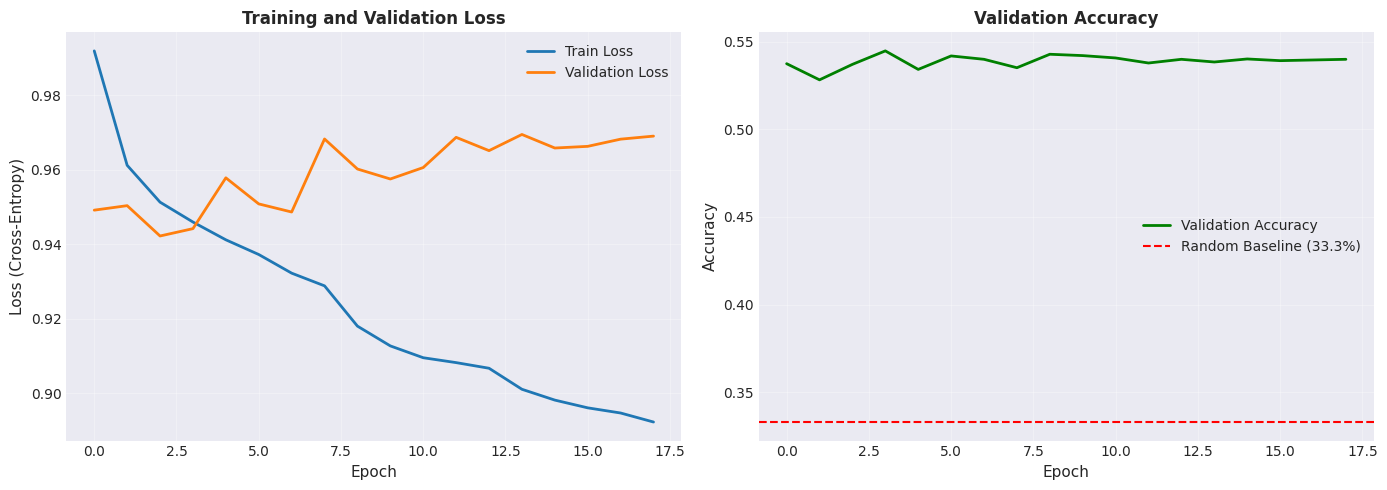


💡 TRAINING ANALYSIS:
   Final train loss: 0.8923
   Final val loss:   0.9691
   ✅ Curves are close - model is not overfitting


In [11]:
# ==============================================================================
# PLOT TRAINING HISTORY
# ==============================================================================

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Plot 1: Loss curves
# Good sign: Both curves decreasing, staying close together
# Bad sign: Train loss much lower than val loss (overfitting)
axes[0].plot(model.history['train_loss'], label='Train Loss', linewidth=2)
axes[0].plot(model.history['val_loss'], label='Validation Loss', linewidth=2)
axes[0].set_xlabel('Epoch', fontsize=11)
axes[0].set_ylabel('Loss (Cross-Entropy)', fontsize=11)
axes[0].set_title('Training and Validation Loss', fontsize=12, fontweight='bold')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Plot 2: Accuracy curve
# Good sign: Accuracy increasing and stabilizing
axes[1].plot(model.history['val_acc'], label='Validation Accuracy', 
             linewidth=2, color='green')
axes[1].axhline(y=0.333, color='red', linestyle='--', label='Random Baseline (33.3%)')
axes[1].set_xlabel('Epoch', fontsize=11)
axes[1].set_ylabel('Accuracy', fontsize=11)
axes[1].set_title('Validation Accuracy', fontsize=12, fontweight='bold')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('cnn_lstm_training_history.png', dpi=150, bbox_inches='tight')
plt.show()

# Analyze training
final_train_loss = model.history['train_loss'][-1]
final_val_loss = model.history['val_loss'][-1]
print("\n💡 TRAINING ANALYSIS:")
print(f"   Final train loss: {final_train_loss:.4f}")
print(f"   Final val loss:   {final_val_loss:.4f}")
if final_val_loss > final_train_loss * 1.5:
    print("   ⚠️ Gap suggests some overfitting - consider more dropout")
else:
    print("   ✅ Curves are close - model is not overfitting")

## 5. Evaluation on Test Set

In [12]:
# ==============================================================================
# FINAL EVALUATION
# ==============================================================================

print("\n" + "="*60)
print("🎯 TEST SET EVALUATION")
print("="*60)

test_metrics = model.evaluate(X_test, y_test)

print(f"\nTest Set Results:")
print(f"  Accuracy:    {test_metrics['accuracy']:.4f} ({test_metrics['accuracy']:.1%})")
print(f"  F1 Weighted: {test_metrics['f1_weighted']:.4f}")
print(f"  F1 Macro:    {test_metrics['f1_macro']:.4f}")

print(f"\n  Random Baseline: 33.3%")
print(f"  Improvement:     {(test_metrics['accuracy'] - 0.333)*100:+.1f}%")


🎯 TEST SET EVALUATION

Test Set Results:
  Accuracy:    0.5732 (57.3%)
  F1 Weighted: 0.5699
  F1 Macro:    0.5577

  Random Baseline: 33.3%
  Improvement:     +24.0%


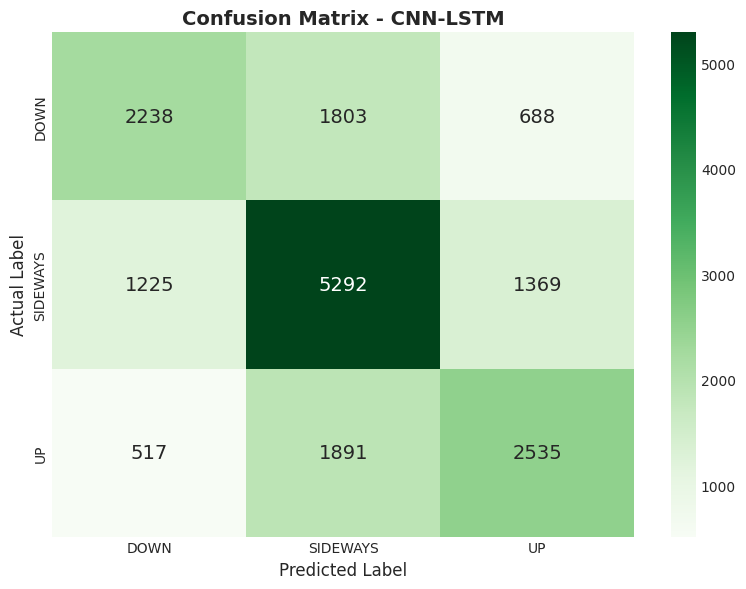

In [13]:
# ==============================================================================
# CONFUSION MATRIX
# ==============================================================================

fig, ax = plt.subplots(figsize=(8, 6))

cm = np.array(test_metrics['confusion_matrix'])
labels = ['DOWN', 'SIDEWAYS', 'UP']

sns.heatmap(cm, annot=True, fmt='d', cmap='Greens',
            xticklabels=labels, yticklabels=labels, ax=ax,
            annot_kws={"size": 14})
ax.set_xlabel('Predicted Label', fontsize=12)
ax.set_ylabel('Actual Label', fontsize=12)
ax.set_title('Confusion Matrix - CNN-LSTM', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.savefig('cnn_lstm_confusion_matrix.png', dpi=150, bbox_inches='tight')
plt.show()

In [14]:
# ==============================================================================
# SAVE MODEL
# ==============================================================================

print("\n" + "="*60)
print("💾 SAVING MODEL")
print("="*60)

Path('models_artifacts').mkdir(exist_ok=True)
model.save('models_artifacts', name=f'cnn_lstm_h{HORIZON}')
print(f"✅ Model saved: models_artifacts/cnn_lstm_h{HORIZON}_model.keras")


💾 SAVING MODEL
✅ Model saved to models_artifacts
✅ Model saved: models_artifacts/cnn_lstm_h1_model.keras


## 6. Hyperparameter Experiments

**WHY EXPERIMENT WITH LOOKBACK?**

The lookback window is one of the most important hyperparameters:
- Too short: Model can't see enough history
- Too long: Model may overfit to noise

We test several values to find the optimal one.

In [15]:
# ==============================================================================
# LOOKBACK EXPERIMENT
# ==============================================================================
#
# Test different lookback values to find optimal sequence length.
# This takes a while as we train multiple models.

print("\n" + "="*60)
print("🔬 LOOKBACK EXPERIMENTS")
print("="*60)
print("Testing different lookback values...")
print("This will train 4 models and may take 10-15 minutes.\n")

lookback_values = [5, 10, 20, 30]
lookback_results = []

for lb in lookback_values:
    print(f"\n--- Testing lookback={lb} ({lb * 15} minutes of history) ---")
    
    model_exp = CNNLSTMModel(
        n_classes=3,
        lookback=lb,
        conv_filters=16,
        lstm_units=64,
        dropout=0.5,
        device='cuda',
        random_seed=42
    )
    
    # Train with fewer epochs for experiments
    model_exp.fit(
        X_train, y_train, 
        X_val, y_val,
        epochs=50,       # Fewer epochs for speed
        batch_size=64, 
        patience=10,
        scale=True
    )
    
    metrics = model_exp.evaluate(X_test, y_test)
    
    lookback_results.append({
        'lookback': lb,
        'minutes': lb * 15,
        'accuracy': metrics['accuracy'],
        'f1_weighted': metrics['f1_weighted']
    })
    
    print(f"   Accuracy: {metrics['accuracy']:.4f}, F1: {metrics['f1_weighted']:.4f}")

# Display results
print("\n" + "="*60)
print("📊 LOOKBACK COMPARISON RESULTS")
print("="*60)

results_df = pd.DataFrame(lookback_results)
print("\n" + results_df.to_string(index=False))

# Find best
best_idx = results_df['accuracy'].idxmax()
best_lookback = results_df.loc[best_idx, 'lookback']
print(f"\n✅ Best lookback: {best_lookback} candles ({best_lookback * 15} minutes)")


🔬 LOOKBACK EXPERIMENTS
Testing different lookback values...
This will train 4 models and may take 10-15 minutes.


--- Testing lookback=5 (75 minutes of history) ---
🚀 GPU detected: /physical_device:GPU:0

📊 Preparing data...
📊 Creating sequences (lookback=5)...
   Train sequences: (46942, 5, 62)
   Val sequences: (5211, 5, 62)

🏗️ Building model...


Model: "cnn_lstm"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input (InputLayer)              │ (None, 5, 62)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 5, 16)          │         2,992 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn_conv1 (BatchNormalization)   │ (None, 5, 16)          │            64 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ relu_conv1 (Activation)         │ (None, 5, 16)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_conv1 (Dropout)         │ (None, 5, 16)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_2 (Conv1D)               │ (None, 5, 32)          │         1,568 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn_conv2 (BatchNormalization)   │ (None, 5, 32)          │           128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ relu_conv2 (Activation)         │ (None, 5, 32)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_conv2 (Dropout)         │ (None, 5, 32)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 5, 64)          │        24,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn_lstm1 (BatchNormalization)   │ (None, 5, 64)          │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_lstm1 (Dropout)         │ (None, 5, 64)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 128)            │        98,816 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │         4,128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 3)              │            99 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 132,883 (519.07 KB)

 Trainable params: 132,659 (518.20 KB)

 Non-trainable params: 224 (896.00 B)


🏋️ Training for up to 50 epochs (patience=10)...
Epoch 1/50
734/734 ━━━━━━━━━━━━━━━━━━━━ 14s 16ms/step - accuracy: 0.4900 - loss: 1.0171 - val_accuracy: 0.5270 - val_loss: 0.9691 - learning_rate: 0.0010
Epoch 2/50
734/734 ━━━━━━━━━━━━━━━━━━━━ 10s 13ms/step - accuracy: 0.5242 - loss: 0.9795 - val_accuracy: 0.5485 - val_loss: 0.9535 - learning_rate: 0.0010
Epoch 3/50
734/734 ━━━━━━━━━━━━━━━━━━━━ 11s 15ms/step - accuracy: 0.5320 - loss: 0.9672 - val_accuracy: 0.5519 - val_loss: 0.9458 - learning_rate: 0.0010
Epoch 4/50
734/734 ━━━━━━━━━━━━━━━━━━━━ 11s 15ms/step - accuracy: 0.5354 - loss: 0.9633 - val_accuracy: 0.5471 - val_loss: 0.9458 - learning_rate: 0.0010
Epoch 5/50
734/734 ━━━━━━━━━━━━━━━━━━━━ 10s 14ms/step - accuracy: 0.5360 - loss: 0.9602 - val_accuracy: 0.5488 - val_loss: 0.9477 - learning_rate: 0.0010
Epoch 6/50
734/734 ━━━━━━━━━━━━━━━━━━━━ 10s 14ms/step - accuracy: 0.5386 - loss: 0.9550 - val_accuracy: 0.5488 - val_loss: 0.9472 - learning_rate: 0.0010
Epoch 7/50
734/734 ━━━━━━━

Model: "cnn_lstm"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input (InputLayer)              │ (None, 10, 62)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 10, 16)         │         2,992 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn_conv1 (BatchNormalization)   │ (None, 10, 16)         │            64 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ relu_conv1 (Activation)         │ (None, 10, 16)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_conv1 (Dropout)         │ (None, 10, 16)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_2 (Conv1D)               │ (None, 10, 32)         │         1,568 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn_conv2 (BatchNormalization)   │ (None, 10, 32)         │           128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ relu_conv2 (Activation)         │ (None, 10, 32)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_conv2 (Dropout)         │ (None, 10, 32)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 10, 64)         │        24,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn_lstm1 (BatchNormalization)   │ (None, 10, 64)         │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_lstm1 (Dropout)         │ (None, 10, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 128)            │        98,816 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │         4,128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 3)              │            99 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 132,883 (519.07 KB)

 Trainable params: 132,659 (518.20 KB)

 Non-trainable params: 224 (896.00 B)


🏋️ Training for up to 50 epochs (patience=10)...
Epoch 1/50
734/734 ━━━━━━━━━━━━━━━━━━━━ 12s 14ms/step - accuracy: 0.4840 - loss: 1.0205 - val_accuracy: 0.5355 - val_loss: 0.9517 - learning_rate: 0.0010
Epoch 2/50
734/734 ━━━━━━━━━━━━━━━━━━━━ 9s 13ms/step - accuracy: 0.5236 - loss: 0.9756 - val_accuracy: 0.5392 - val_loss: 0.9438 - learning_rate: 0.0010
Epoch 3/50
734/734 ━━━━━━━━━━━━━━━━━━━━ 12s 16ms/step - accuracy: 0.5299 - loss: 0.9646 - val_accuracy: 0.5357 - val_loss: 0.9448 - learning_rate: 0.0010
Epoch 4/50
734/734 ━━━━━━━━━━━━━━━━━━━━ 10s 14ms/step - accuracy: 0.5346 - loss: 0.9581 - val_accuracy: 0.5386 - val_loss: 0.9489 - learning_rate: 0.0010
Epoch 5/50
734/734 ━━━━━━━━━━━━━━━━━━━━ 9s 13ms/step - accuracy: 0.5400 - loss: 0.9530 - val_accuracy: 0.5476 - val_loss: 0.9437 - learning_rate: 0.0010
Epoch 6/50
734/734 ━━━━━━━━━━━━━━━━━━━━ 11s 16ms/step - accuracy: 0.5431 - loss: 0.9505 - val_accuracy: 0.5361 - val_loss: 0.9518 - learning_rate: 0.0010
Epoch 7/50
734/734 ━━━━━━━━━

Model: "cnn_lstm"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input (InputLayer)              │ (None, 20, 62)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 20, 16)         │         2,992 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn_conv1 (BatchNormalization)   │ (None, 20, 16)         │            64 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ relu_conv1 (Activation)         │ (None, 20, 16)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_conv1 (Dropout)         │ (None, 20, 16)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_2 (Conv1D)               │ (None, 20, 32)         │         1,568 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn_conv2 (BatchNormalization)   │ (None, 20, 32)         │           128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ relu_conv2 (Activation)         │ (None, 20, 32)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_conv2 (Dropout)         │ (None, 20, 32)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 20, 64)         │        24,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn_lstm1 (BatchNormalization)   │ (None, 20, 64)         │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_lstm1 (Dropout)         │ (None, 20, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 128)            │        98,816 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │         4,128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 3)              │            99 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 132,883 (519.07 KB)

 Trainable params: 132,659 (518.20 KB)

 Non-trainable params: 224 (896.00 B)


🏋️ Training for up to 50 epochs (patience=10)...
Epoch 1/50
734/734 ━━━━━━━━━━━━━━━━━━━━ 12s 14ms/step - accuracy: 0.4934 - loss: 1.0092 - val_accuracy: 0.5366 - val_loss: 0.9765 - learning_rate: 0.0010
Epoch 2/50
734/734 ━━━━━━━━━━━━━━━━━━━━ 11s 15ms/step - accuracy: 0.5282 - loss: 0.9695 - val_accuracy: 0.5441 - val_loss: 0.9558 - learning_rate: 0.0010
Epoch 3/50
734/734 ━━━━━━━━━━━━━━━━━━━━ 11s 15ms/step - accuracy: 0.5355 - loss: 0.9583 - val_accuracy: 0.5452 - val_loss: 0.9615 - learning_rate: 0.0010
Epoch 4/50
734/734 ━━━━━━━━━━━━━━━━━━━━ 11s 15ms/step - accuracy: 0.5387 - loss: 0.9535 - val_accuracy: 0.5410 - val_loss: 0.9722 - learning_rate: 0.0010
Epoch 5/50
734/734 ━━━━━━━━━━━━━━━━━━━━ 10s 14ms/step - accuracy: 0.5421 - loss: 0.9487 - val_accuracy: 0.5429 - val_loss: 0.9566 - learning_rate: 0.0010
Epoch 6/50
734/734 ━━━━━━━━━━━━━━━━━━━━ 11s 15ms/step - accuracy: 0.5441 - loss: 0.9457 - val_accuracy: 0.5364 - val_loss: 0.9610 - learning_rate: 0.0010
Epoch 7/50
731/734 ━━━━━━━

Model: "cnn_lstm"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input (InputLayer)              │ (None, 30, 62)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 30, 16)         │         2,992 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn_conv1 (BatchNormalization)   │ (None, 30, 16)         │            64 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ relu_conv1 (Activation)         │ (None, 30, 16)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_conv1 (Dropout)         │ (None, 30, 16)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_2 (Conv1D)               │ (None, 30, 32)         │         1,568 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn_conv2 (BatchNormalization)   │ (None, 30, 32)         │           128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ relu_conv2 (Activation)         │ (None, 30, 32)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_conv2 (Dropout)         │ (None, 30, 32)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 30, 64)         │        24,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn_lstm1 (BatchNormalization)   │ (None, 30, 64)         │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_lstm1 (Dropout)         │ (None, 30, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 128)            │        98,816 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │         4,128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 3)              │            99 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 132,883 (519.07 KB)

 Trainable params: 132,659 (518.20 KB)

 Non-trainable params: 224 (896.00 B)


🏋️ Training for up to 50 epochs (patience=10)...
Epoch 1/50
734/734 ━━━━━━━━━━━━━━━━━━━━ 14s 16ms/step - accuracy: 0.4887 - loss: 1.0139 - val_accuracy: 0.5357 - val_loss: 0.9630 - learning_rate: 0.0010
Epoch 2/50
734/734 ━━━━━━━━━━━━━━━━━━━━ 13s 18ms/step - accuracy: 0.5264 - loss: 0.9716 - val_accuracy: 0.5285 - val_loss: 0.9614 - learning_rate: 0.0010
Epoch 3/50
734/734 ━━━━━━━━━━━━━━━━━━━━ 12s 16ms/step - accuracy: 0.5331 - loss: 0.9596 - val_accuracy: 0.5212 - val_loss: 0.9697 - learning_rate: 0.0010
Epoch 4/50
734/734 ━━━━━━━━━━━━━━━━━━━━ 13s 17ms/step - accuracy: 0.5397 - loss: 0.9537 - val_accuracy: 0.5314 - val_loss: 0.9631 - learning_rate: 0.0010
Epoch 5/50
734/734 ━━━━━━━━━━━━━━━━━━━━ 13s 18ms/step - accuracy: 0.5412 - loss: 0.9494 - val_accuracy: 0.5405 - val_loss: 0.9578 - learning_rate: 0.0010
Epoch 6/50
734/734 ━━━━━━━━━━━━━━━━━━━━ 11s 15ms/step - accuracy: 0.5424 - loss: 0.9451 - val_accuracy: 0.5405 - val_loss: 0.9583 - learning_rate: 0.0010
Epoch 7/50
734/734 ━━━━━━━

## 7. Summary

In [16]:
# ==============================================================================
# FINAL SUMMARY
# ==============================================================================

print("\n" + "="*60)
print("📋 CNN-LSTM MODEL SUMMARY")
print("="*60)

print(f"""
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
⚙️ CONFIGURATION
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
• Lookback: {LOOKBACK} candles ({LOOKBACK * 15} minutes)
• Architecture: Conv1D(16) → LSTM(64) → Dense(32) → Output(3)
• Dropout: 50%
• Learning Rate: 0.001
• Optimizer: Adam

━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
📊 TEST SET RESULTS
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
• Accuracy:    {test_metrics['accuracy']:.4f} ({test_metrics['accuracy']:.1%})
• F1 Weighted: {test_metrics['f1_weighted']:.4f}
• F1 Macro:    {test_metrics['f1_macro']:.4f}

━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
🔬 LOOKBACK EXPERIMENT RESULTS
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
{results_df.to_string(index=False)}

Best: lookback={best_lookback}

━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
💾 SAVED FILES
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
• Model: models_artifacts/cnn_lstm_h{HORIZON}_model.keras
• Training plot: cnn_lstm_training_history.png
• Confusion matrix: cnn_lstm_confusion_matrix.png
""")

print("="*60)
print("✅ CNN-LSTM TRAINING COMPLETE!")
print("="*60)
print("\nNext step: Run 04_comparison.py to compare models.")


📋 CNN-LSTM MODEL SUMMARY

━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
⚙️ CONFIGURATION
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
• Lookback: 10 candles (150 minutes)
• Architecture: Conv1D(16) → LSTM(64) → Dense(32) → Output(3)
• Dropout: 50%
• Learning Rate: 0.001
• Optimizer: Adam

━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
📊 TEST SET RESULTS
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
• Accuracy:    0.5732 (57.3%)
• F1 Weighted: 0.5699
• F1 Macro:    0.5577

━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
🔬 LOOKBACK EXPERIMENT RESULTS
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
 lookback  minutes  accuracy  f1_weighted
        5       75  0.563457     0.563093
       10      150  0.569142     0.566526
       20      300  0.560691     0.549631
       30      450  0.558844     0.556848

Best: lookback=10

━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
💾 SAVED FILES
━━━━━━━━━━━━━━━━━━━━━━━━━━